In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from tabulate import tabulate
import seaborn as sns
import scikitplot as skplt
from numpy import percentile
import math
from numpy import arange
import IPython.display as ipd
import matplotlib.lines as mlines

#pandas
from pandas.plotting import parallel_coordinates
import datetime

#sklearn
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler

from sklearn.decomposition import PCA
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import learning_curve

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score, precision_score, recall_score, make_scorer
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

#scikitplot
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_lift_curve
from scikitplot.metrics import plot_cumulative_gain

#tslearn
from tslearn.metrics import dtw, dtw_path, cdist_dtw, subsequence_cost_matrix

#mlxtend
from mlxtend.plotting import plot_decision_regions

#matplotlib
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import pyplot

#seaborn
import seaborn as sns

#scipy
import scipy.stats as stats
from scipy.stats import shapiro, mannwhitneyu, normaltest, kstest
from scipy.stats import boxcox, yeojohnson
from scipy.spatial.distance import euclidean, cityblock, cosine, minkowski
from scipy.spatial.distance import cdist

#matrixprofile
import matrixprofile
from matrixprofile import *
from matrixprofile.discords import discords

In [2]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, silhouette_samples, davies_bouldin_score
import numpy as np
import scipy.stats as stats
import collections
import math

#pyclustering
from pyclustering.cluster import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster import cluster_visualizer_multidim

<h2>Functions</h2>

In [3]:
def visualize_clusters(df, X, list_of_columns, clusters, centers):
    
    for x in range(len(list_of_columns)):
        for z in range(x+1, len(list_of_columns)):
            
            i = df.columns.values.tolist().index(list_of_columns[x])
            j = df.columns.values.tolist().index(list_of_columns[z])

            plt.title(list_of_columns[x].title() + " - " + list_of_columns[z].title())
            plt.xlabel(list_of_columns[x])
            plt.ylabel(list_of_columns[z])
    
            for indexes in clusters:
                plt.scatter(X[indexes,i], X[indexes,j], alpha=0.4)
            for c in centers:
                plt.scatter(c[i], c[j], s=100, edgecolors='k')
                
            plt.show()

In [4]:
def control_clusters(clusters):
    somma = 0
    print("Number of clusters: {}".format(len(clusters)))
    print()
    print()
    print("Content of each cluster")
    print()
    for i, cluster in enumerate(clusters):
        print("Cluster {}: {}".format(i, len(cluster)))
        somma+=len(cluster)

    print()
    print("Total elements in all clusters: {}".format(somma))

In [5]:
def inertia(number_of_clusters, X, labels):
    
    manual_SSE = 0
    for i in range(number_of_clusters):
        cluster = X[labels == i]
        if len(cluster) > 0:
                clusterMean = cluster.mean(axis = 0)
                manual_SSE += ((cluster - clusterMean) ** 2).sum()
                
    return manual_SSE

In [6]:
def cluster_insight(df):
    
    cluster_diz = pd.DataFrame(columns = ["Studio_Recording", "Live_Recording"], \
                                index = ["Cluster {}".format(str(i)) for i in np.unique(df['Labels'])])
    
    tot_entropies = []
    dim_clusters = []
    max_cluster = 0

    for i in np.unique(df['Labels']):

        cluster_list = list(df[df['Labels'] == i]['album_type'])

        counter = collections.Counter(cluster_list)

        cluster_diz.loc["Cluster {}".format(str(i)), 'Studio_Recording'] = counter[0]
        cluster_diz.loc["Cluster {}".format(str(i)), 'Live_Recording'] = counter[1]

        #cluster_diz.loc["Cluster {}".format(str(i)), 'Tot_Cluster'] = cluster_diz.loc["Cluster {}".format(str(i)), ['Studio_Recording', 'Live_Recording']].sum()

        lista = cluster_diz.loc['Cluster {}'.format(str(i)), ['Studio_Recording', 'Live_Recording']].values.tolist()
        tot = sum(lista)
        cluster_diz.loc["Cluster {}".format(str(i)), 'Tot_Cluster'] = tot
        dim_clusters.append(tot)

        '''
        Entropia singola: -(sommatoria di (pij log2 pij) per tutte le classi all'interno di un cluster.
        --> pij = mij/mj dove mj è il numero di valori nel cluster j e mij è il numero di valori della classe i
        nel cluster j.
        '''
        entropy_single = sum([(x/tot)*math.log2(x/tot) for x in lista if x != 0])
        if entropy_single != 0.0:
            entropy_single*=-1
        cluster_diz.loc["Cluster {}".format(str(i)), 'Entropy'] = "%.4f" %(entropy_single)
        tot_entropies.append(entropy_single)


        '''
        Purity singola: etichetta della classe più frequente/numero di valori nel cluster
        '''
        purity_single = max(lista)/tot
        cluster_diz.loc["Cluster {}".format(str(i)), 'Purity'] = "%.4f" %(purity_single)

        max_cluster += max(lista)


    new_row = pd.Series(cluster_diz[['Studio_Recording', 'Live_Recording', 'Tot_Cluster']].sum(axis=0).astype(int), name = "Total")
    cluster_diz = cluster_diz.append(new_row, ignore_index=False)

    '''
    Entropia complessiva: sommatoria delle entropie di ogni cluster pesate per la dimensione di ogni cluster.
    --> (mj/m) * ej --> dove mj è la dimensione del cluster j e m è il numero totale di punti. 
    '''

    last_tot = cluster_diz.loc['Total', 'Tot_Cluster']
    tot_entropy = 0

    for entropy, dim in zip(tot_entropies, dim_clusters):
        tot_entropy+=(entropy*(dim/last_tot))

    cluster_diz.loc["Total", 'Entropy'] = "%.4f" %(tot_entropy)

    '''
    Purity complessiva: sommatoria delle classi "corrette" (il valore più alto) di ogni cluster, divisa per il
    numero totale di valori.
    '''

    tot_purity = max_cluster/last_tot
    cluster_diz.loc["Total", 'Purity'] = "%.4f" %(tot_purity)



    cluster_diz['Tot_Cluster'] = cluster_diz['Tot_Cluster'].astype(int)

    ipd.display(cluster_diz)

In [7]:
def plot_general_distributions(df):
    
    for column in df.columns:

        if column != 'Labels':

            fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 5))
            cluster_list = []
            list_num_cluster = []

            for num_cluster in np.unique(df['Labels']):
                cluster_list.append(df[df['Labels'] == num_cluster][column])  #distribution
                list_num_cluster.append('Cluster %s' % num_cluster)           #num cluster

            ax[0].hist(cluster_list, label = list_num_cluster)
            ax[0].legend(title="Clusters", bbox_to_anchor = (1, 1.05), loc='upper left', \
                   frameon = True, shadow = True)
            ax[0].set_title(column + " Histogram")

            ax[1].hist(df[column], color = "#B8002E")
            ax[1].set_title(column + " Histogram (Distribution in the whole dataset)")

            fig.tight_layout()
            plt.show()

In [8]:
def analyze_single_clusters(df):
    
    for label in np.unique(df['Labels']):
        
        print("Cluster {}".format(label))
        print()
        
        Studio_0_dataset = df[(df['Labels'] == label) & (df['album_type'] == 0)]

        Live_1_dataset = df[(df['Labels'] == label) & (df['album_type'] == 1)]

        for column in df.columns:

            if (column != 'Labels' and column != 'album_type'):

                fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 5), sharey = True)

                ax[0].hist(Studio_0_dataset[column], label = 'Studio_Recording', color = "#8AB800")
                ax[0].legend(loc='upper right')
                ax[0].set_title(column + " Histogram - Cluster {}".format(label))

                ax[1].hist(Live_1_dataset[column], label = 'Live_Recording', color = "#FF3D3D")
                ax[1].legend(loc='upper right')
                ax[1].set_title(column + " Histogram - Cluster {}".format(label))

                plt.show()
        print("------------------------------------------------------------------------------------------------------------------")

In [9]:
def run_xmeans(df_to_copy, X):
    
    max_k = 30
    sse_list = list()
    silhouette = list()
    calinski = list()
    bouldin = list()
    fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (18, 10))

    for k in range(2, max_k+1):
        
        #-----------------------------------run algorithm------------------------------------#
        amount_initial_centers = 2
        initial_centers = kmeans_plusplus_initializer(X, amount_initial_centers).initialize()

        xmeans_instance = xmeans.xmeans(X, initial_centers, k)
        xmeans_instance.process()

        clusters = xmeans_instance.get_clusters()
        centers = xmeans_instance.get_centers()

        
        #--------------------------retrieve cluster labels for the dataset-------------------#
        
        label_index = list(np.arange(len(clusters))) #list of labels for clusters

        diz_temp = dict()
        for label, cluster_content in zip(label_index, clusters):
            diz_temp[label] = cluster_content

        df_copy = pd.DataFrame(X, columns = df_to_copy.columns, index = df_to_copy.index)

        for label, cluster in diz_temp.items():
            for index in cluster:
                df_copy.loc[df_copy.iloc[index].name, 'Labels'] = label

        df_copy['Labels'] = df_copy['Labels'].astype(int)

        xmeans_labels = np.array(df_copy['Labels'])
    
    
        #-----------------------------------calculate metrics--------------------------------#
        
        sse = inertia(len(clusters), X, xmeans_labels)
        sse_list.append(sse)
        
        sil = silhouette_score(X, xmeans_labels)
        silhouette.append(sil)
        
        cal = calinski_harabasz_score(X, xmeans_labels)
        calinski.append(cal)
        
        boul = davies_bouldin_score(X, xmeans_labels)
        bouldin.append(boul)
        
        print("k: ", k)
        print ('SSE: ', sse)
        print ('Silhouette Score: ', sil)
        print ("Calinski - Harabaz Score: ", cal)
        print ("Davies - Bouldin Score: ", boul)
        print()
        print("---------------------------------")
        print()
        
        
    
    index = [i for i in range(2, max_k + 1)]
    
    ax[0, 0].plot(range(2, len(sse_list) + 2), sse_list)
    ax[0, 0].set_ylabel('SSE', fontsize=15)
    ax[0, 0].set_xlabel('K', fontsize=15)

    ax[0, 1].plot(range(2, len(silhouette) + 2), silhouette)
    ax[0, 1].set_ylabel('SIL', fontsize=15)
    ax[0, 1].set_xlabel('K', fontsize=15)

    ax[1, 0].plot(range(2, len(calinski) + 2), calinski)
    ax[1, 0].set_ylabel('CAL', fontsize=15)
    ax[1, 0].set_xlabel('K', fontsize=15)

    ax[1, 1].plot(range(2, len(bouldin) + 2), bouldin)
    ax[1, 1].set_ylabel('BOUL', fontsize=15)
    ax[1, 1].set_xlabel('K', fontsize=15)
    
    for axis in ax.flat:
        axis.xaxis.set_major_locator(MultipleLocator(5))
        axis.xaxis.set_minor_locator(MultipleLocator(1))
        axis.tick_params(which='major', length=9)
        axis.tick_params(which='minor', length=7, color='r')

    plt.show()
    fig.tight_layout()

In [10]:
def concatenate(df_generale, df):
    
    #new_row = pd.Series(dtype='object', name = '----------')
    #df_generale = df_generale.append(new_row, ignore_index=False)
    #df_generale = df_generale.replace(np.nan, '----------', regex = True)
    
    df_generale = pd.concat([df_generale, df])
    #ipd.display(df_generale)
    
    return df_generale

In [11]:
df_complete = pd.read_csv('group_20_fma_numeric.csv', index_col = 0)

In [12]:
df_complete

chroma_cens_02  chroma_cens_04  chroma_cens_06  chroma_cens_07  \
track_id                                                                   
2               0.534301        0.311606        0.336365        0.341694   
3               0.331490        0.296091        0.368770        0.550413   
5               0.438305        0.298619        0.358552        0.411062   
10              0.414595        0.309863        0.438154        0.616182   
20              0.354114        0.256808        0.361826        0.415287   
...                  ...             ...             ...             ...   
155316          0.239374        0.506758        0.610919        0.257752   
155317          0.376784        0.453340        0.290186        0.281965   
155318          0.297417        0.480687        0.499205        0.311303   
155319          0.376004        0.361030        0.479526        0.444307   
155320          0.326523        0.399048        0.392797        0.320429   

          chroma_cens_09  chroma_cens_11  chroma_stft_05  chroma_stft_08  \
track_id                                                                   
2               0.292243        0.276052        0.341598        0.430064   
3               0.464814        0.363497        0.391794        0.581584   
5               0.515737        0.338845        0.335509        0.353870   
10              0.399730        0.369890        0.357122        0.420764   
20              0.368049        0.419011        0.390003        0.575782   
...                  ...             ...             ...             ...   
155316          0.253840        0.242582        0.512779        0.418091   
155317          0.324159        0.404858        0.579709        0.609059   
155318          0.363107        0.317513        0.582218        0.529418   
155319          0.405410        0.283908        0.628887        0.527227   
155320          0.447267        0.365973        0.617016        0.533301   

          chroma_stft_10  chroma_stft_12  ...  track_genre_top_Easy_Listening  \
track_id                                  ...                                   
2               0.381936        0.529627  ...                               0   
3               0.510926        0.540496  ...                               0   
5               0.418968        0.467409  ...                               0   
10              0.370725        0.388618  ...                               0   
20              0.556986        0.491322  ...                               0   
...                  ...             ...  ...                             ...   
155316          0.422479        0.476460  ...                               0   
155317          0.567302        0.643192  ...                               0   
155318          0.496228        0.579227  ...                               0   
155319          0.411554        0.615549  ...                               0   
155320          0.631633        0.561229  ...                               0   

          track_genre_top_Instrumental  track_bit_rate  track_duration  \
track_id                                                                 
2                                    0          256000             168   
3                                    0          256000             237   
5                                    0          256000             206   
10                                   0          192000             161   
20                                   0          256000             311   
...                                ...             ...             ...   
155316                               0          320000             162   
155317                               0          320000             217   
155318                               0          320000             404   
155319                               0          320000             146   
155320                               0          320000             198   

          track

In [13]:
df_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103708 entries, 2 to 155320
Data columns (total 56 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   chroma_cens_02                       103708 non-null  float64
 1   chroma_cens_04                       103708 non-null  float64
 2   chroma_cens_06                       103708 non-null  float64
 3   chroma_cens_07                       103708 non-null  float64
 4   chroma_cens_09                       103708 non-null  float64
 5   chroma_cens_11                       103708 non-null  float64
 6   chroma_stft_05                       103708 non-null  float64
 7   chroma_stft_08                       103708 non-null  float64
 8   chroma_stft_10                       103708 non-null  float64
 9   chroma_stft_12                       103708 non-null  float64
 10  mfcc_02                              103708 non-null  float64
 11  mfcc_03      

In [14]:
df_complete.shape

(103708, 56)

**Continous variables**

In [15]:
numeric_columns = []  # continous variables
for column_name in df_complete.columns:
    if ("track_genre_top" not in column_name) and  \
          ("track_date_created_year" not in column_name) and \
            ("track_date_created_season" not in column_name):
                numeric_columns.append(column_name)
print("numeric_columns", len(numeric_columns))

numeric_columns 38


**Ordinal or Categorical variables**

In [16]:
categoric_columns = []  # ordinal or categorical variables
for column_name in df_complete.columns:
    if ("track_genre_top" in column_name) or  \
          ("track_date_created_year" in column_name) or \
            ("track_date_created_season" in column_name):
                categoric_columns.append(column_name)
print("categoric_columns", len(categoric_columns))

categoric_columns 18


<h2>Feature selection 1</h2>

In [17]:
df_sel_1_complete = df_complete[['mfcc_20', 'rmse_01', 'track_listens', 'artist_favorites', 'album_type']]

In [18]:
df_sel_1_complete

mfcc_20   rmse_01  track_listens  artist_favorites  album_type
track_id                                                                 
2         0.558185  0.119543           1293                 9           0
3         0.612446  0.135237            514                 9           0
5         0.561984  0.121891           1151                 9           0
10        0.623545  0.145977          50135                74           0
20        0.671041  0.172470            361                10           0
...            ...       ...            ...               ...         ...
155316    0.585619  0.144543            102                 0           1
155317    0.610815  0.095365            165                 0           1
155318    0.584137  0.109468            168                 0           1
155319    0.582021  0.118471            294                 0           1
155320    0.600674  0.264220            705                12           0

[103708 rows x 5 columns]

In [19]:
df_sel_1 = df_sel_1_complete[[col for col in df_sel_1_complete if col != 'album_type']]

In [20]:
df_sel_1

mfcc_20   rmse_01  track_listens  artist_favorites
track_id                                                     
2         0.558185  0.119543           1293                 9
3         0.612446  0.135237            514                 9
5         0.561984  0.121891           1151                 9
10        0.623545  0.145977          50135                74
20        0.671041  0.172470            361                10
...            ...       ...            ...               ...
155316    0.585619  0.144543            102                 0
155317    0.610815  0.095365            165                 0
155318    0.584137  0.109468            168                 0
155319    0.582021  0.118471            294                 0
155320    0.600674  0.264220            705                12

[103708 rows x 4 columns]

In [21]:
scaler = RobustScaler()
X = scaler.fit_transform(df_sel_1)

In [22]:
X

array([[-0.85878244, -0.24219802,  0.30590962,  0.26666667],
       [-0.05843636, -0.11161916, -0.14542294,  0.26666667],
       [-0.80273435, -0.22266237,  0.22363847,  0.26666667],
       ...,
       [-0.47598471, -0.32602687, -0.34588644, -0.33333333],
       [-0.50720174, -0.25111899, -0.27288528, -0.33333333],
       [-0.23207224,  0.96155751, -0.03476246,  0.46666667]])

In [23]:
# Prepare initial centers - amount of initial centers defines amount of clusters from which X-Means will
# start analysis.
amount_initial_centers = 2
initial_centers = kmeans_plusplus_initializer(X, amount_initial_centers).initialize()

In [24]:
# Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
# number of clusters that can be allocated is 20 (default).
xmeans_instance = xmeans.xmeans(X, initial_centers, 3)
xmeans_instance.process()

* **get_clusters**: Returns list of allocated clusters, **each cluster contains indexes of objects in list of data**.

* **get_centers**: Returns list of centers for allocated clusters.

In [25]:
# Extract clustering results: clusters and their centers
clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()

In [26]:
list_of_columns = df_sel_1.columns

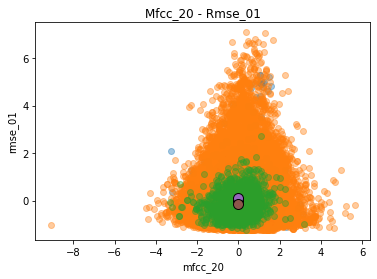

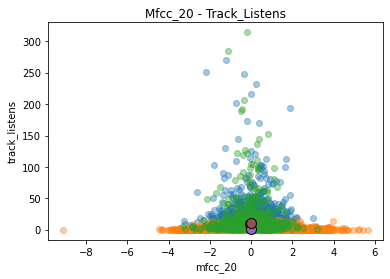

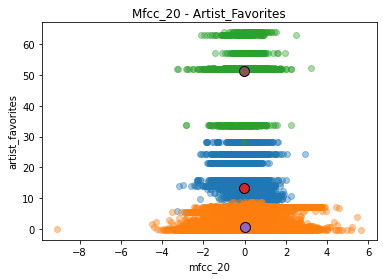

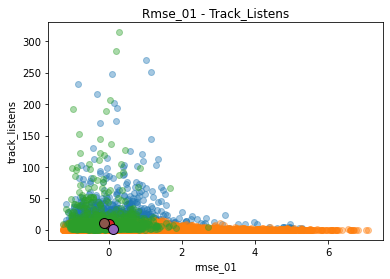

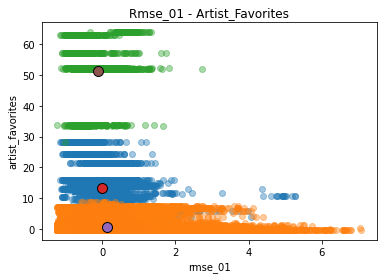

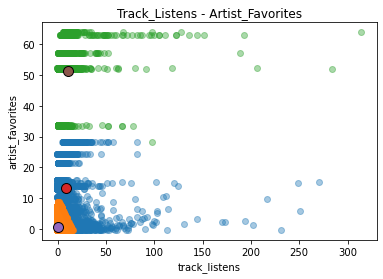

In [27]:
visualize_clusters(df_sel_1, X, list_of_columns, clusters, centers)

In [28]:
control_clusters(clusters)

Number of clusters: 3


Content of each cluster

Cluster 0: 3772
Cluster 1: 98486
Cluster 2: 1450

Total elements in all clusters: 103708


**Creo le etichette per i clusters**

In [29]:
label_index = list(np.arange(len(clusters)))
label_index

[0, 1, 2]

**Realizzo un dizionario in cui salvo, per ogni cluster, gli indici che contiene**

In [30]:
dict_clusters = dict()
for label, cluster_content in zip(label_index, clusters):
    dict_clusters[label] = cluster_content

**Creo una copia del dataset originale**

In [31]:
df_sel_1_complete_labels = df_sel_1_complete.copy()

**Scorro il dizionario per (chiave, contenuto) e, per ogni elemento contenuto all'interno di ogni cluster, vado ad aggiungere nella nuova colonna 'Labels' del dataset, in corrispondenza dell'indice salvato nel dizionario, il valore della chiave (il cluster a cui appartiene)**

In [32]:
for label, cluster in dict_clusters.items():
    for index in cluster:
        df_sel_1_complete_labels.loc[df_sel_1_complete_labels.iloc[index].name, 'Labels'] = label
        #(qui vado a prendere il nome, cioè la track_id, perchè loc vuole il nome dell'indice (nel nostro
        #caso la track_id), mentre iloc vuole l'indice esatto del dataframe, quindi, siccome ho gli indici
        #veri e propri dei record clusterizzati restituiti dai cluster ottenuti, vado prima a prendere il nome 
        #(track_id) con .iloc[index].name, in modo da poter passare il nome a .loc)

**Converto la colonna delle Labels in numeri interi**

In [33]:
df_sel_1_complete_labels['Labels'] = df_sel_1_complete_labels['Labels'].astype(int)

In [34]:
df_sel_1_complete_labels

mfcc_20   rmse_01  track_listens  artist_favorites  album_type  \
track_id                                                                    
2         0.558185  0.119543           1293                 9           0   
3         0.612446  0.135237            514                 9           0   
5         0.561984  0.121891           1151                 9           0   
10        0.623545  0.145977          50135                74           0   
20        0.671041  0.172470            361                10           0   
...            ...       ...            ...               ...         ...   
155316    0.585619  0.144543            102                 0           1   
155317    0.610815  0.095365            165                 0           1   
155318    0.584137  0.109468            168                 0           1   
155319    0.582021  0.118471            294                 0           1   
155320    0.600674  0.264220            705                12           0   

          Labels  
track_id          
2              1  
3              1  
5              1  
10             0  
20             1  
...          ...  
155316         1  
155317         1  
155318         1  
155319         1  
155320         1  

[103708 rows x 6 columns]

**Creo l'array con le etichette di ogni record, l'equivalente di kmeans.labels_**

In [35]:
xmeans_labels = np.array(df_sel_1_complete_labels['Labels'])

In [36]:
xmeans_labels

array([1, 1, 1, ..., 1, 1, 1])

**Calcolo le metriche dei clusters**

In [37]:
SSE = inertia(len(clusters), X, xmeans_labels)
SILHOUETTE = silhouette_score(X, xmeans_labels)
CALINSKI = calinski_harabasz_score(X, xmeans_labels)
BOULDIN = davies_bouldin_score(X, xmeans_labels)

print ('SSE: ', SSE)
print ('Silhouette Score: ', SILHOUETTE)
print ("Calinski - Harabasz Score: ", CALINSKI)
print ("Davies - Bouldin Score: ", BOULDIN)

print()

df_metrics_1 = pd.DataFrame({'N_clusters': len(np.unique(xmeans_labels)), 'SSE': '%.4f'%(SSE), \
                             'Silhouette': '%.4f'%(SILHOUETTE), 'Calinski': '%.4f'%(CALINSKI), \
                             'Bouldin': '%.4f'%(BOULDIN)}, index = ['Feature selection 1'])

SSE:  2481727.325460207
Silhouette Score:  0.8258979126083955
Calinski - Harabasz Score:  96217.96278998979
Davies - Bouldin Score:  0.7916594647938299



In [38]:
df_generale = df_metrics_1.copy()

In [39]:
cluster_insight(df_sel_1_complete_labels)

Studio_Recording Live_Recording  Tot_Cluster Entropy  Purity
Cluster 0             3758             14         3772  0.0353  0.9963
Cluster 1            86975          11511        98486  0.5203  0.8831
Cluster 2             1450              0         1450  0.0000  1.0000
Total                92183          11525       103708  0.4954  0.8889

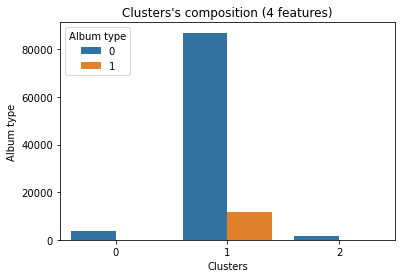

In [40]:
b = sns.countplot(x=df_sel_1_complete_labels['Labels'], data=df_sel_1_complete_labels, \
                  hue = df_sel_1_complete_labels['album_type'])
b.set_xlabel("Clusters")
b.set_ylabel("Album type")
b.set_title("Clusters's composition ({} features)".format(df_sel_1.shape[1]))
b.tick_params()
b.legend_.set_title('Album type')
b.grid(False)

<h1>Feature selection 2</h1>

In [41]:
df_sel_2_complete = df_complete[['mfcc_03', 'track_listens', 'artist_favorites', 'album_type']]

In [42]:
df_sel_2_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103708 entries, 2 to 155320
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   mfcc_03           103708 non-null  float64
 1   track_listens     103708 non-null  int64  
 2   artist_favorites  103708 non-null  int64  
 3   album_type        103708 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 4.0 MB


In [43]:
df_sel_2 = df_sel_2_complete[[col for col in df_sel_2_complete if col != 'album_type']]

In [44]:
df_sel_2

mfcc_03  track_listens  artist_favorites
track_id                                           
2         0.421154           1293                 9
3         0.449291            514                 9
5         0.505918           1151                 9
10        0.382519          50135                74
20        0.599838            361                10
...            ...            ...               ...
155316    0.460963            102                 0
155317    0.506290            165                 0
155318    0.448987            168                 0
155319    0.452419            294                 0
155320    0.519753            705                12

[103708 rows x 3 columns]

In [45]:
scaler = RobustScaler()
X = scaler.fit_transform(df_sel_2)

In [46]:
X

array([[-0.73524464,  0.30590962,  0.26666667],
       [-0.51768102, -0.14542294,  0.26666667],
       [-0.07981614,  0.22363847,  0.26666667],
       ...,
       [-0.52003059, -0.34588644, -0.33333333],
       [-0.49349225, -0.27288528, -0.33333333],
       [ 0.02715469, -0.03476246,  0.46666667]])

In [47]:
# Prepare initial centers - amount of initial centers defines amount of clusters from which X-Means will
# start analysis.
amount_initial_centers = 2
initial_centers = kmeans_plusplus_initializer(X, amount_initial_centers).initialize()

In [48]:
# Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
# number of clusters that can be allocated is 20 (default).
xmeans_instance = xmeans.xmeans(X, initial_centers, 3)
xmeans_instance.process()

* **get_clusters**: Returns list of allocated clusters, **each cluster contains indexes of objects in list of data**.

* **get_centers**: Returns list of centers for allocated clusters.

In [49]:
# Extract clustering results: clusters and their centers
clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()

In [50]:
list_of_columns = df_sel_2.columns

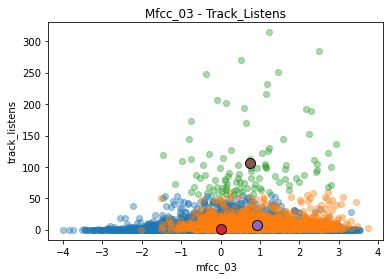

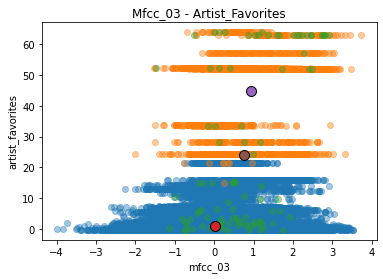

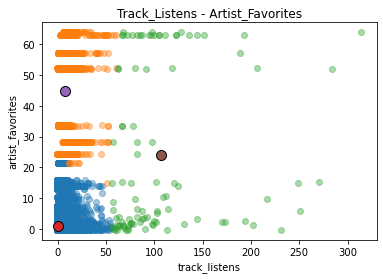

In [51]:
visualize_clusters(df_sel_2, X, list_of_columns, clusters, centers)

In [52]:
control_clusters(clusters)

Number of clusters: 3


Content of each cluster

Cluster 0: 101712
Cluster 1: 1898
Cluster 2: 98

Total elements in all clusters: 103708


**Creo le etichette per i clusters**

In [53]:
label_index = list(np.arange(len(clusters)))
label_index

[0, 1, 2]

**Realizzo un dizionario in cui salvo, per ogni cluster, gli indici che contiene**

In [54]:
dict_clusters = dict()
for label, cluster_content in zip(label_index, clusters):
    dict_clusters[label] = cluster_content

**Creo una copia del dataset originale**

In [55]:
df_sel_2_complete_labels = df_sel_2_complete.copy()

**Scorro il dizionario per (chiave, contenuto) e, per ogni elemento contenuto all'interno di ogni cluster, vado ad aggiungere nella nuova colonna 'Labels' del dataset, in corrispondenza dell'indice salvato nel dizionario, il valore della chiave (il cluster a cui appartiene)**

In [56]:
for label, cluster in dict_clusters.items():
    for index in cluster:
        df_sel_2_complete_labels.loc[df_sel_2_complete_labels.iloc[index].name, 'Labels'] = label
        #(qui vado a prendere il nome, cioè la track_id, perchè loc vuole il nome dell'indice (nel nostro
        #caso la track_id), mentre iloc vuole l'indice esatto del dataframe, quindi, siccome ho gli indici
        #veri e propri dei record clusterizzati restituiti dai cluster ottenuti, vado prima a prendere il nome 
        #(track_id) con .iloc[index].name, in modo da poter passare il nome a .loc)

**Converto la colonna delle Labels in numeri interi**

In [57]:
df_sel_2_complete_labels['Labels'] = df_sel_2_complete_labels['Labels'].astype(int)

In [58]:
df_sel_2_complete_labels

mfcc_03  track_listens  artist_favorites  album_type  Labels
track_id                                                               
2         0.421154           1293                 9           0       0
3         0.449291            514                 9           0       0
5         0.505918           1151                 9           0       0
10        0.382519          50135                74           0       0
20        0.599838            361                10           0       0
...            ...            ...               ...         ...     ...
155316    0.460963            102                 0           1       0
155317    0.506290            165                 0           1       0
155318    0.448987            168                 0           1       0
155319    0.452419            294                 0           1       0
155320    0.519753            705                12           0       0

[103708 rows x 5 columns]

**Creo l'array con le etichette di ogni record, l'equivalente di kmeans.labels_**

In [59]:
xmeans_labels = np.array(df_sel_2_complete_labels['Labels'])

In [60]:
xmeans_labels

array([0, 0, 0, ..., 0, 0, 0])

**Calcolo le metriche dei clusters**

In [61]:
SSE = inertia(len(clusters), X, xmeans_labels)
SILHOUETTE = silhouette_score(X, xmeans_labels)
CALINSKI = calinski_harabasz_score(X, xmeans_labels)
BOULDIN = davies_bouldin_score(X, xmeans_labels)

print ('SSE: ', SSE)
print ('Silhouette Score: ', SILHOUETTE)
print ("Calinski - Harabasz Score: ", CALINSKI)
print ("Davies - Bouldin Score: ", BOULDIN)

print()

df_metrics_2 = pd.DataFrame({'N_clusters': len(np.unique(xmeans_labels)), 'SSE': '%.4f'%(SSE), \
                             'Silhouette': '%.4f'%(SILHOUETTE), 'Calinski': '%.4f'%(CALINSKI), \
                             'Bouldin': '%.4f'%(BOULDIN)}, index = ['Feature selection 2'])

SSE:  2201073.2659091363
Silhouette Score:  0.9187994241673594
Calinski - Harabasz Score:  113603.39196777875
Davies - Bouldin Score:  0.5861266989259901



In [62]:
df_generale = concatenate(df_generale, df_metrics_2)

In [63]:
cluster_insight(df_sel_2_complete_labels)

Studio_Recording Live_Recording  Tot_Cluster Entropy  Purity
Cluster 0            90187          11525       101712  0.5098  0.8867
Cluster 1             1898              0         1898  0.0000  1.0000
Cluster 2               98              0           98  0.0000  1.0000
Total                92183          11525       103708  0.5000  0.8889

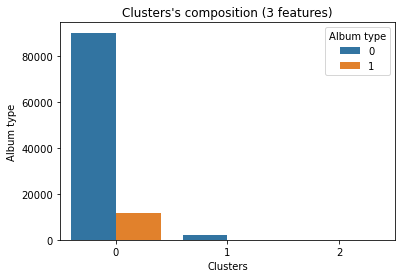

In [64]:
b = sns.countplot(x=df_sel_2_complete_labels['Labels'], data=df_sel_2_complete_labels, \
                  hue = df_sel_2_complete_labels['album_type'])
b.set_xlabel("Clusters")
b.set_ylabel("Album type")
b.set_title("Clusters's composition ({} features)".format(df_sel_2.shape[1]))
b.tick_params()
b.legend_.set_title('Album type')
b.grid(False)

<h3>Summary</h3>

In [65]:
ipd.display(df_generale)

N_clusters           SSE Silhouette     Calinski Bouldin
Feature selection 1           3  2481727.3255     0.8259   96217.9628  0.7917
Feature selection 2           3  2201073.2659     0.9188  113603.3920  0.5861

In [66]:
df_sel_2_complete_labels.to_csv("dataset_con_labels_migliore_xmeans.csv")

In [75]:
df_metrics_2

N_clusters           SSE Silhouette     Calinski Bouldin
Feature selection 2           3  2201073.2659     0.9188  113603.3920  0.5861

In [92]:
df_metrics_def = df_metrics_2.copy()

In [116]:
index = [' - '.join([i for i in df_sel_2.columns])]

In [117]:
df_metrics_def.index = index

In [118]:
df_metrics_def

N_clusters           SSE  \
mfcc_03 - track_listens - artist_favorites           3  2201073.2659   

                                           Silhouette     Calinski Bouldin  
mfcc_03 - track_listens - artist_favorites     0.9188  113603.3920  0.5861

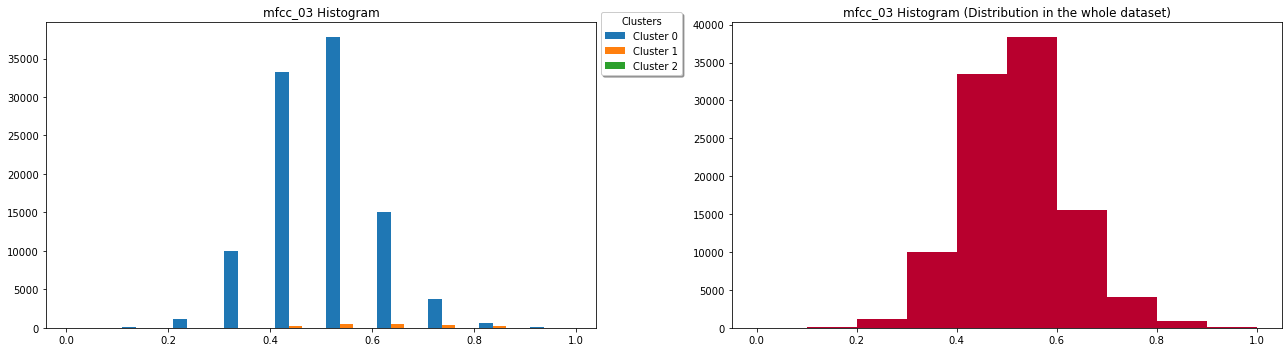

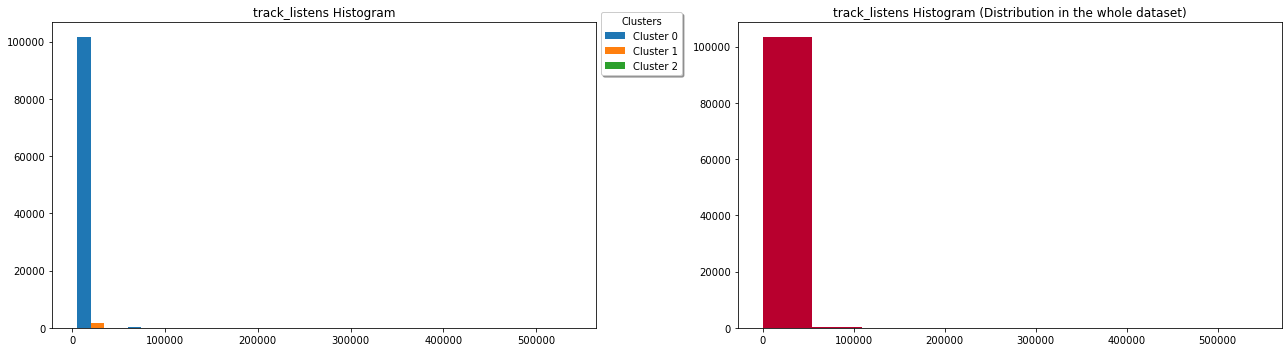

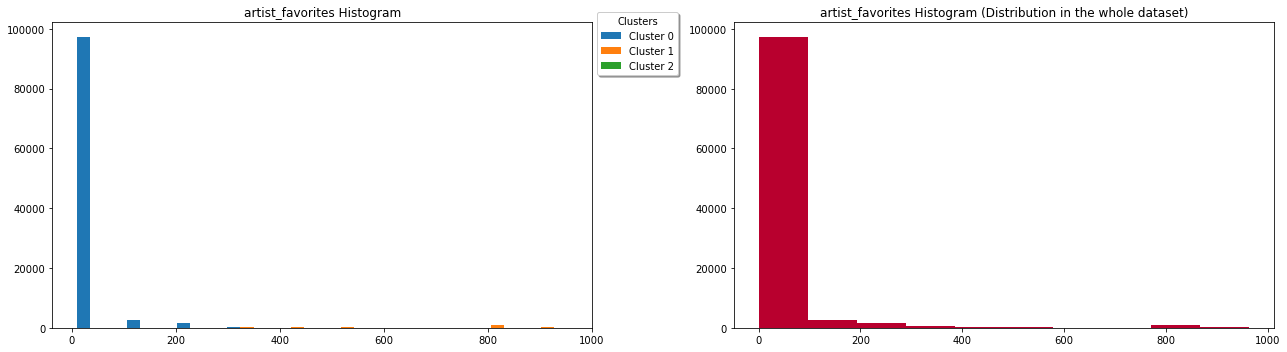

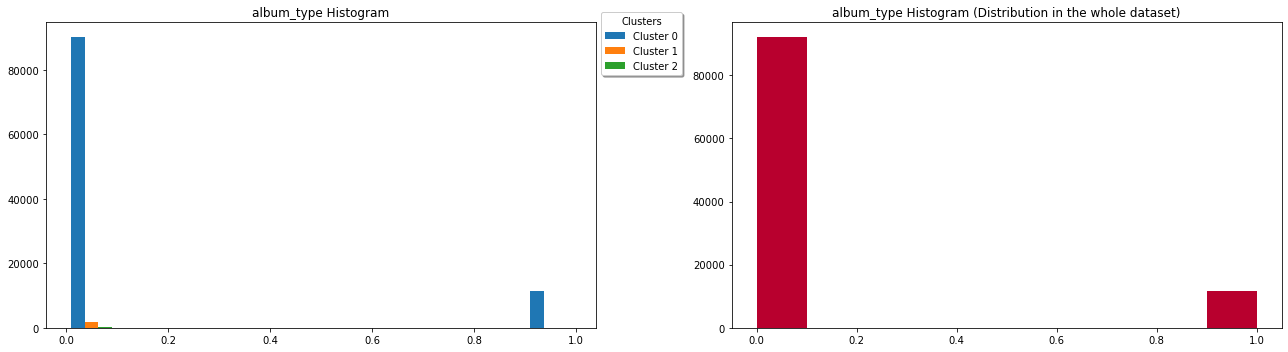

In [69]:
plot_general_distributions(df_sel_2_complete_labels)

In [70]:
df_complete_2 = df_complete.copy()

In [71]:
df_complete_2['Labels'] = df_sel_2_complete_labels['Labels']

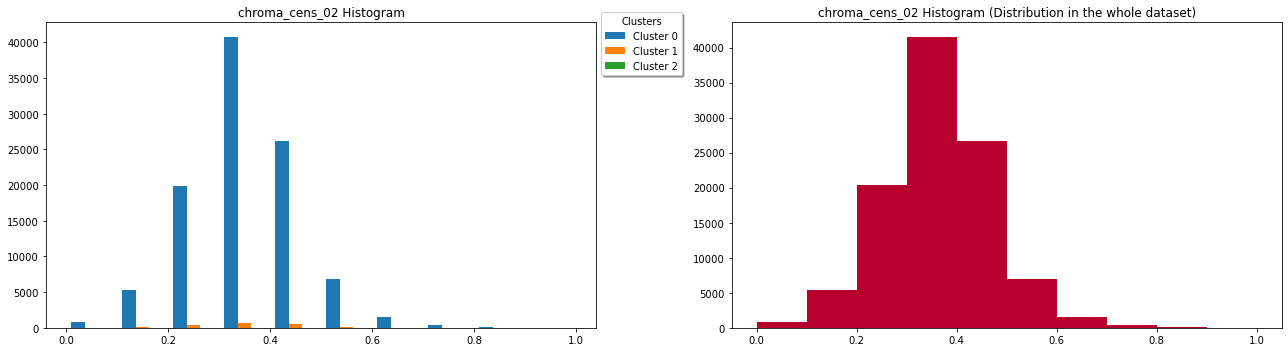

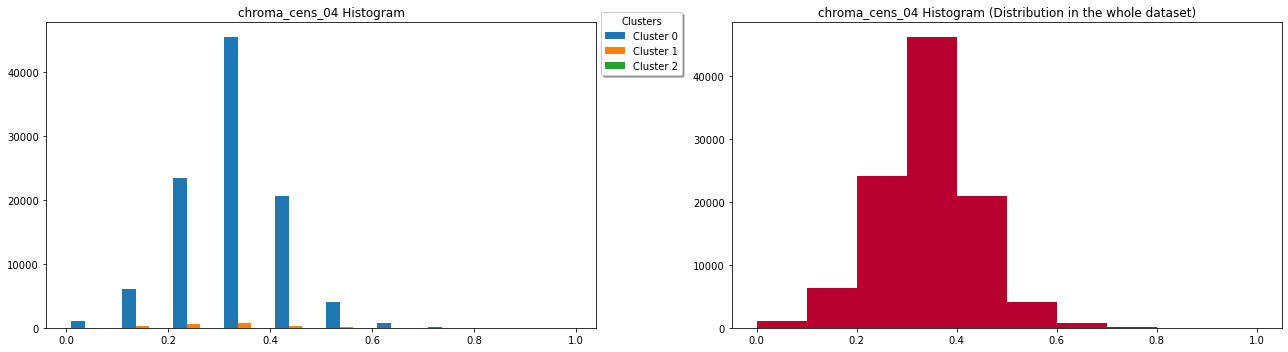

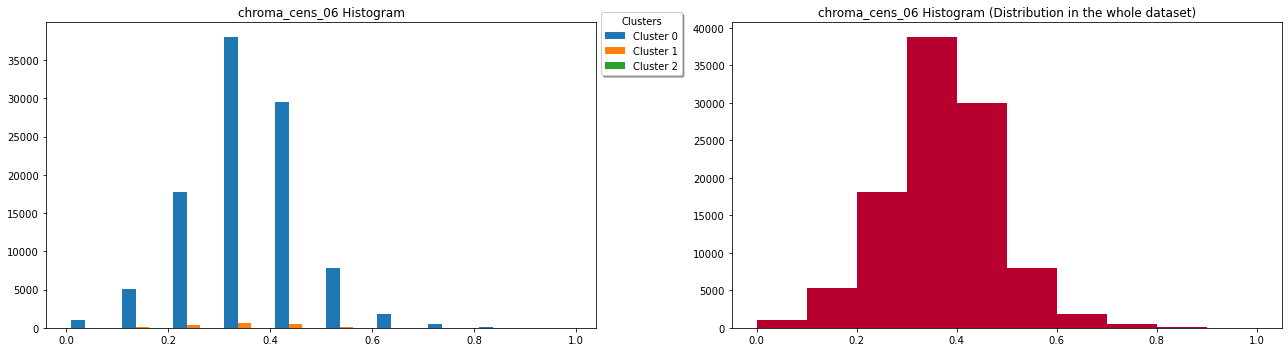

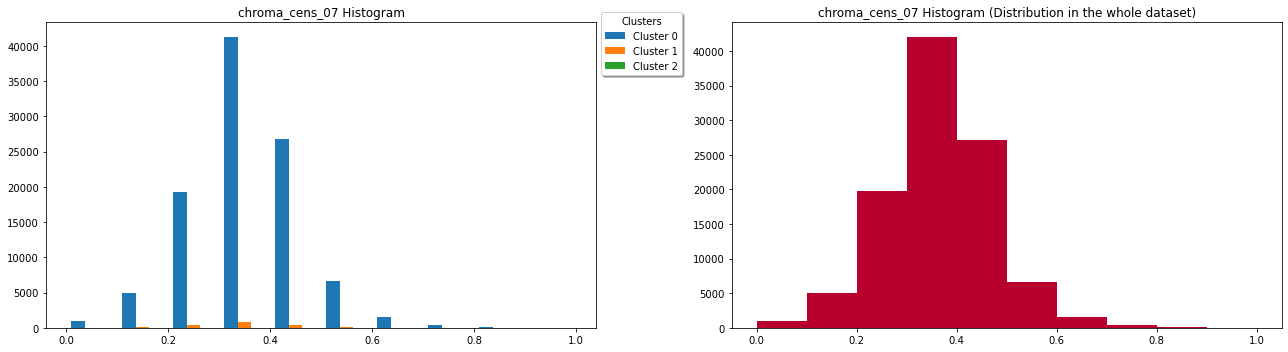

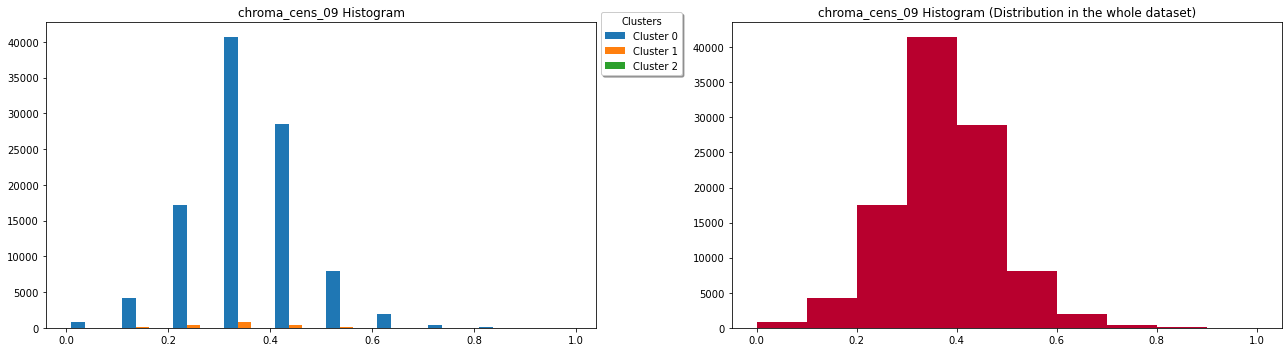

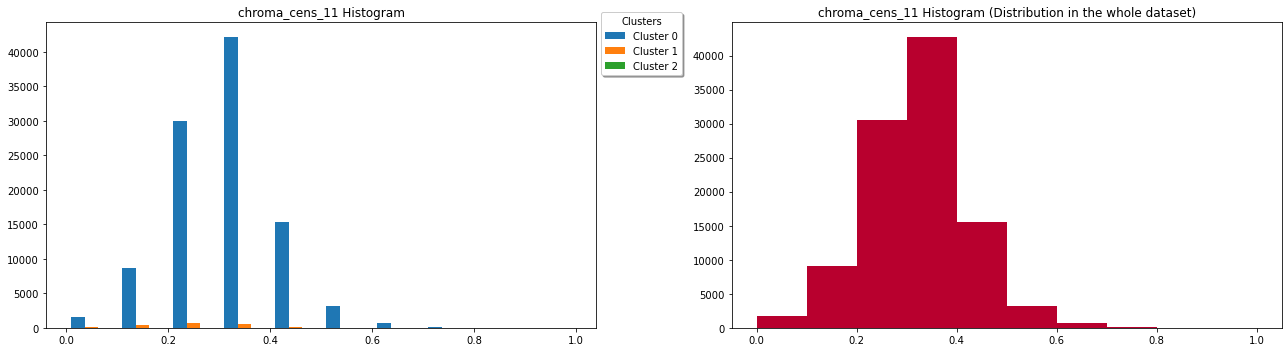

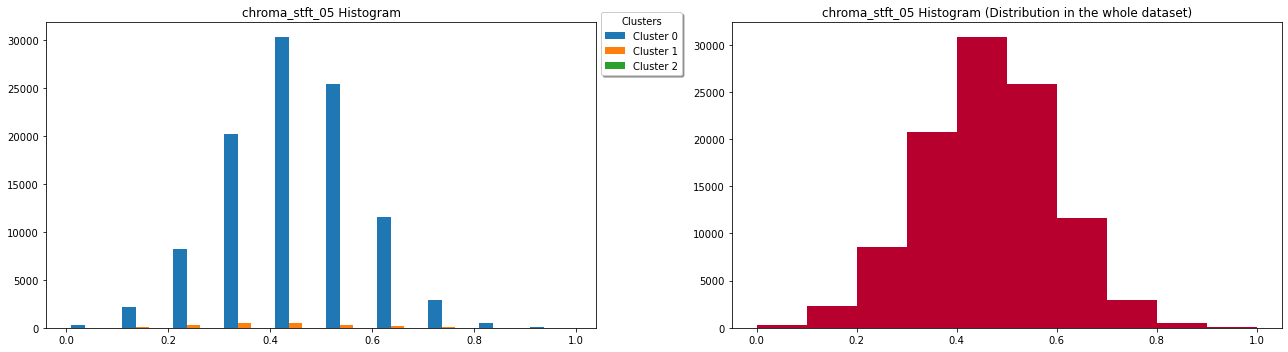

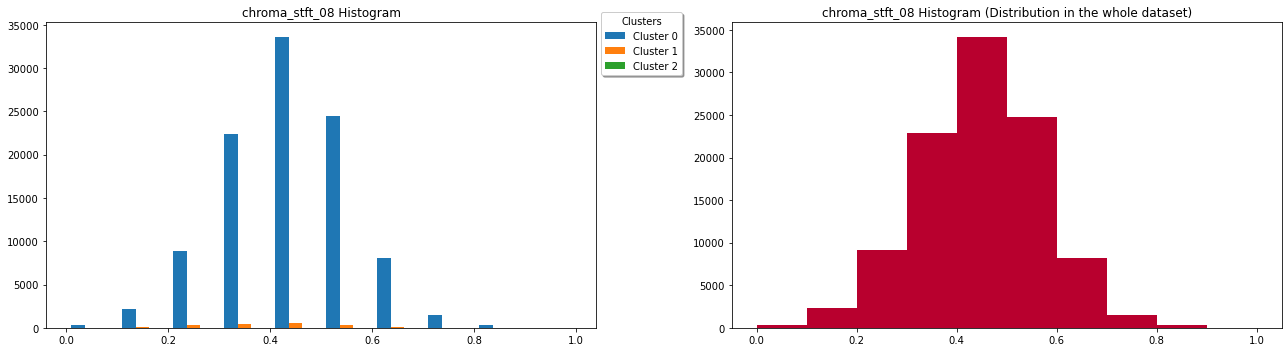

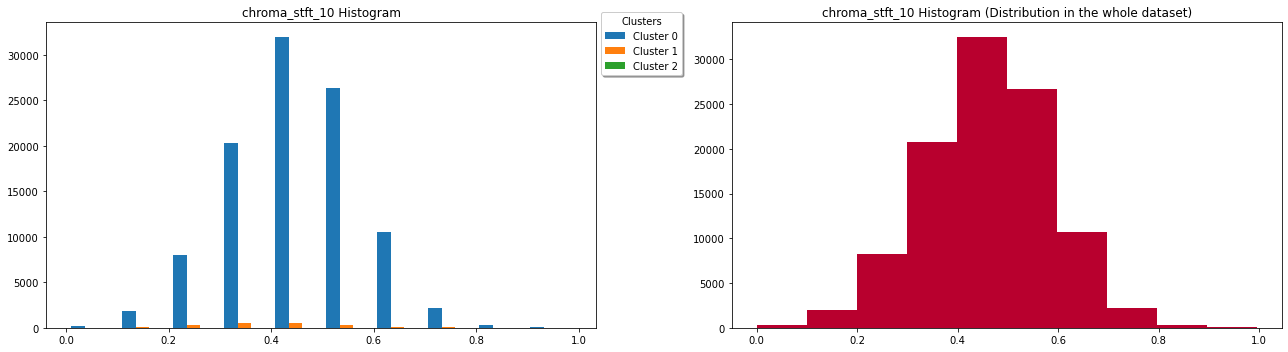

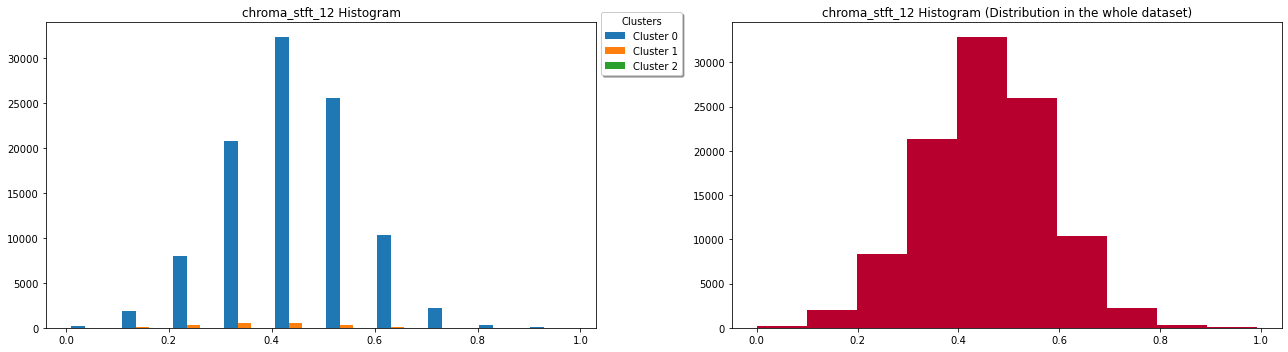

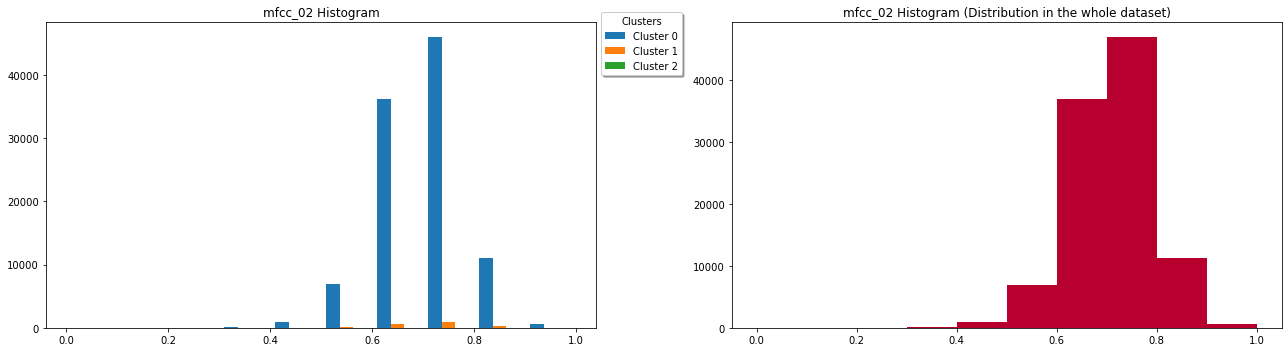

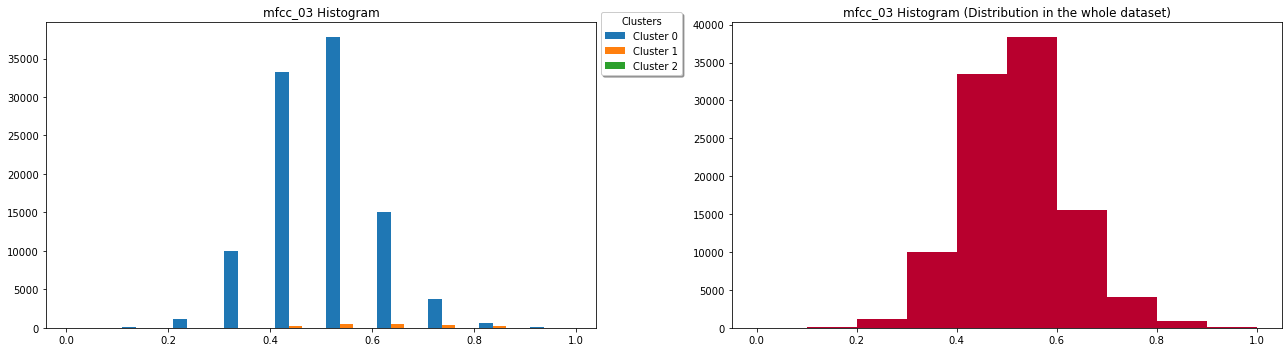

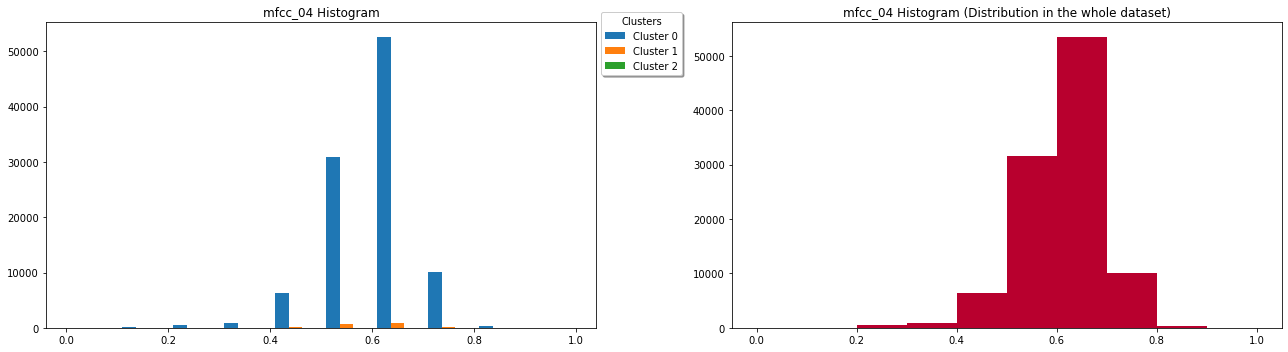

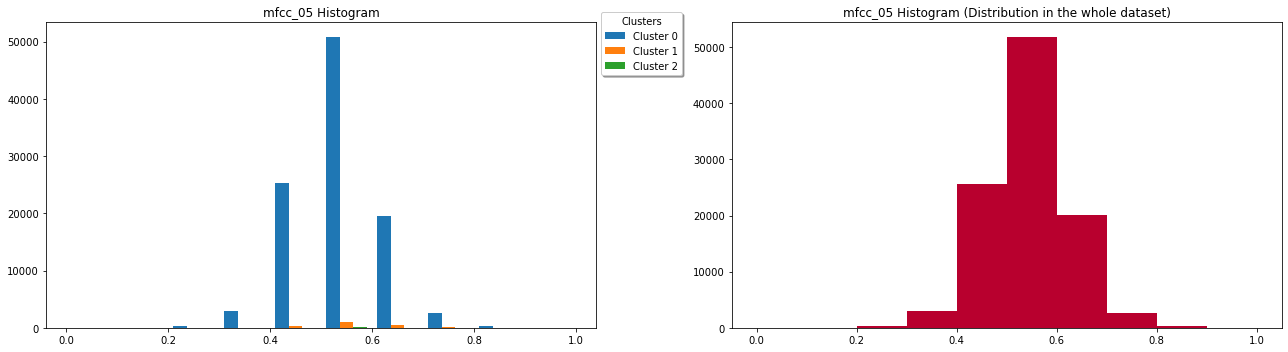

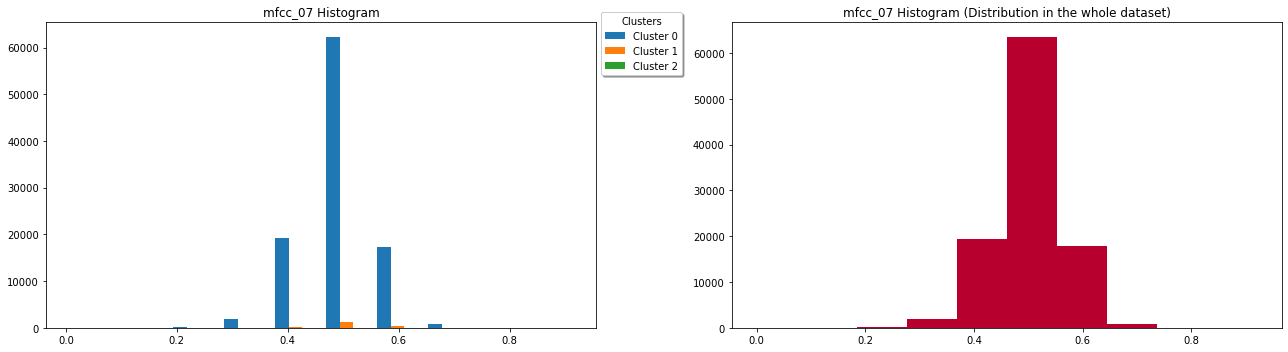

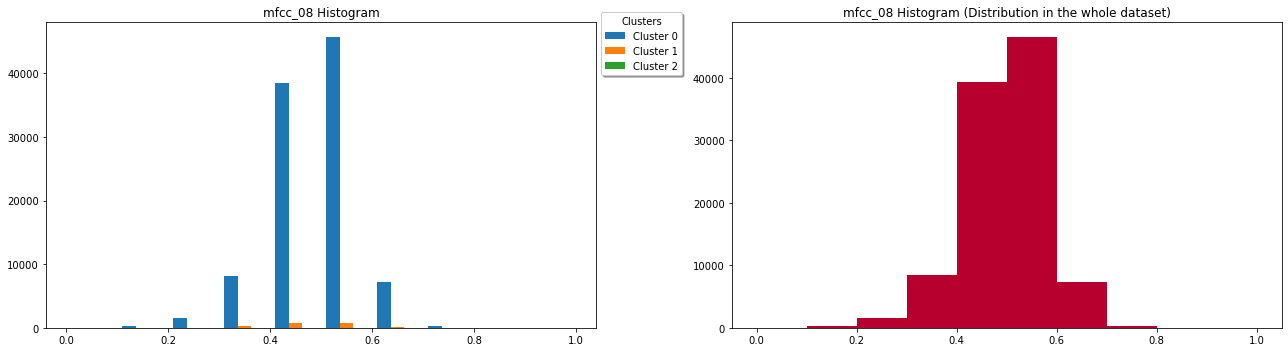

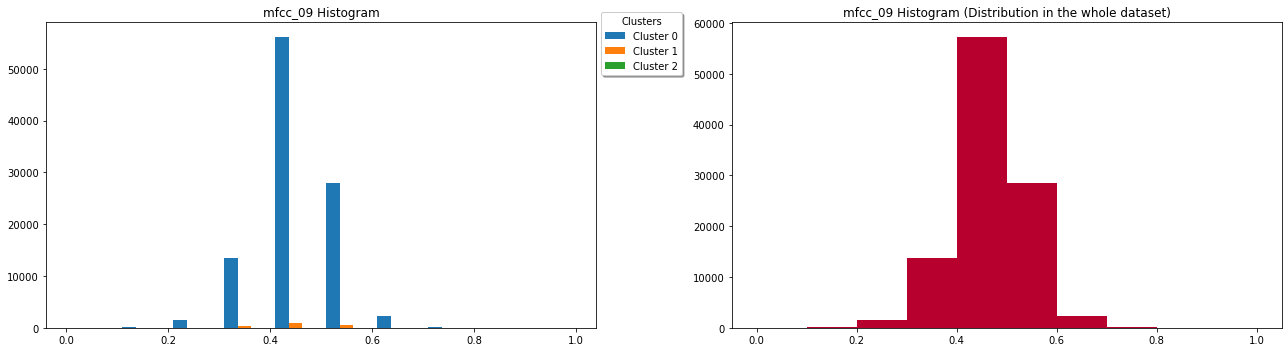

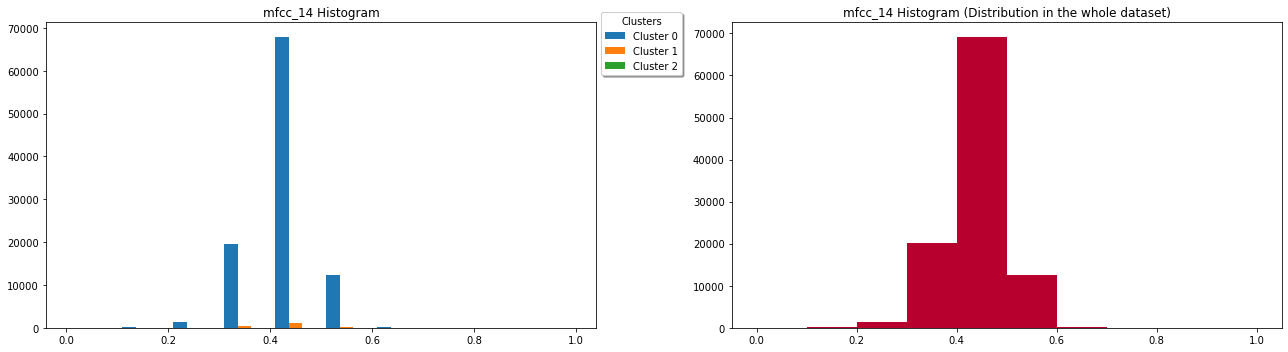

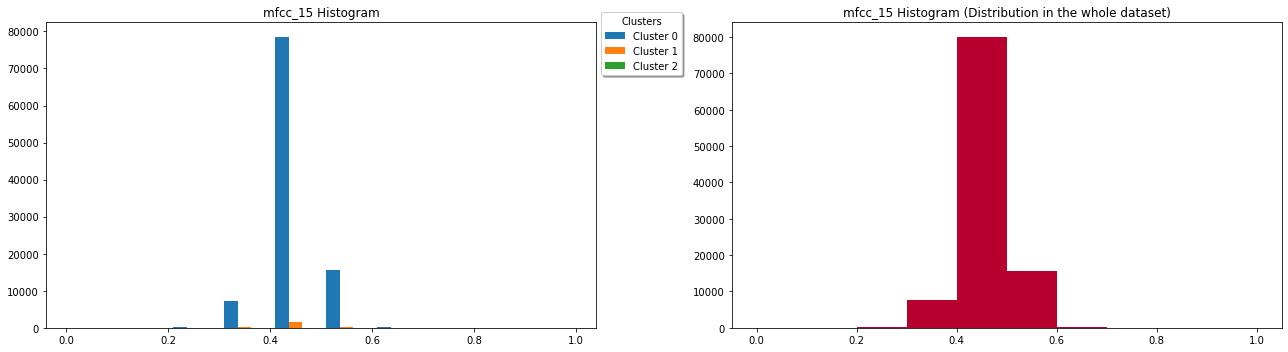

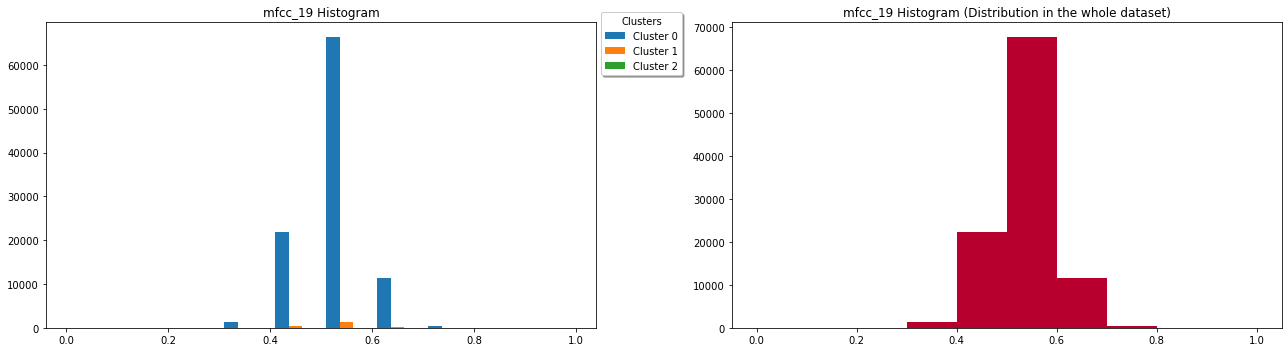

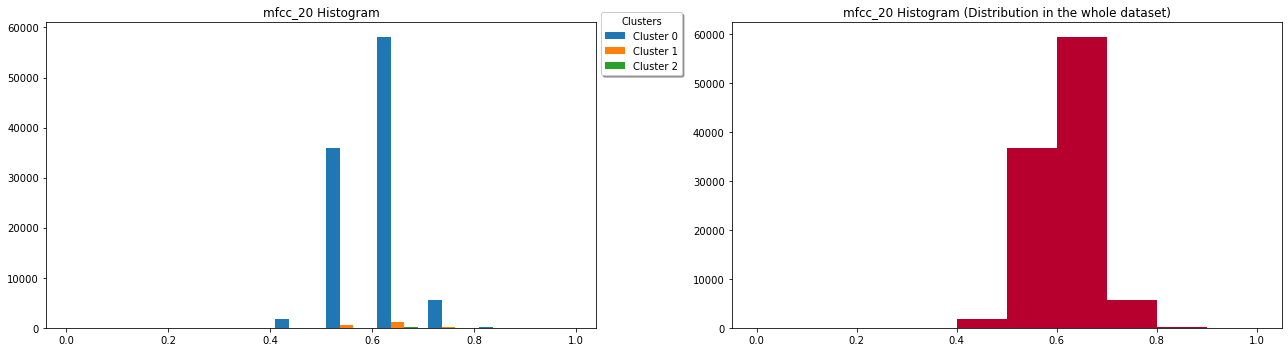

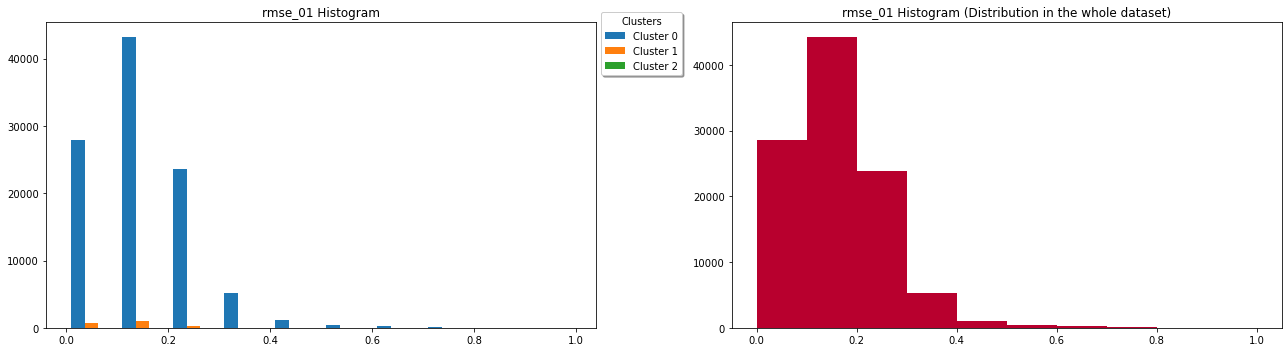

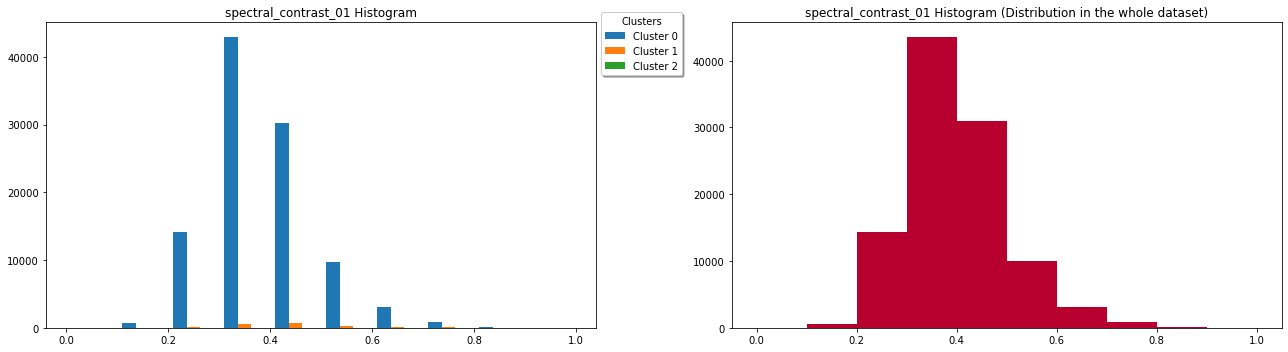

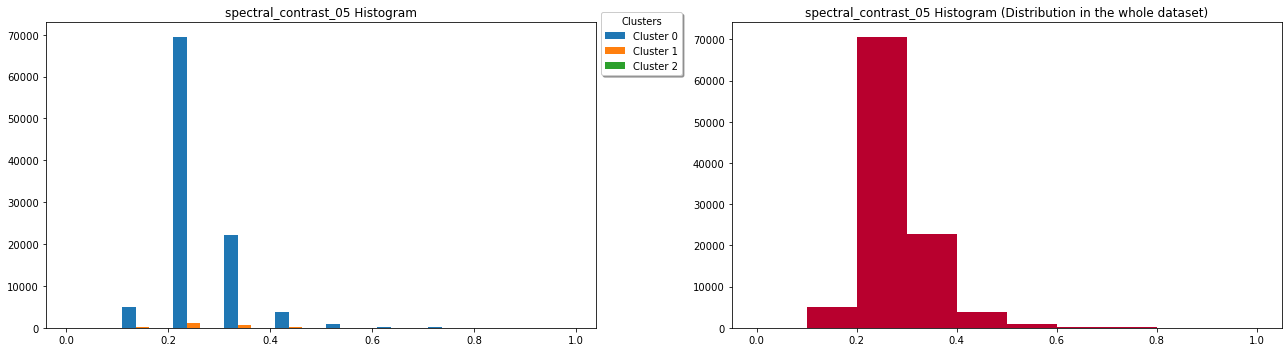

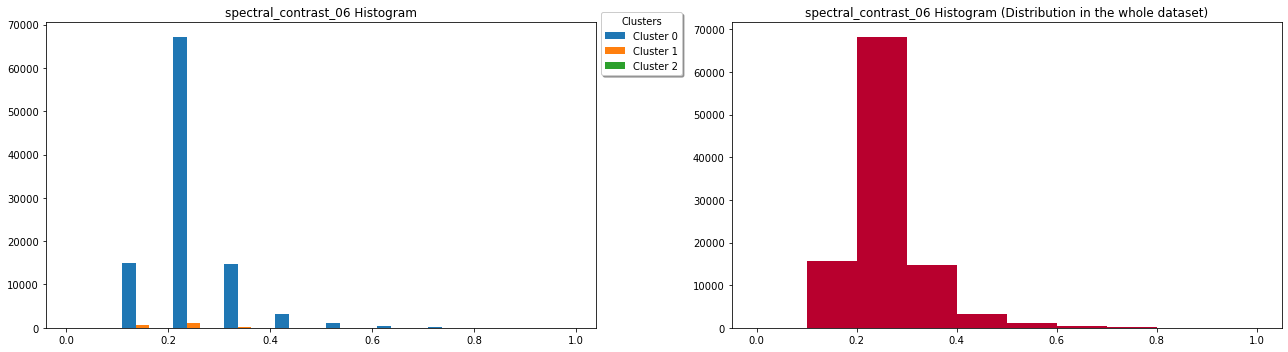

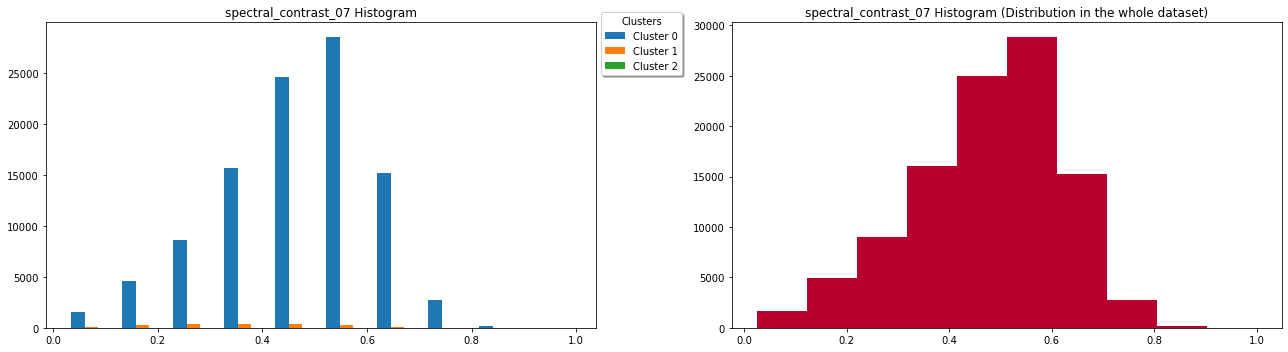

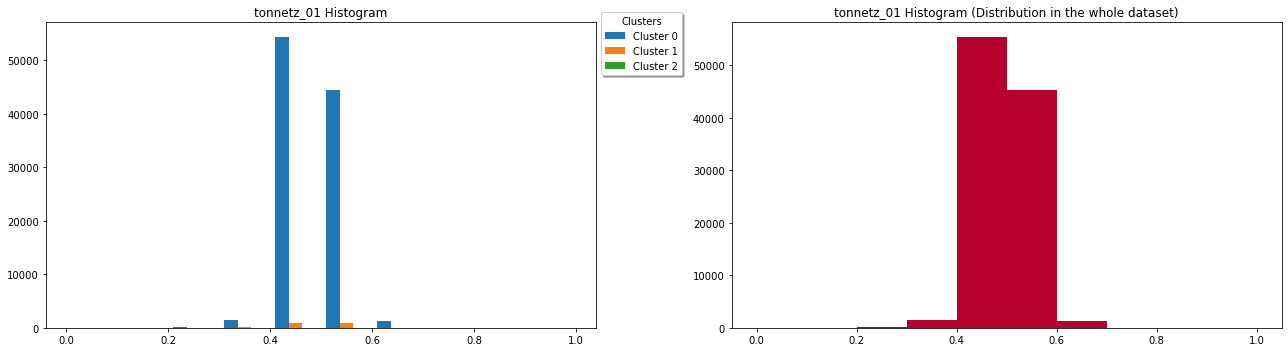

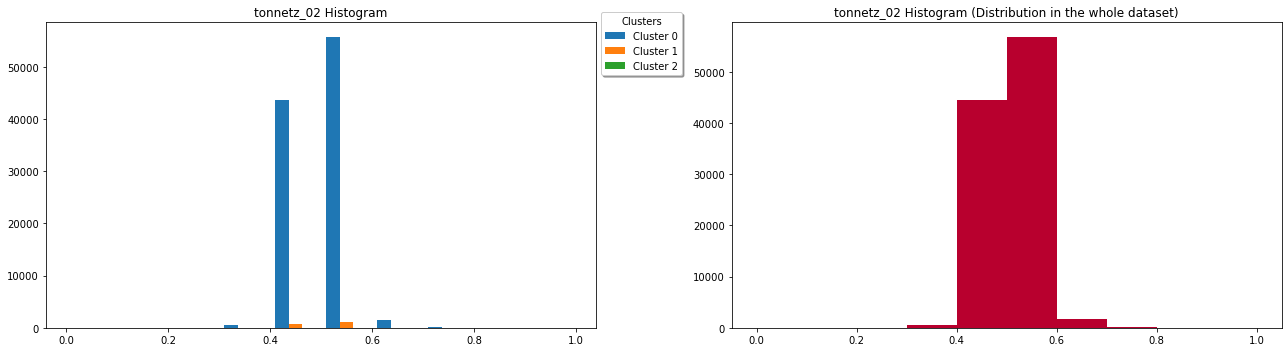

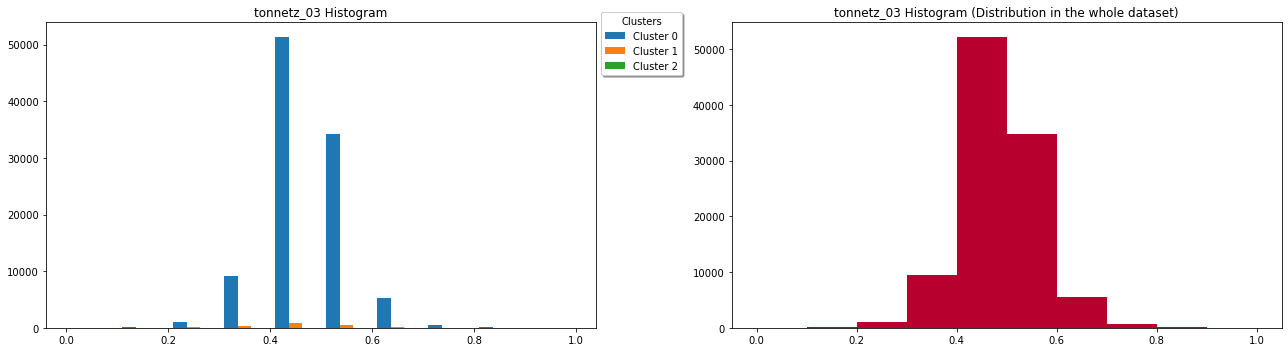

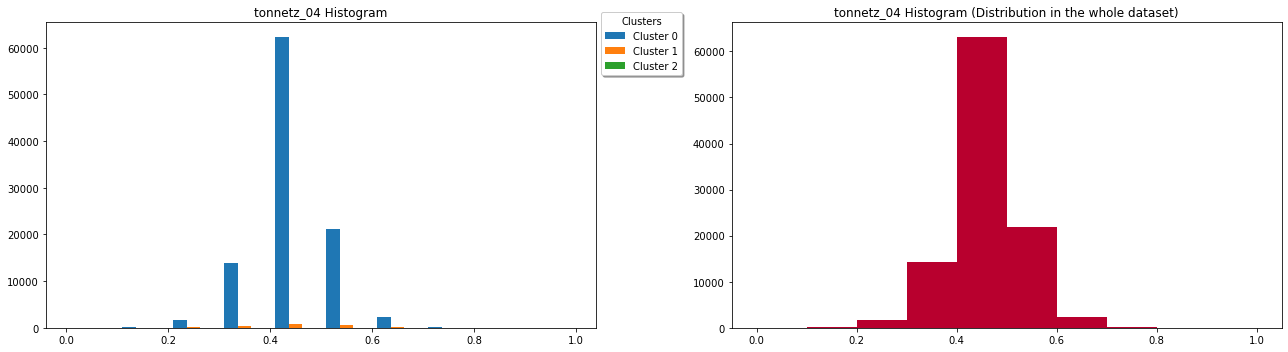

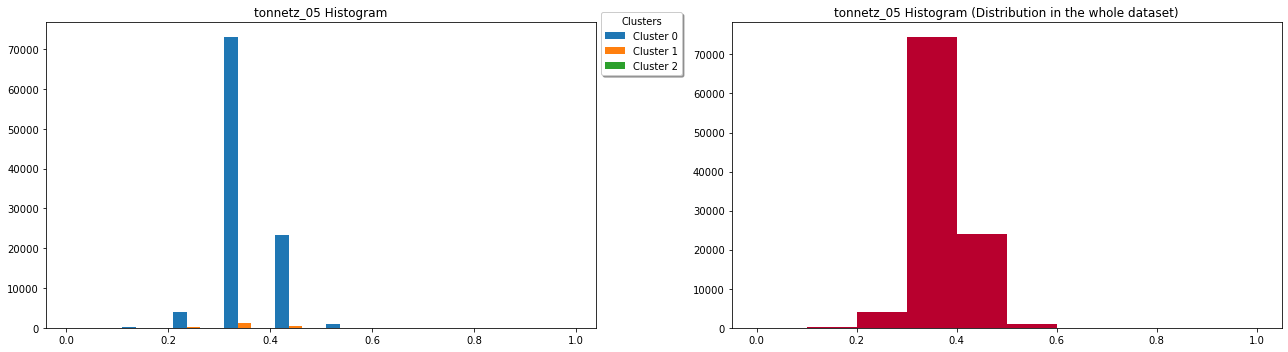

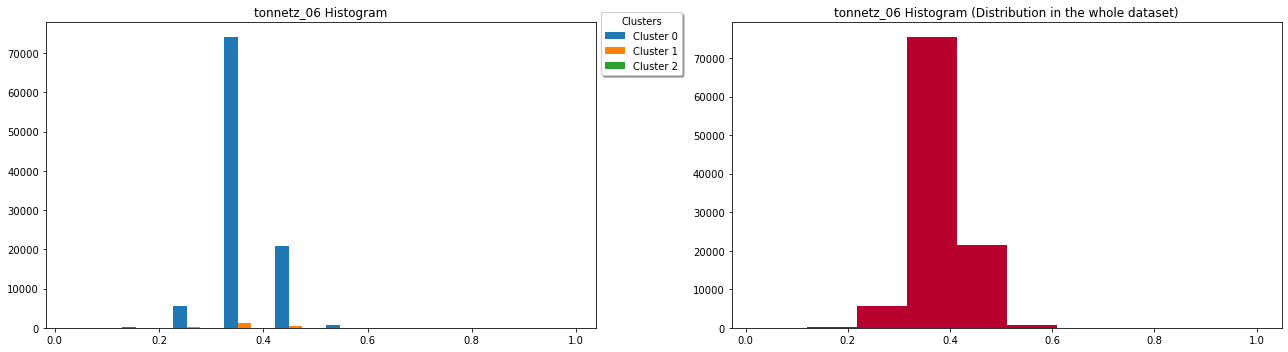

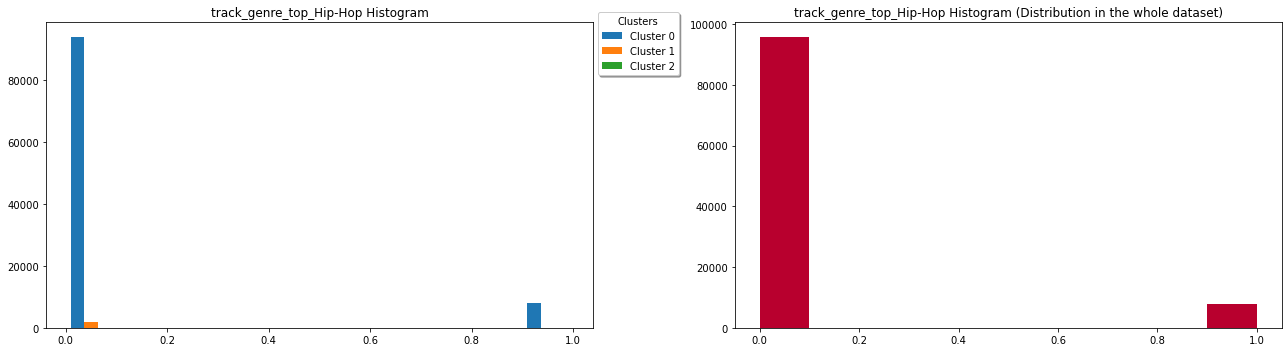

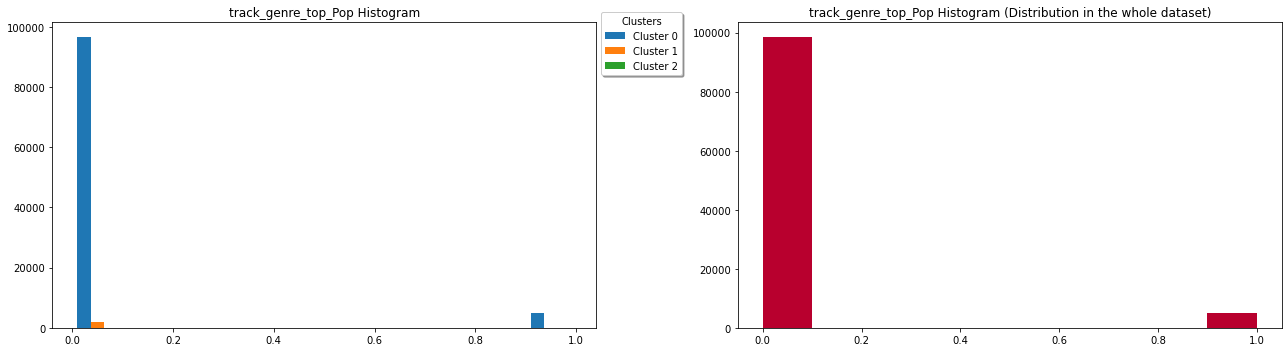

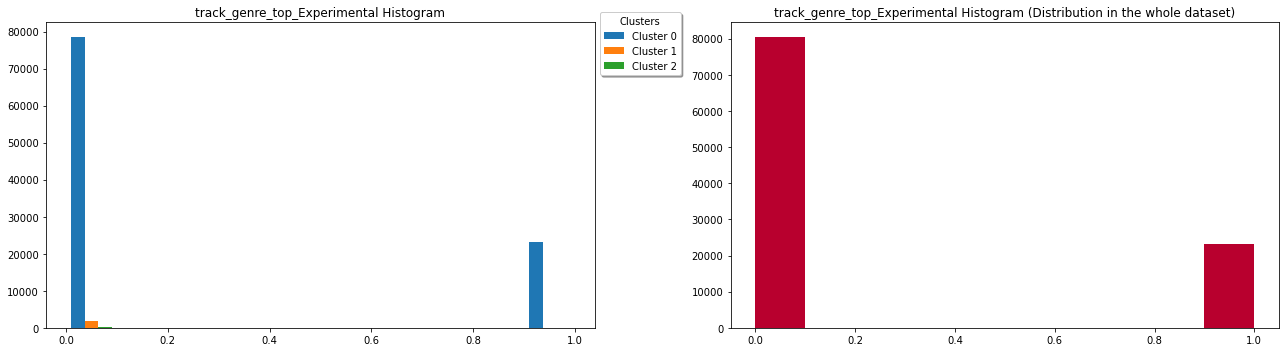

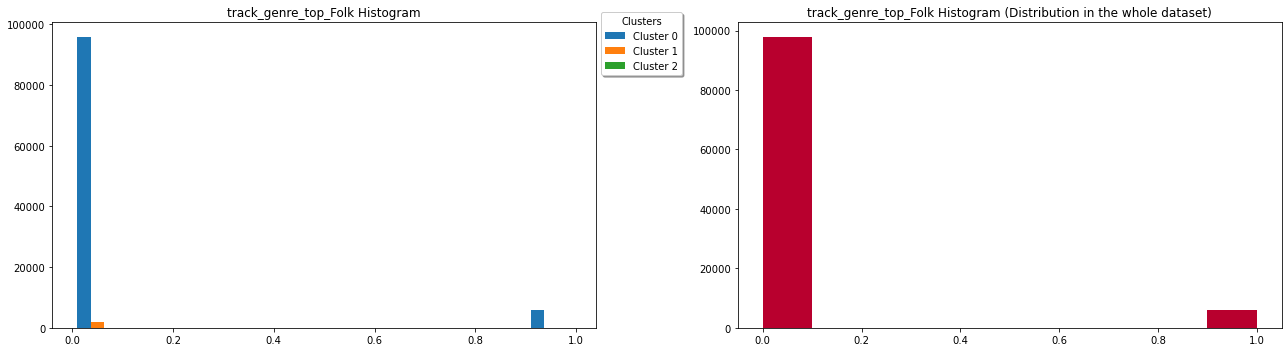

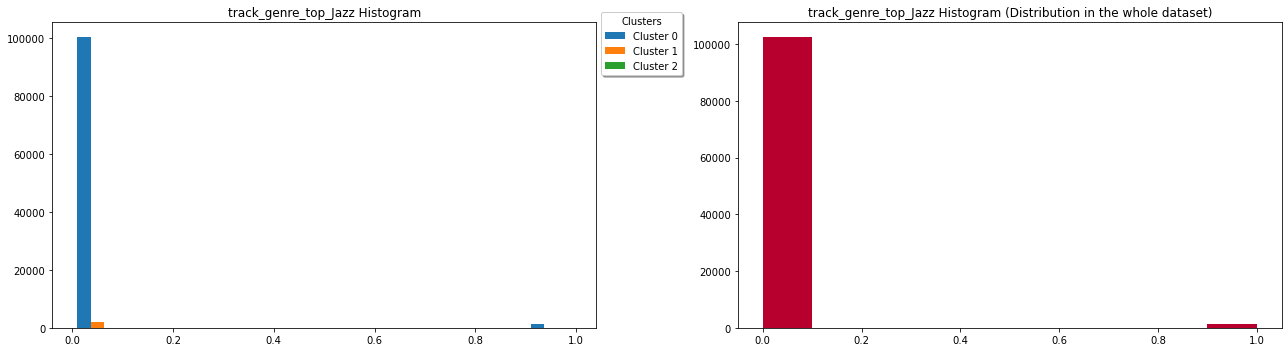

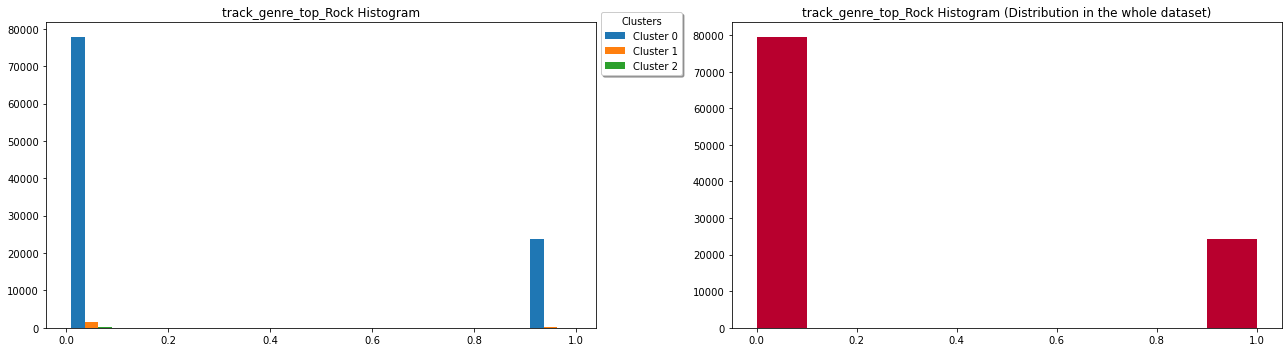

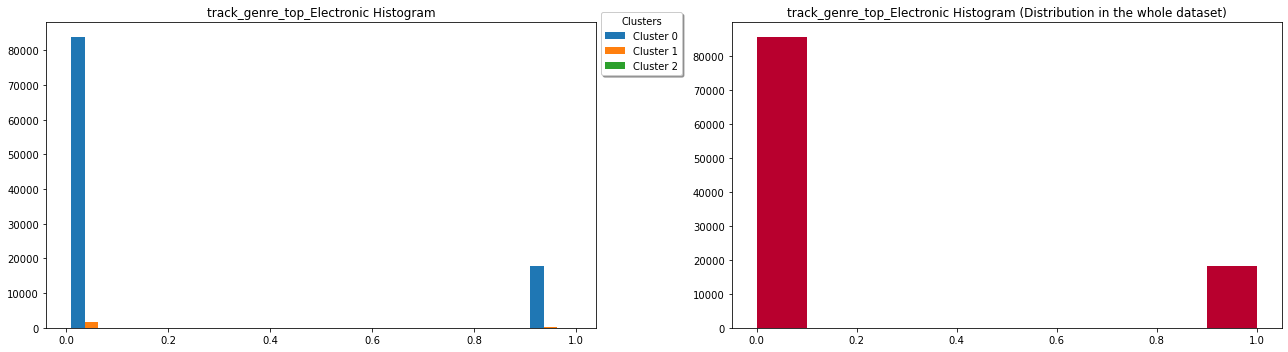

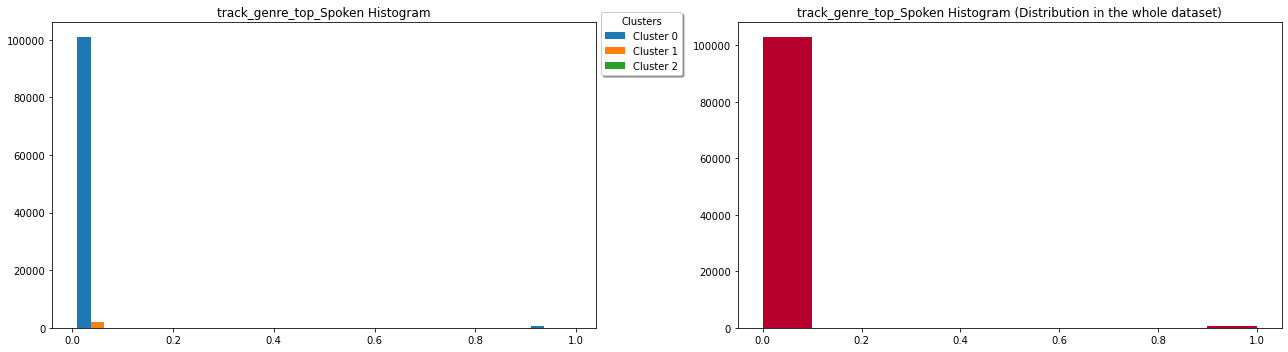

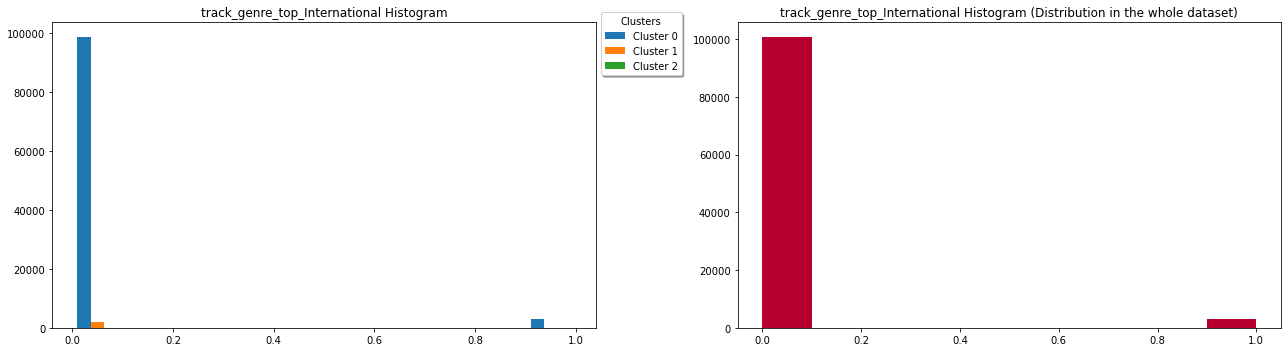

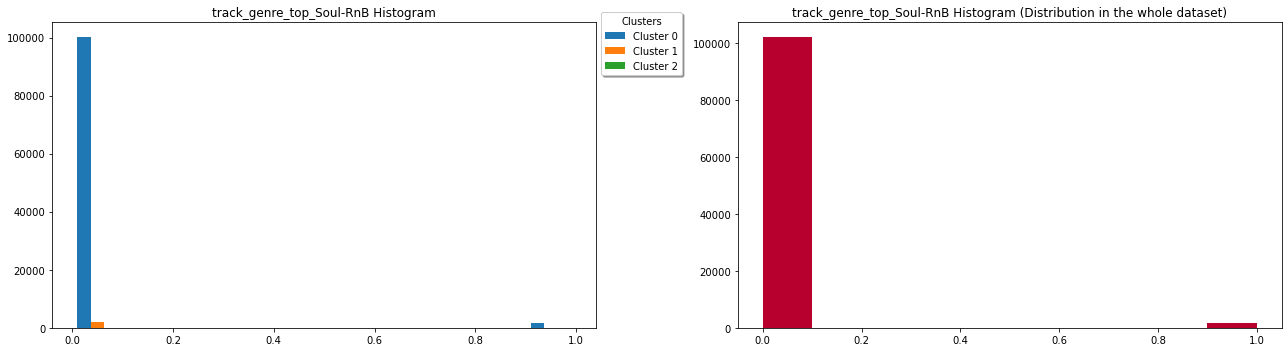

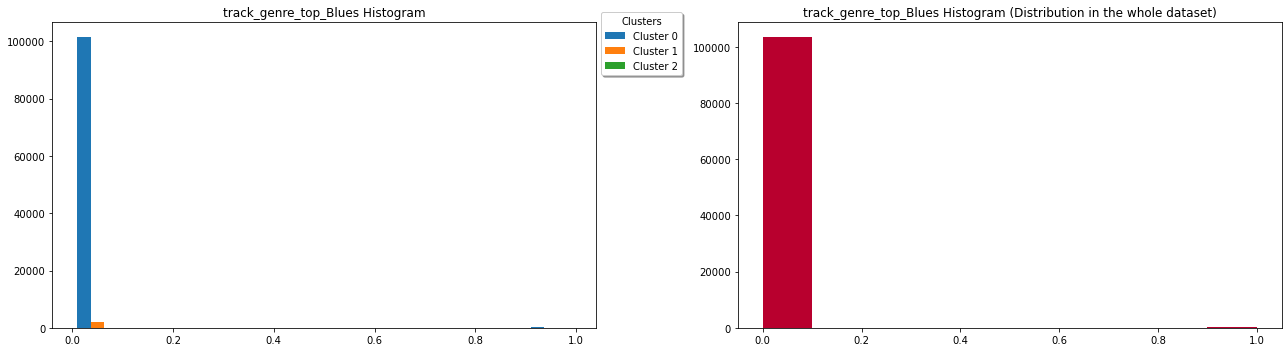

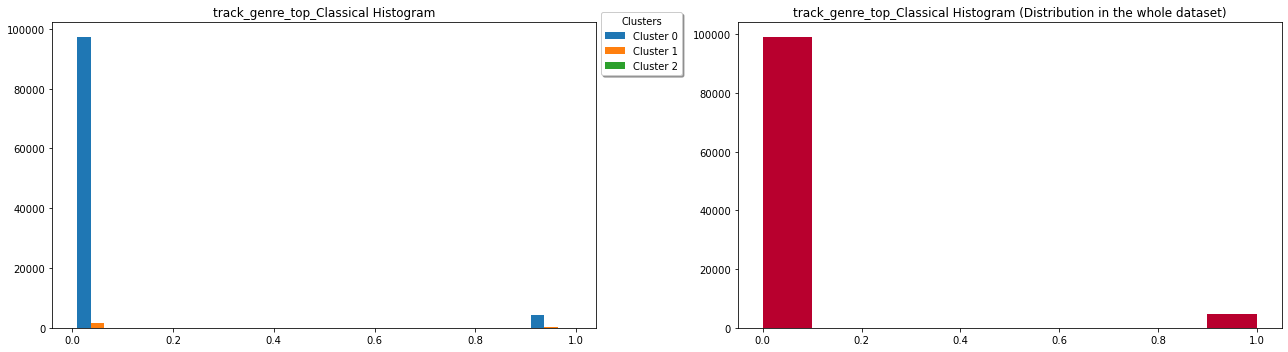

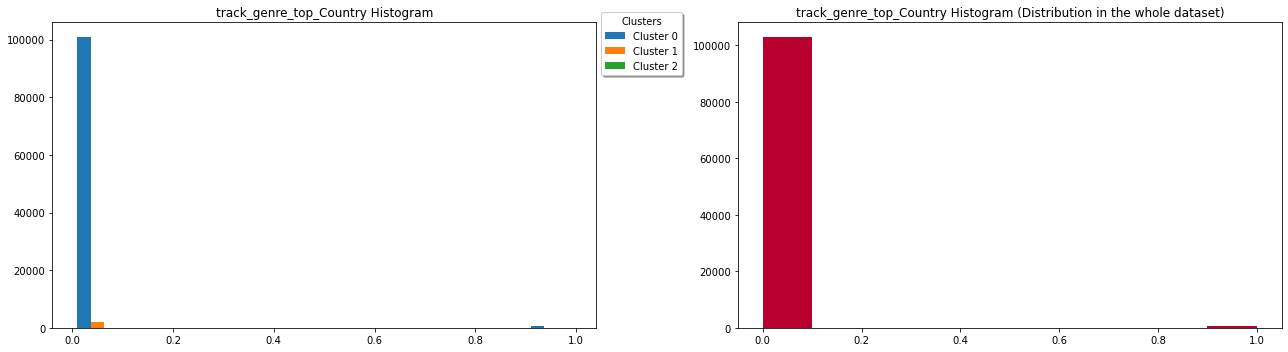

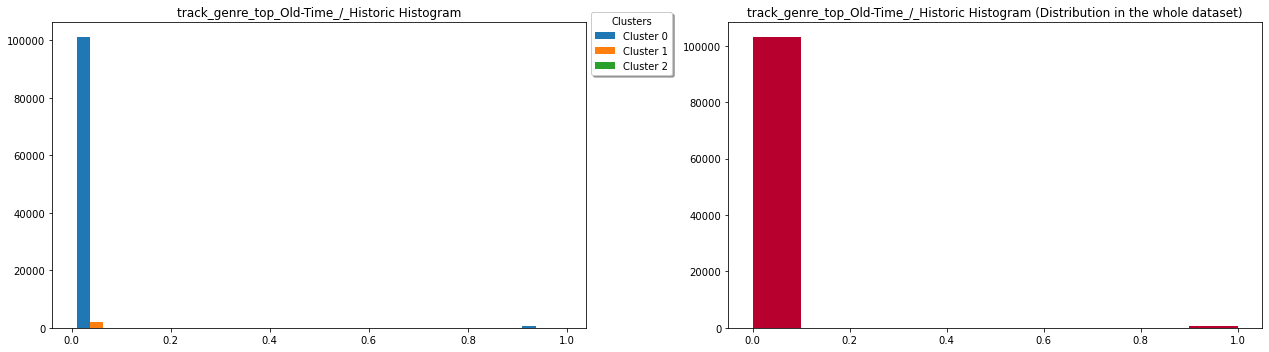

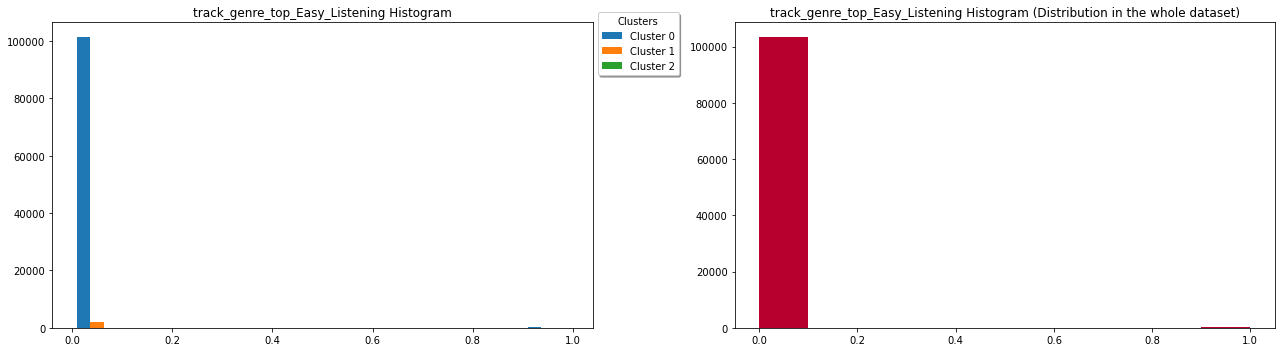

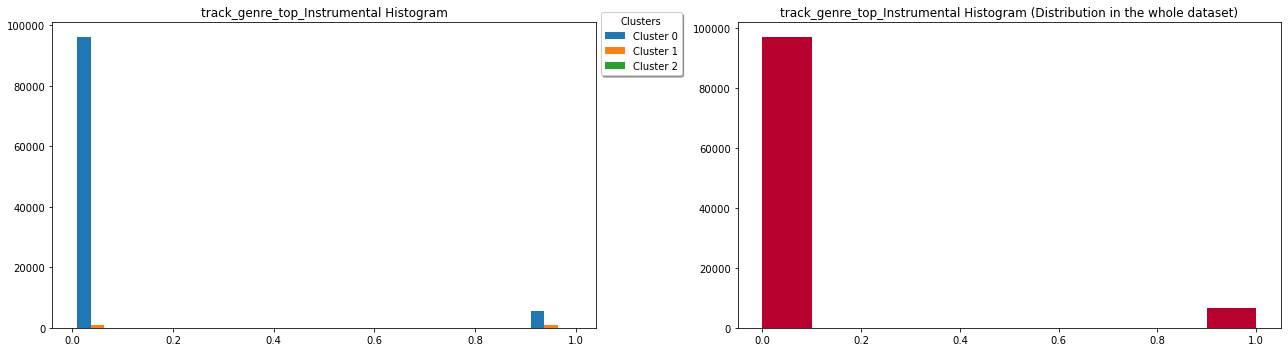

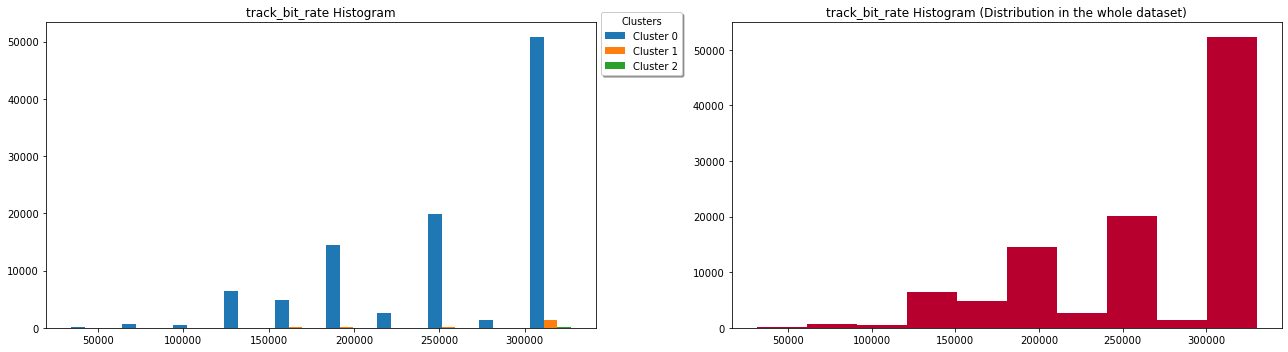

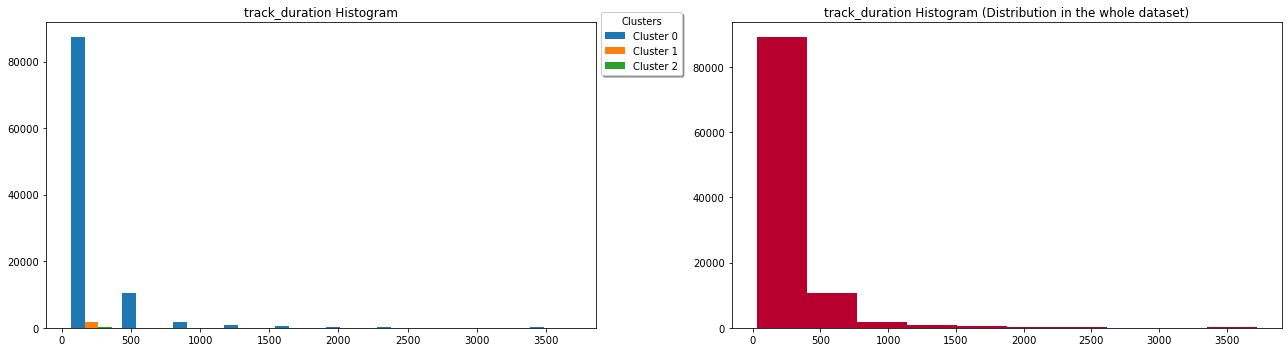

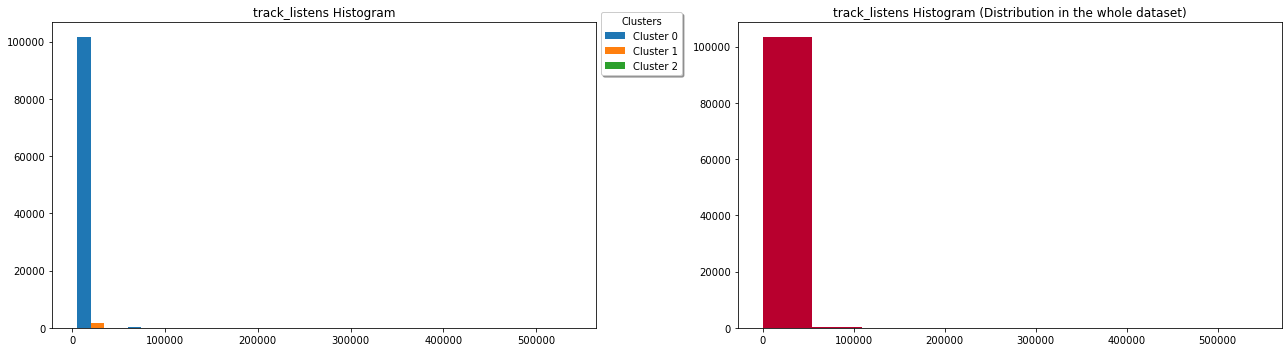

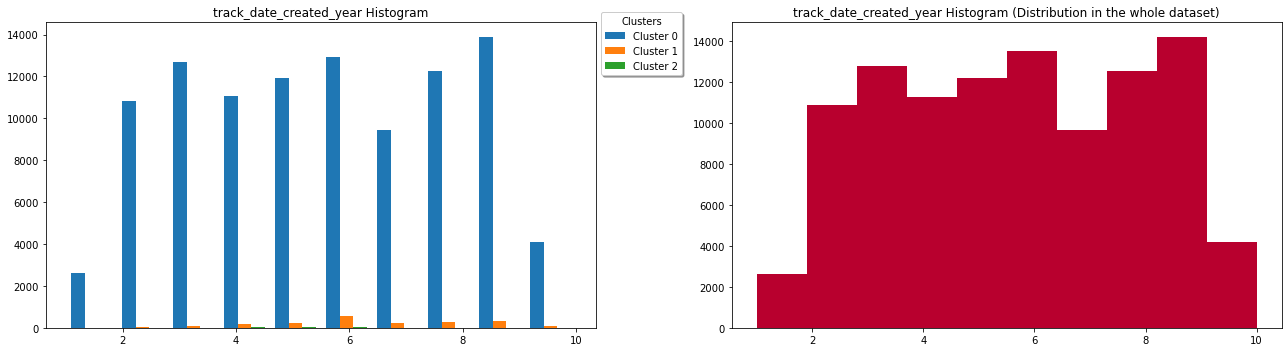

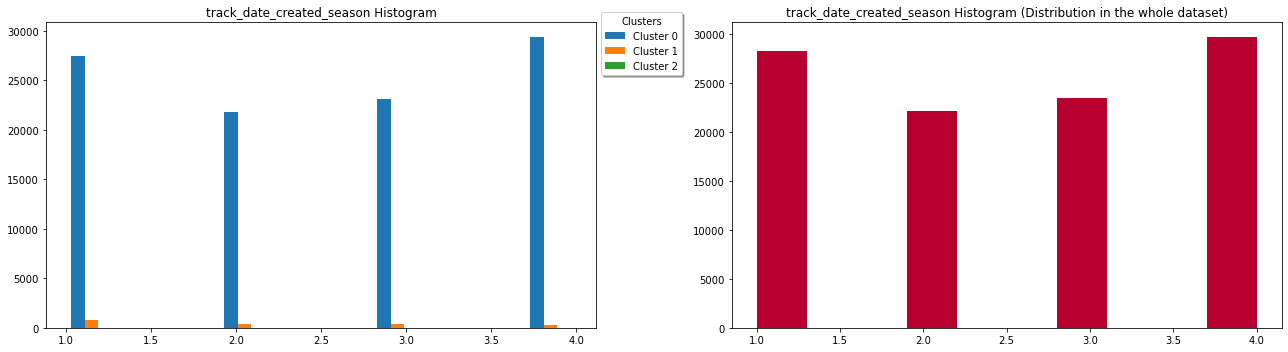

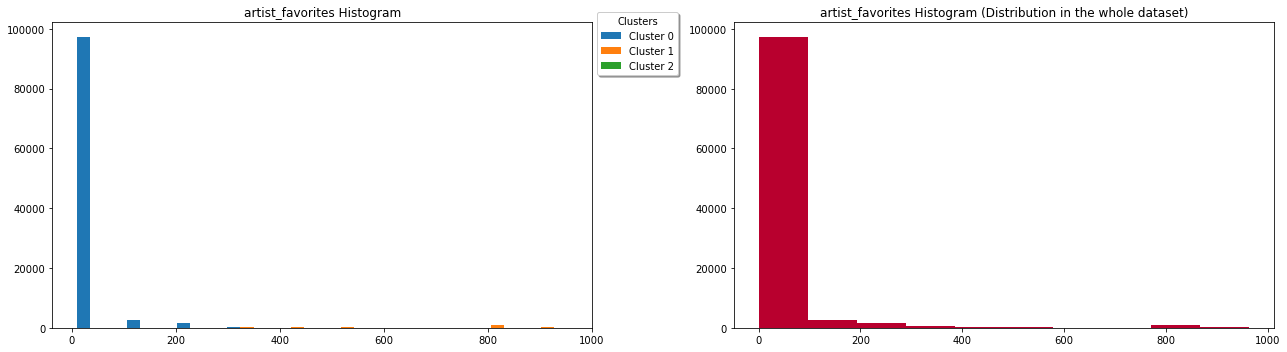

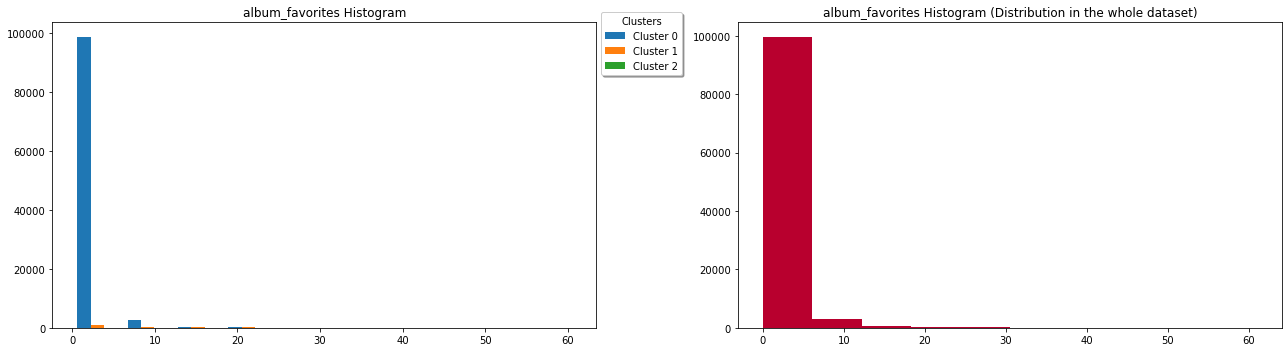

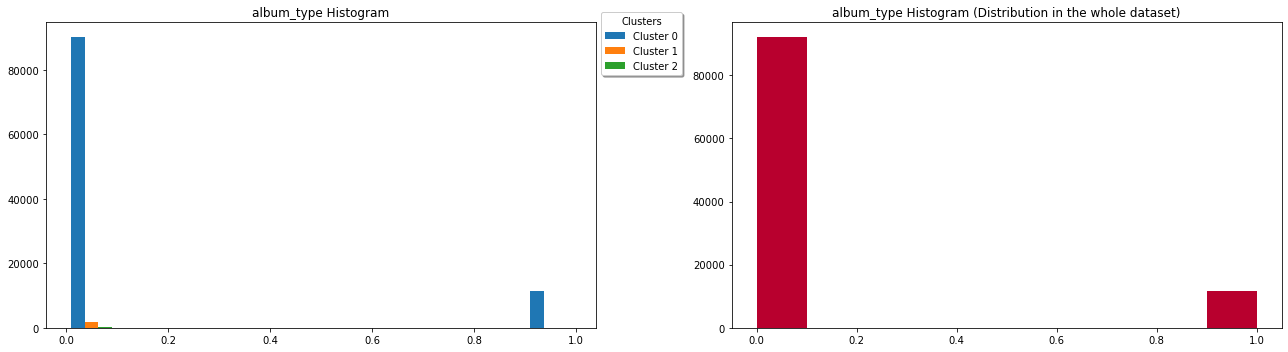

In [72]:
plot_general_distributions(df_complete_2)

Cluster 0



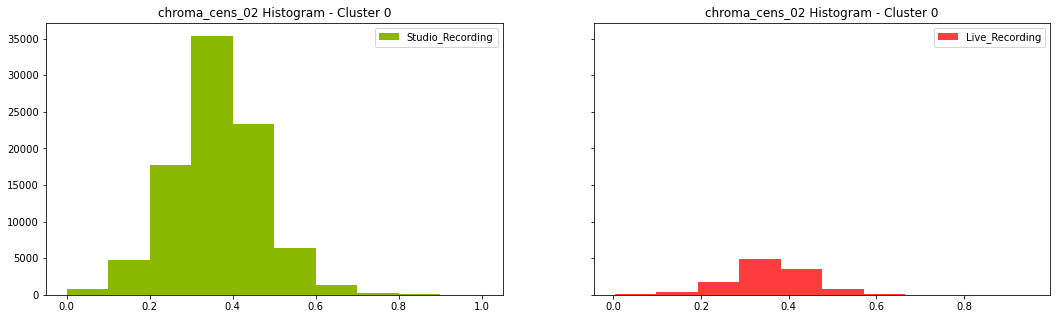

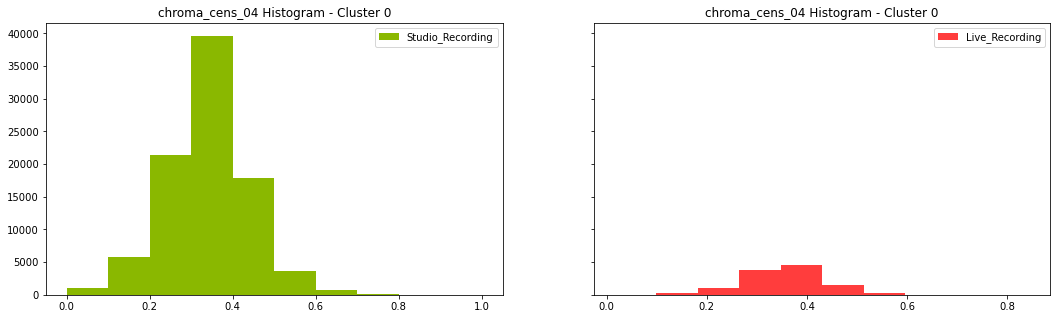

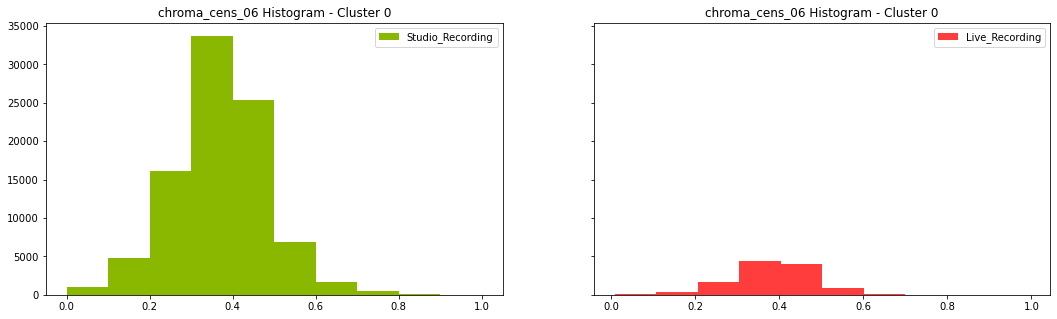

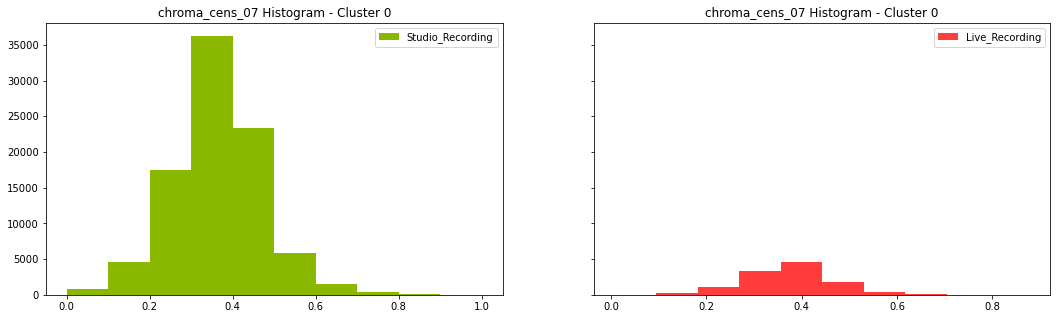

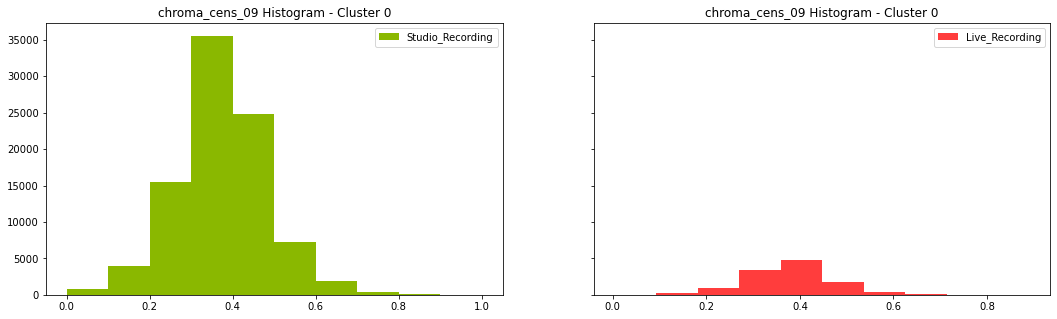

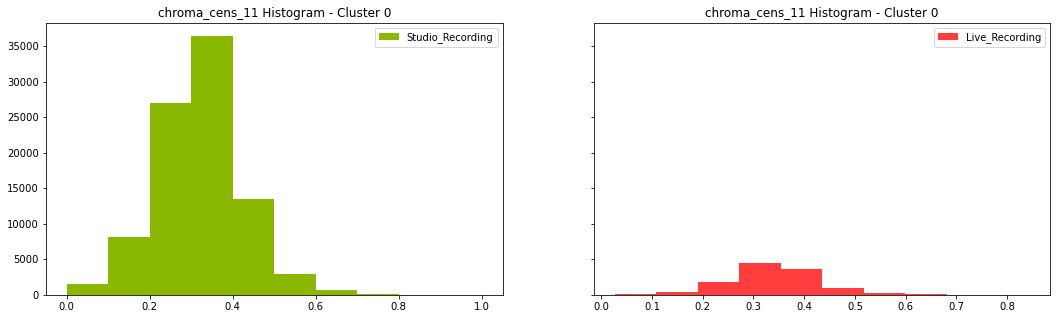

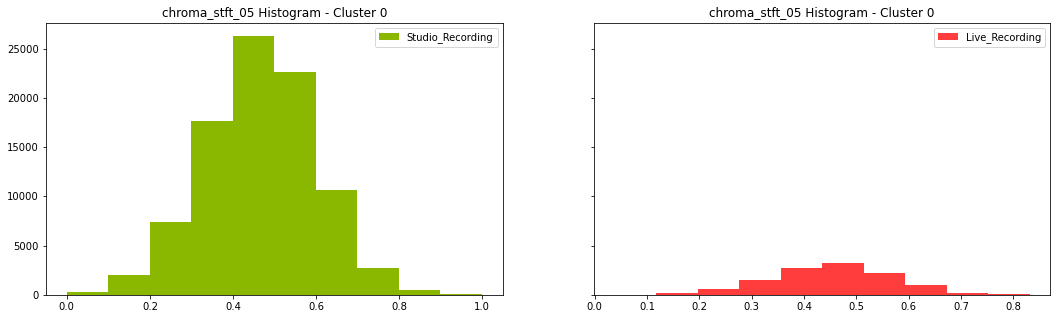

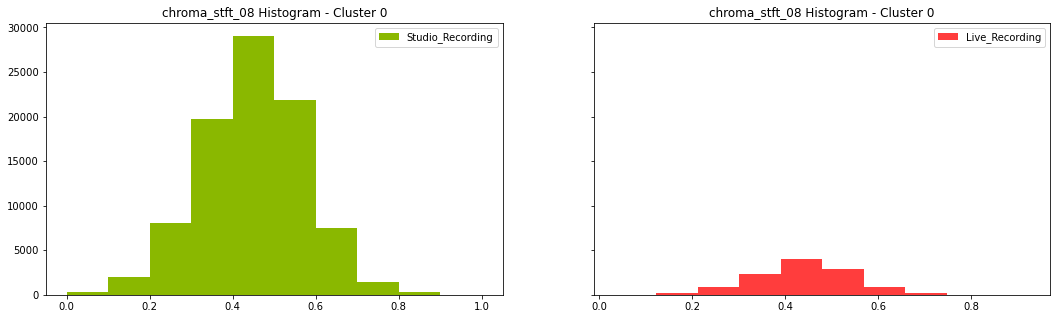

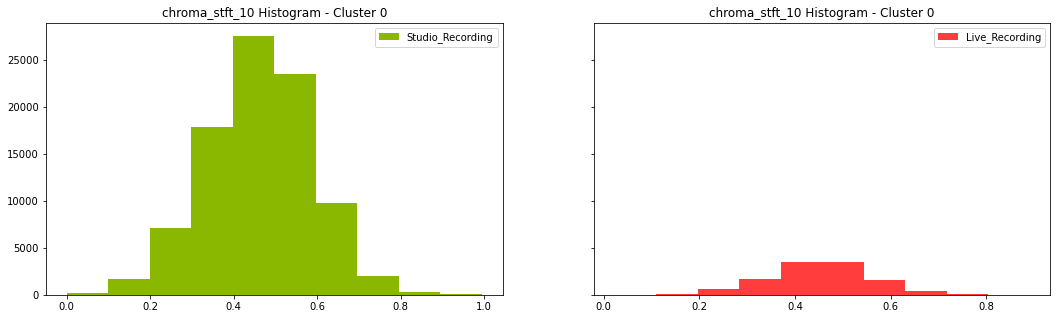

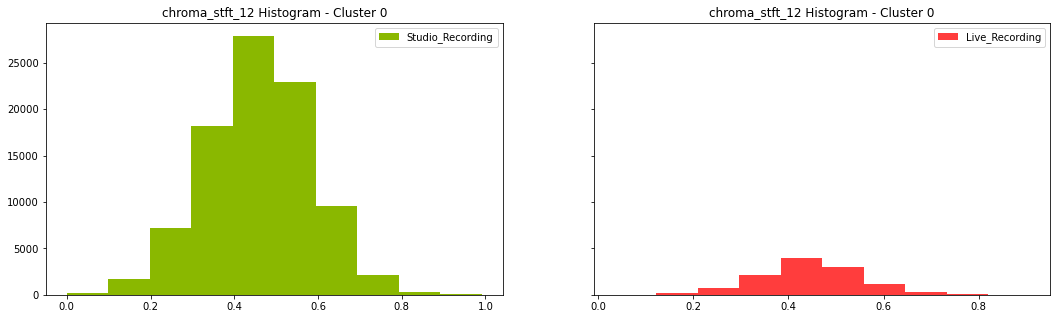

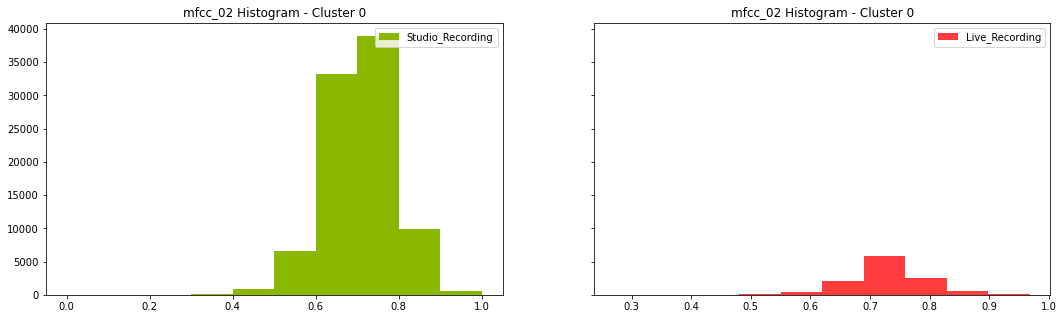

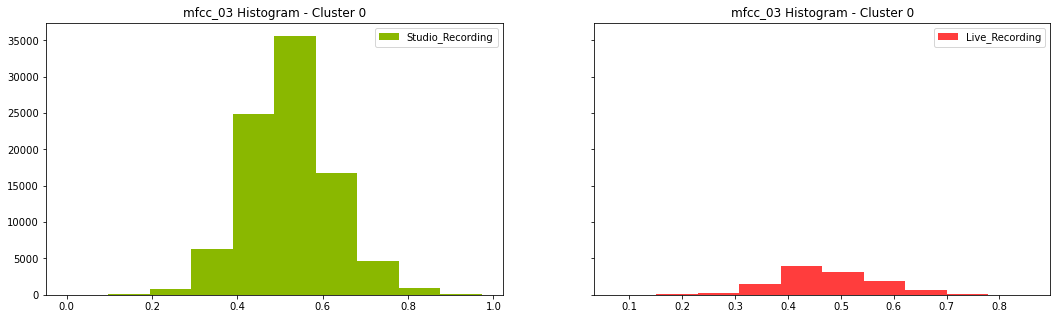

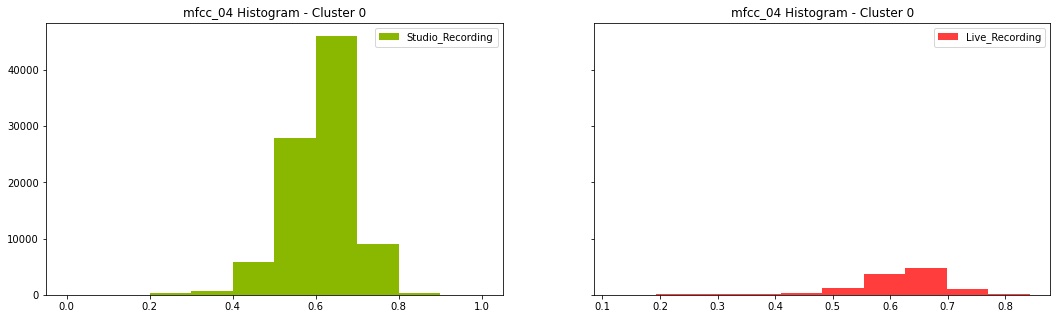

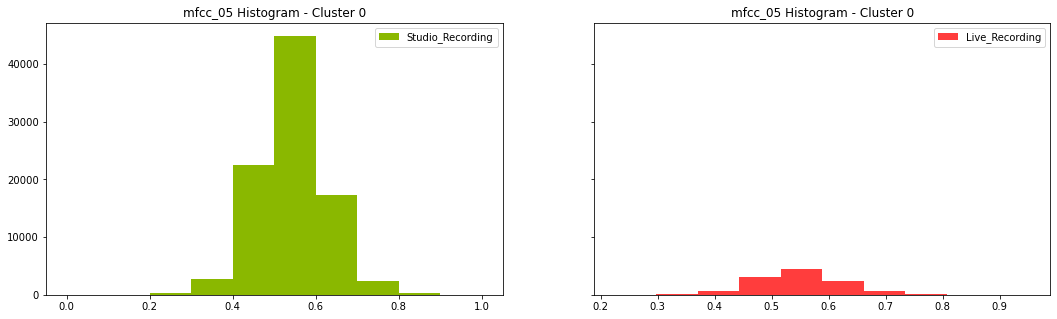

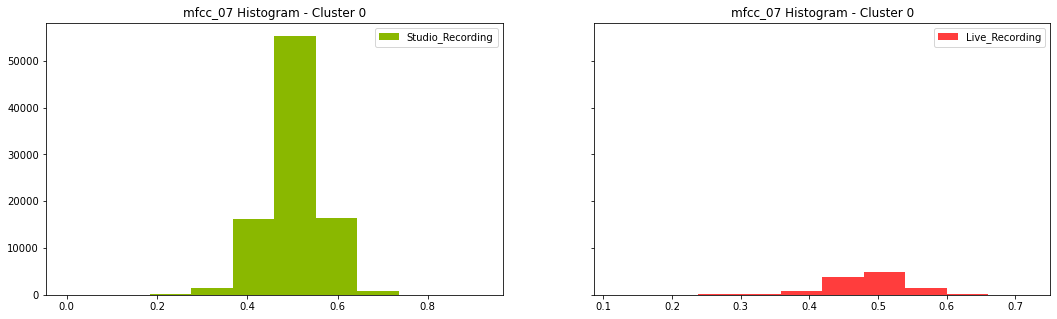

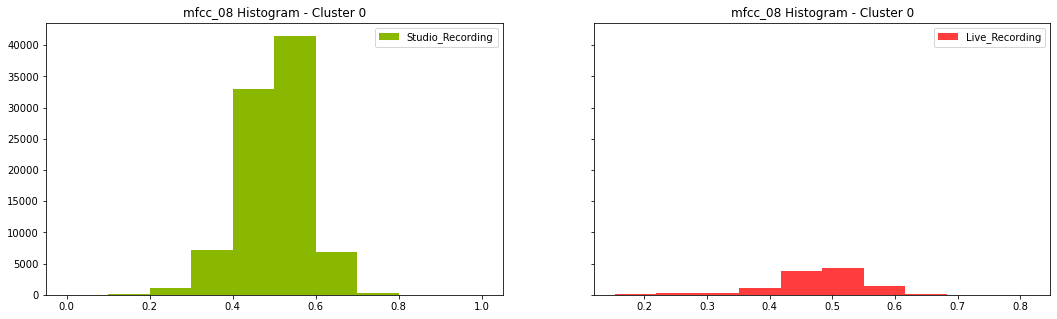

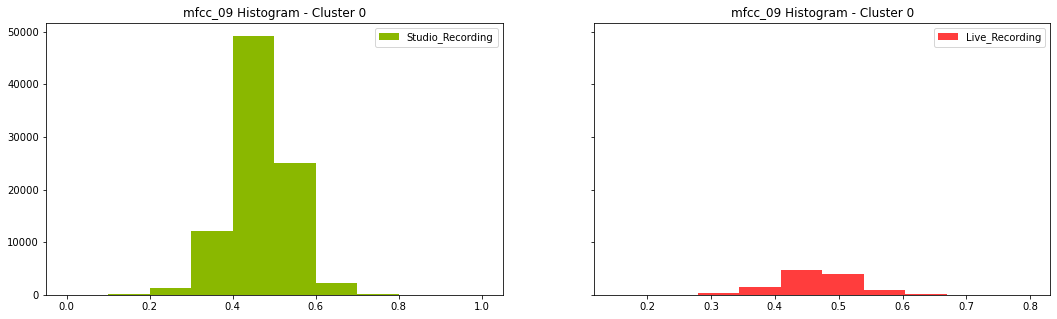

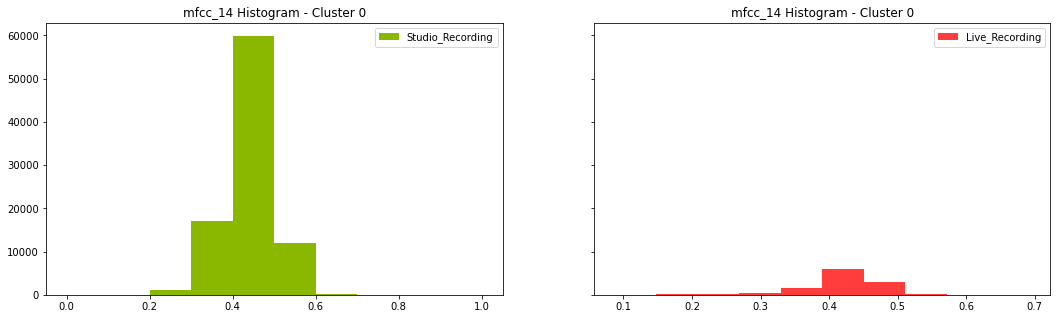

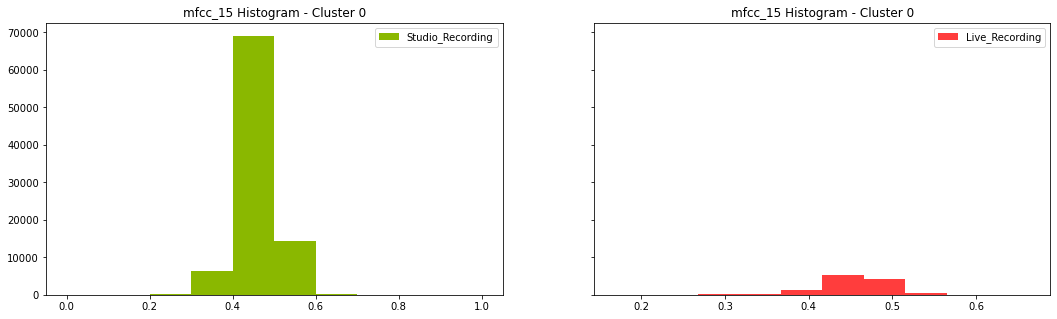

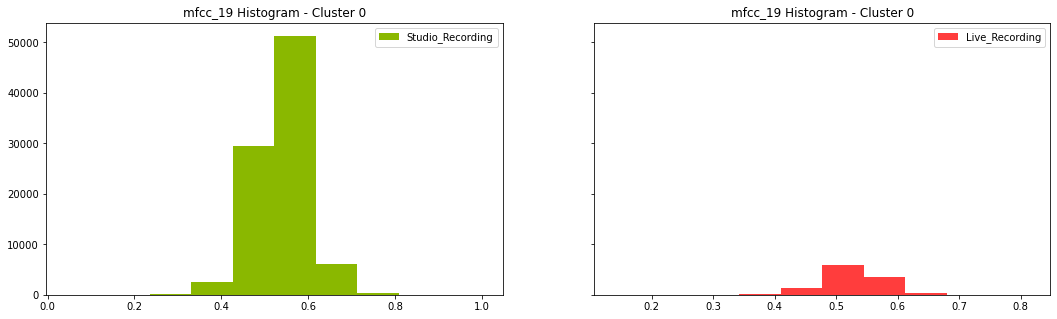

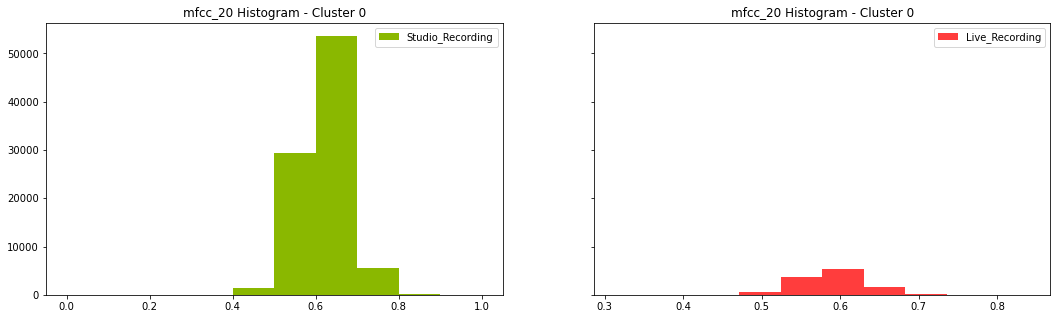

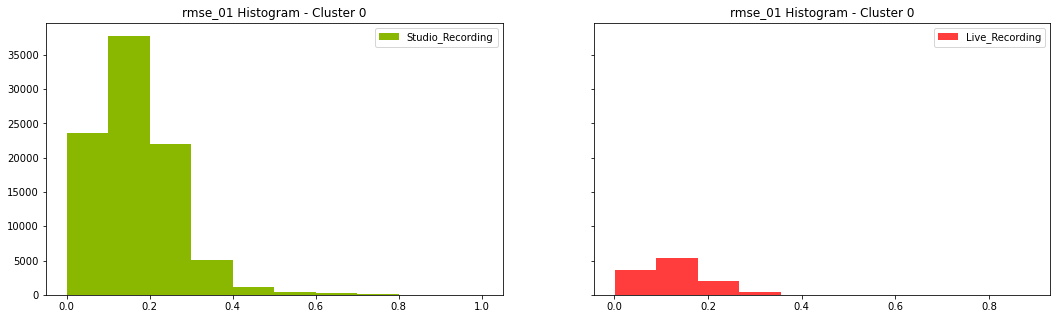

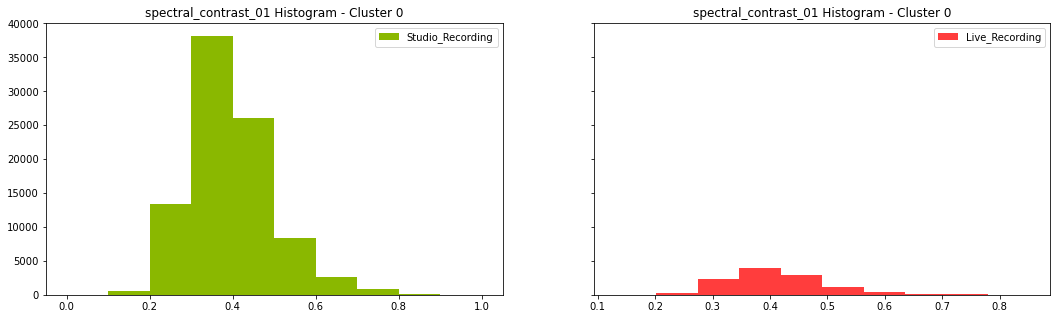

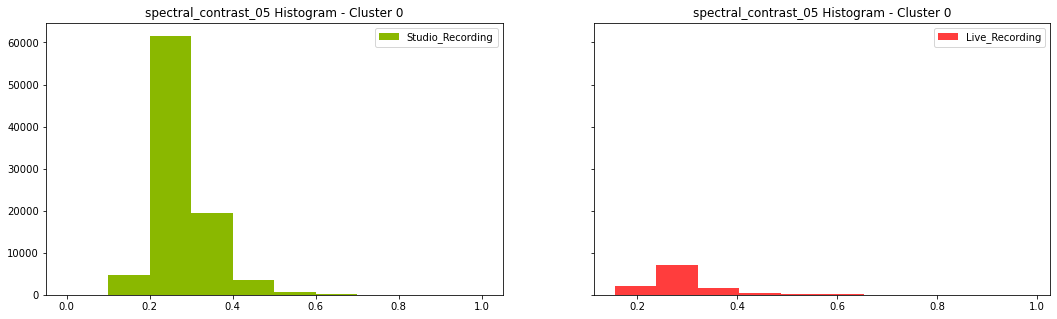

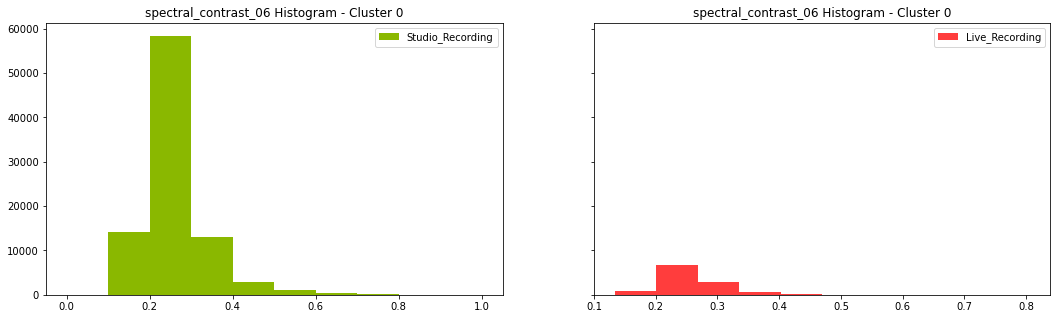

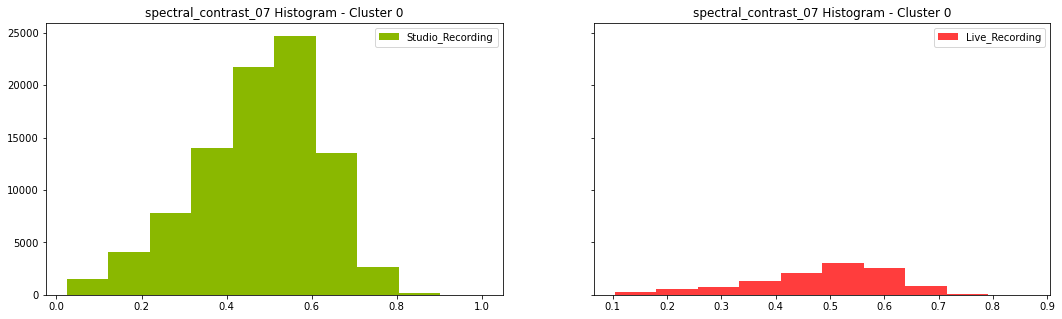

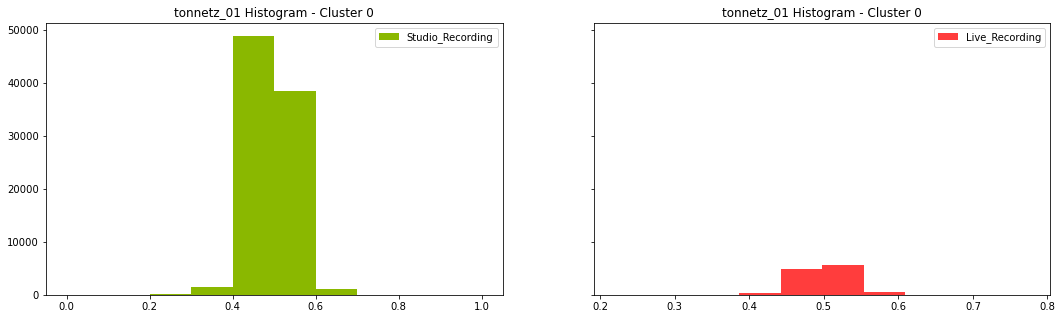

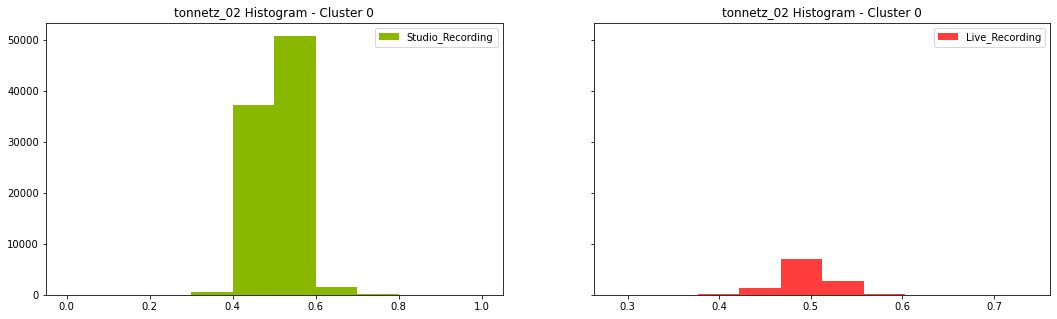

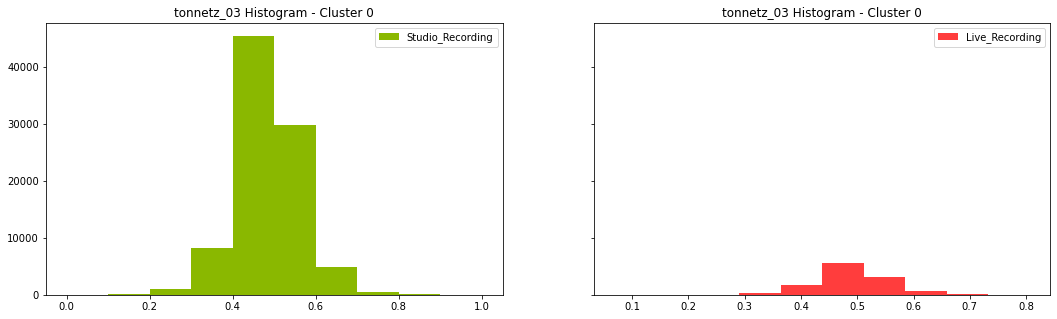

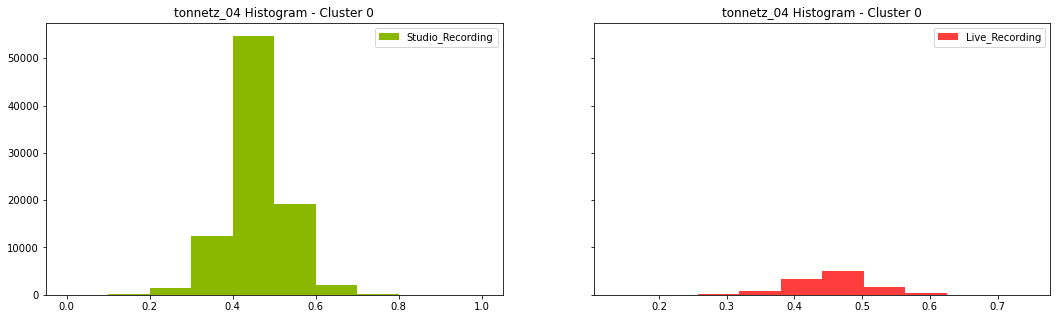

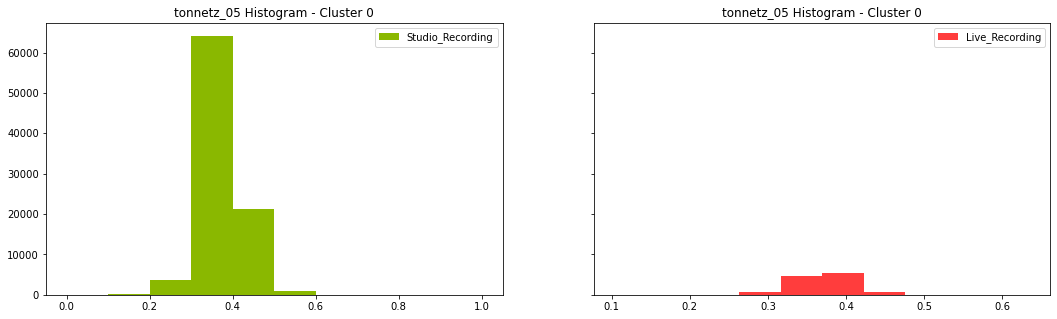

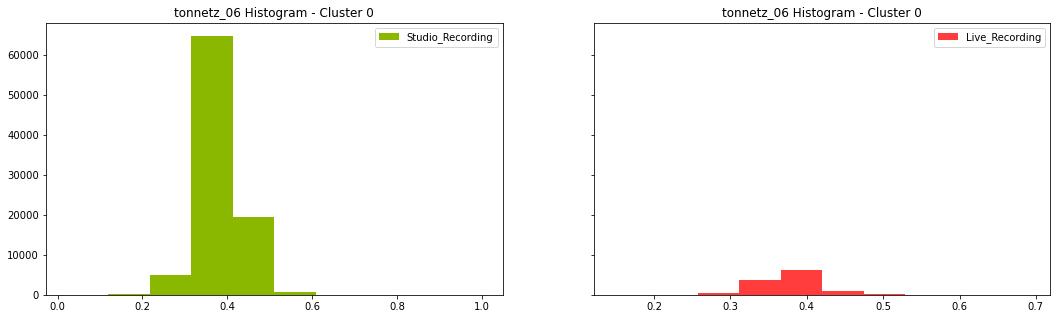

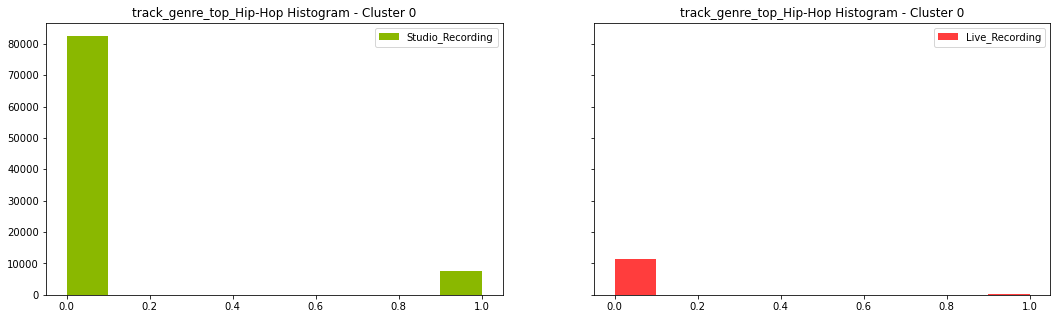

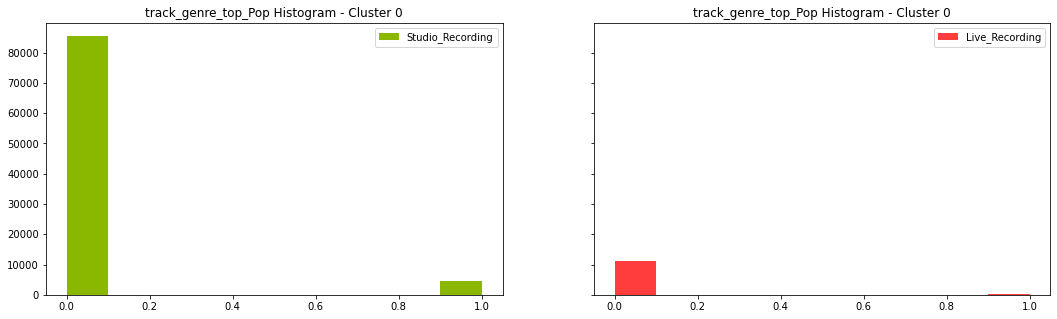

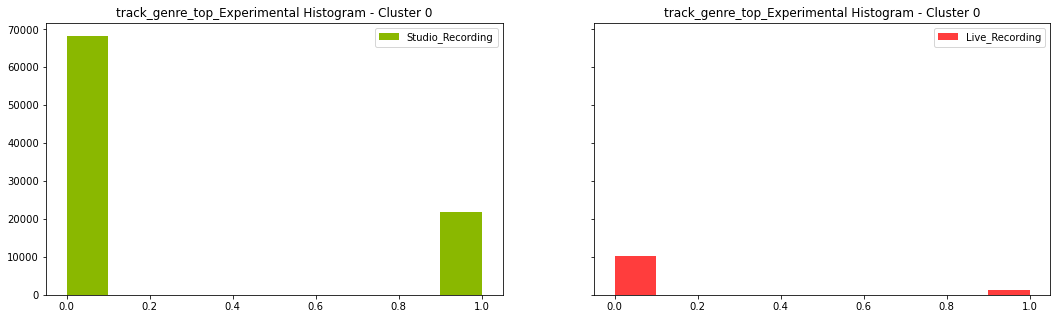

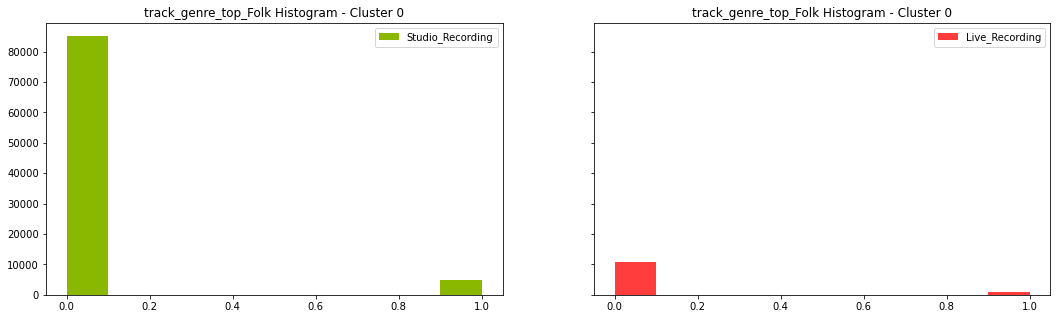

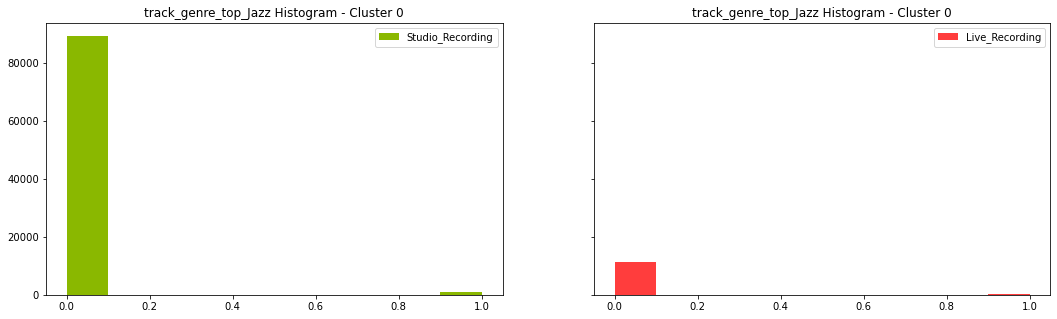

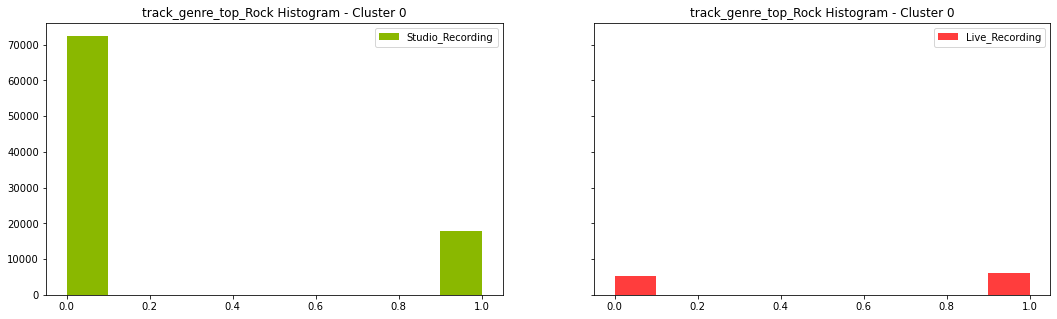

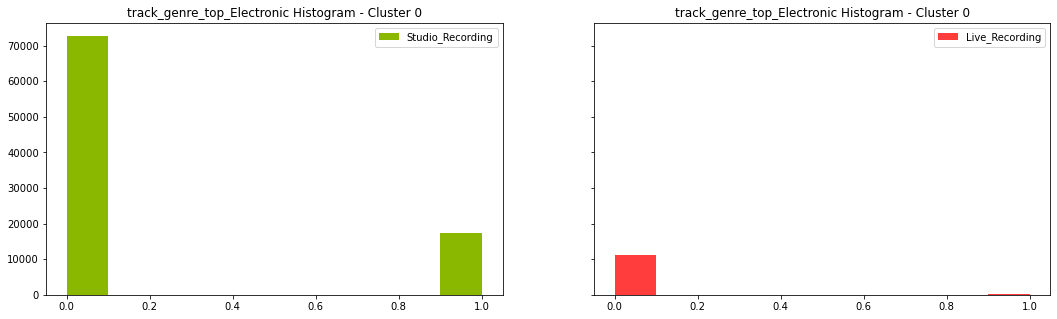

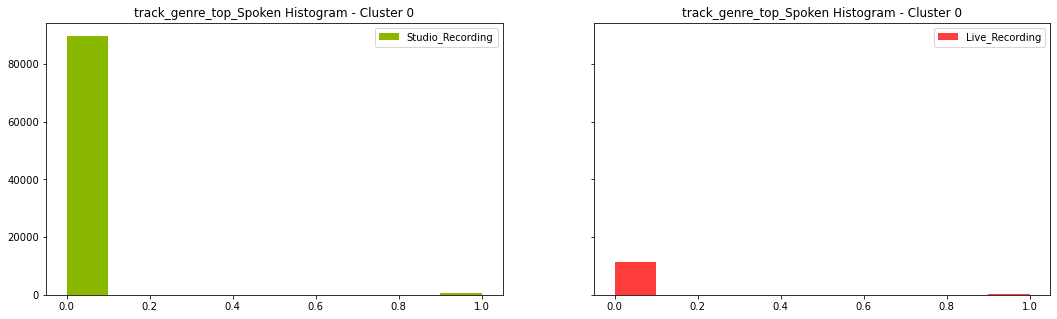

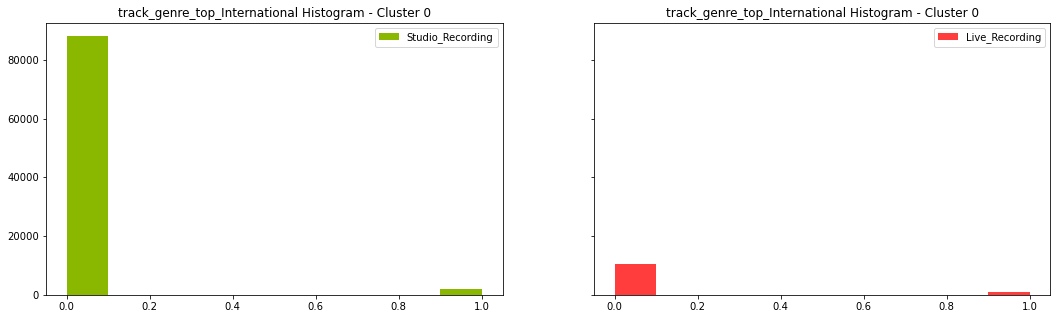

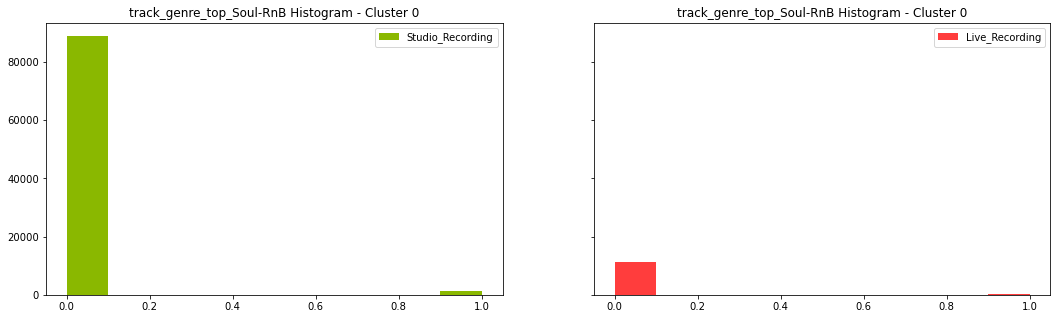

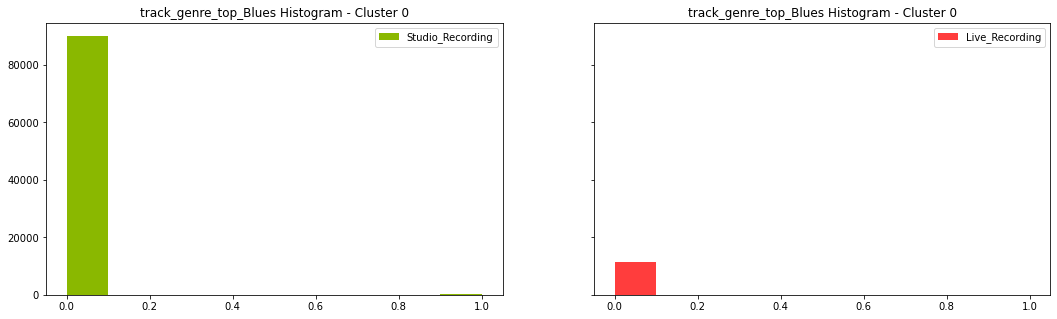

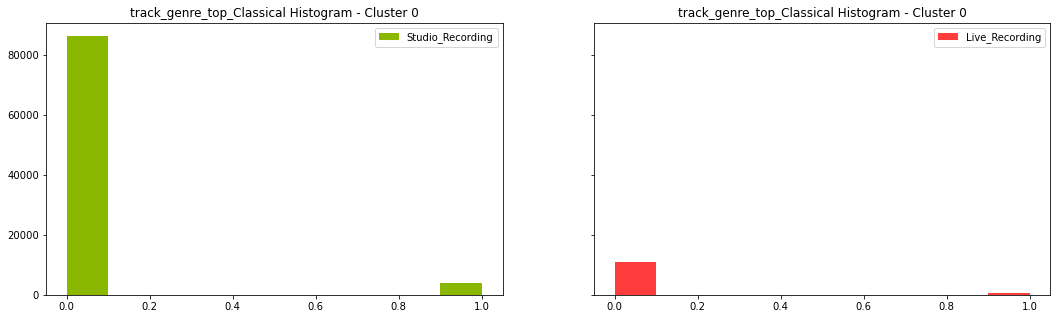

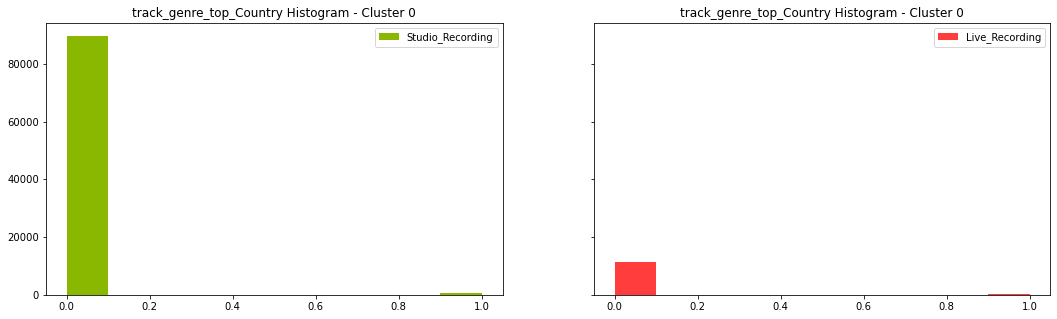

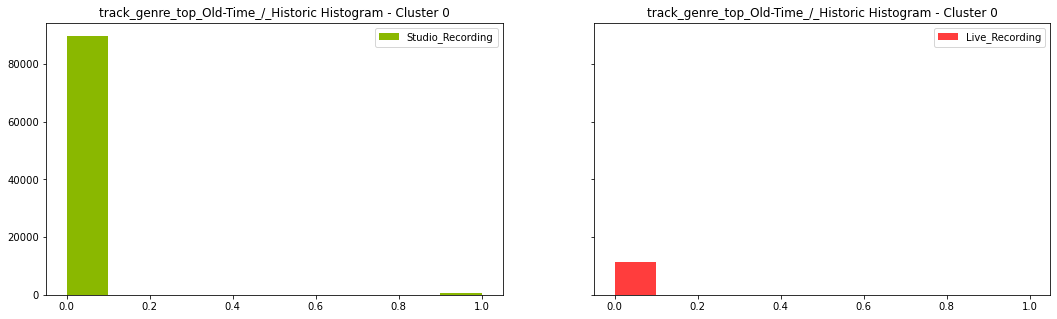

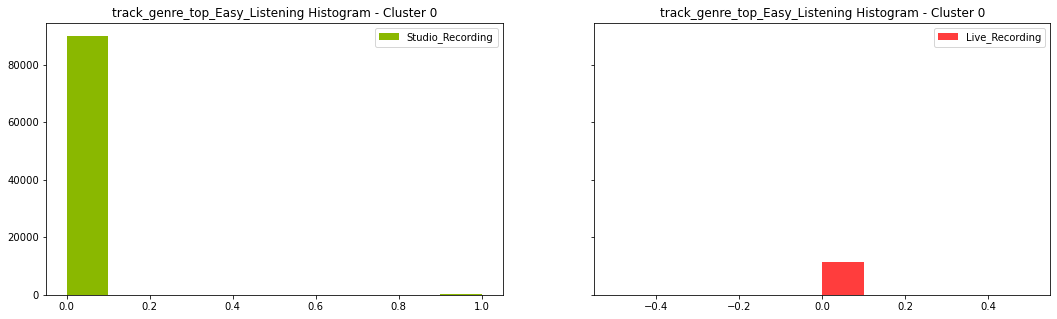

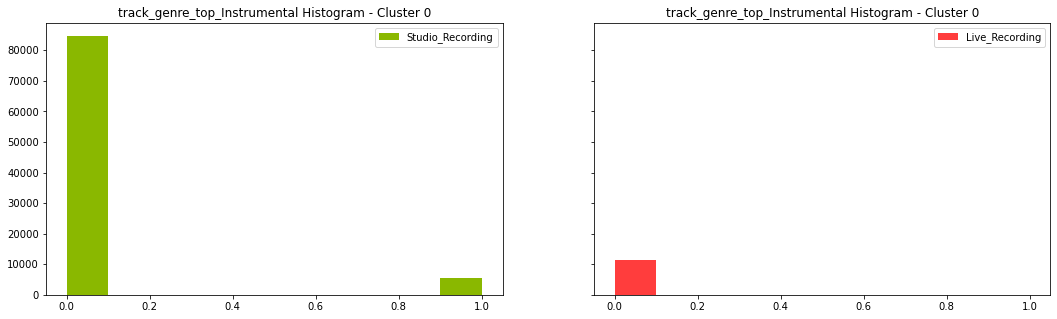

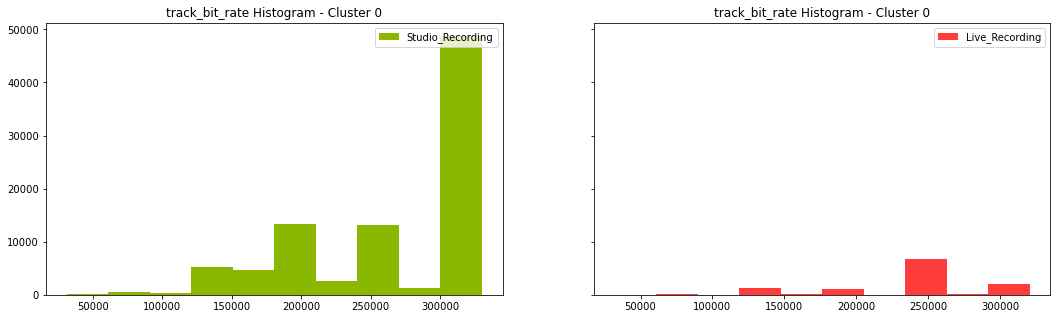

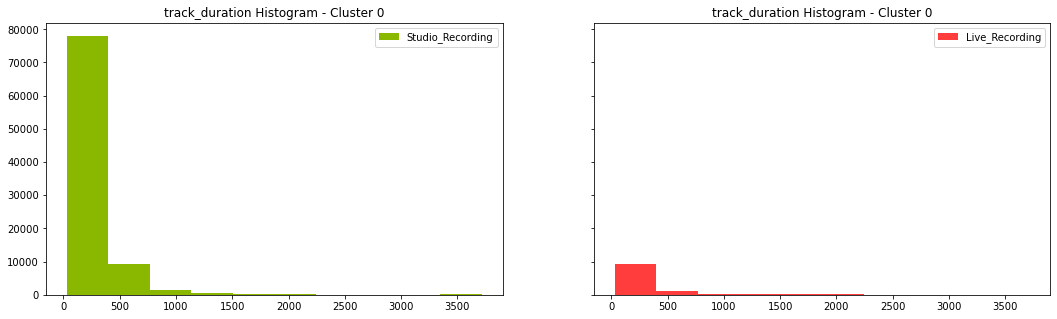

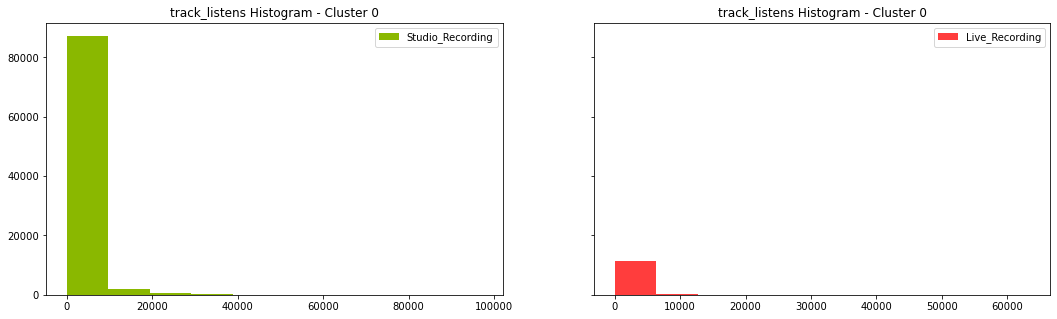

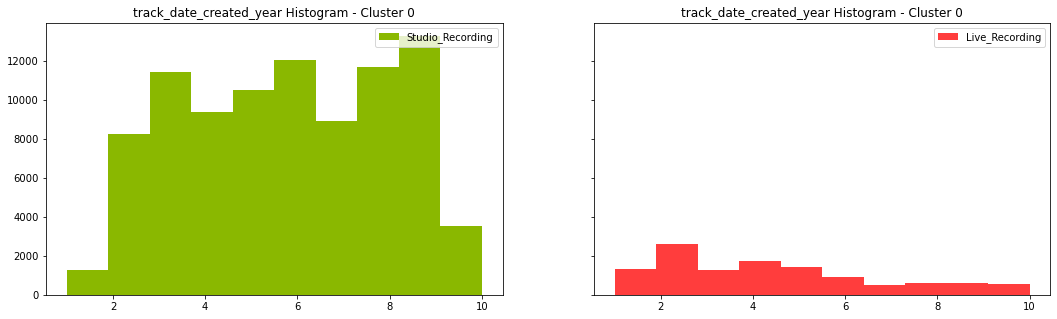

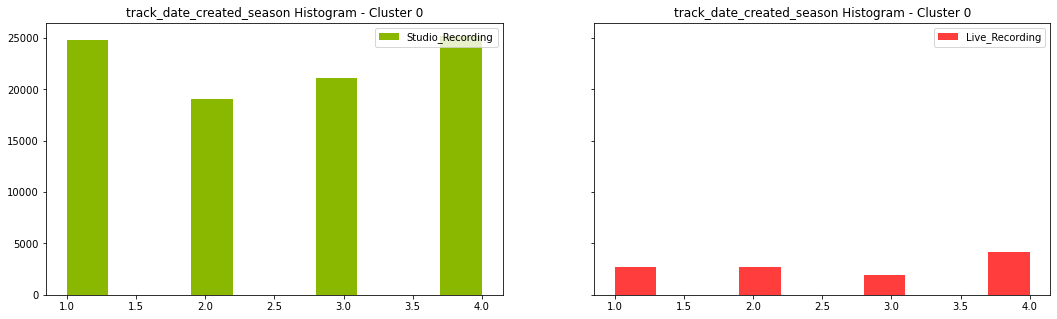

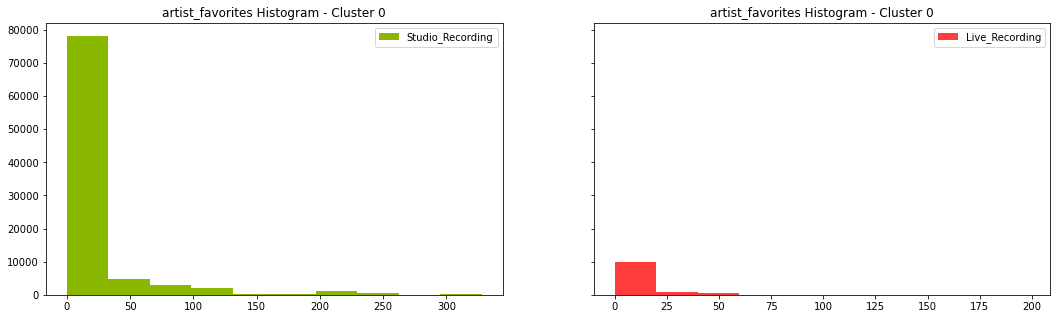

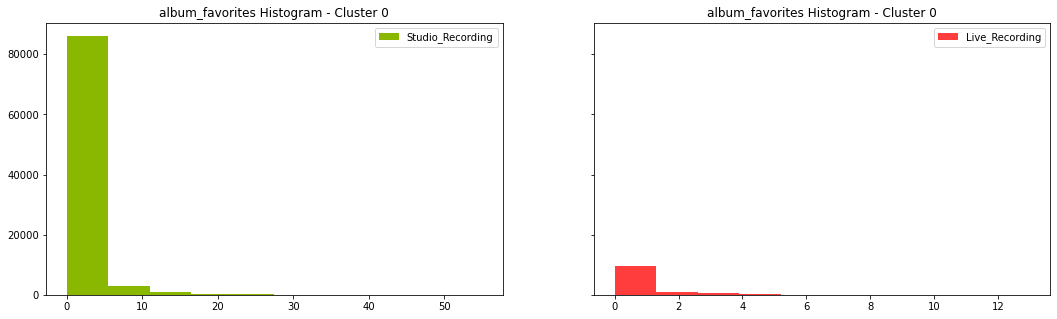

------------------------------------------------------------------------------------------------------------------
Cluster 1



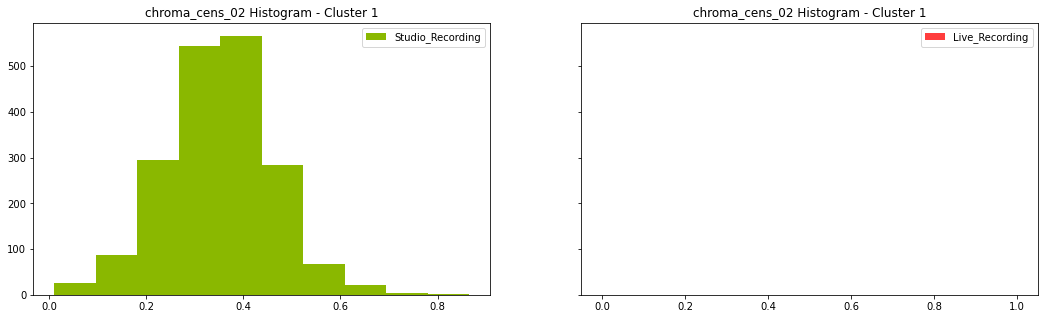

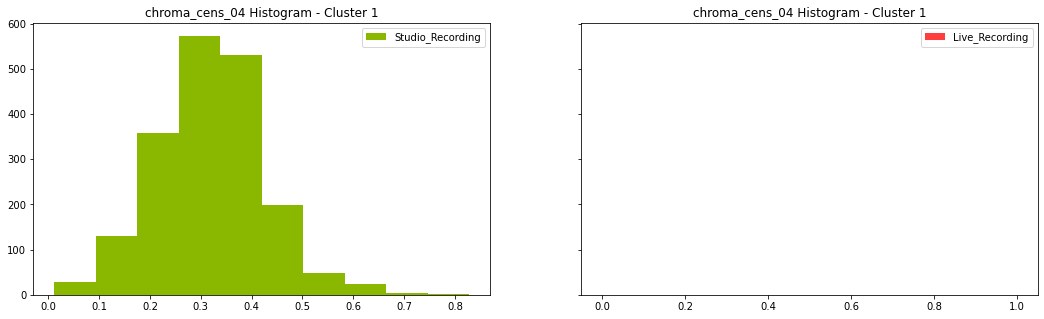

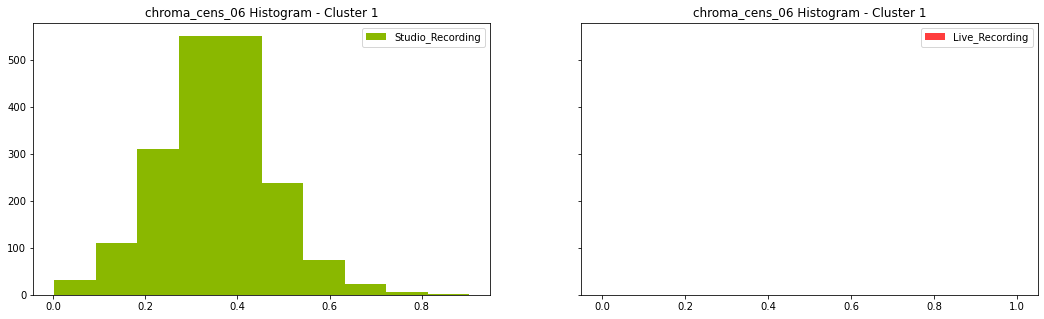

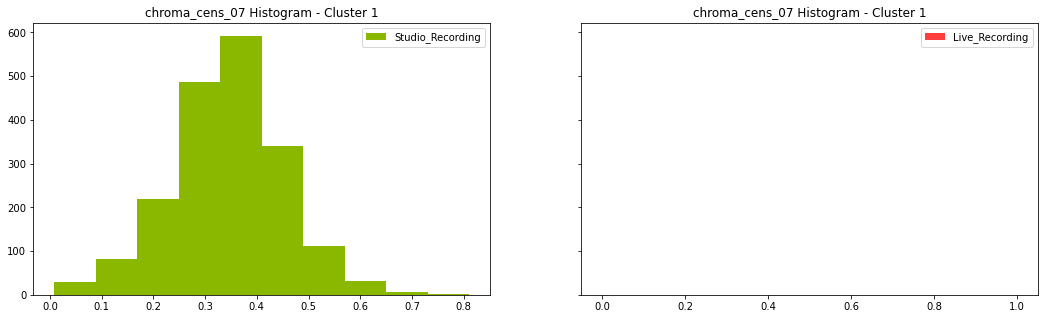

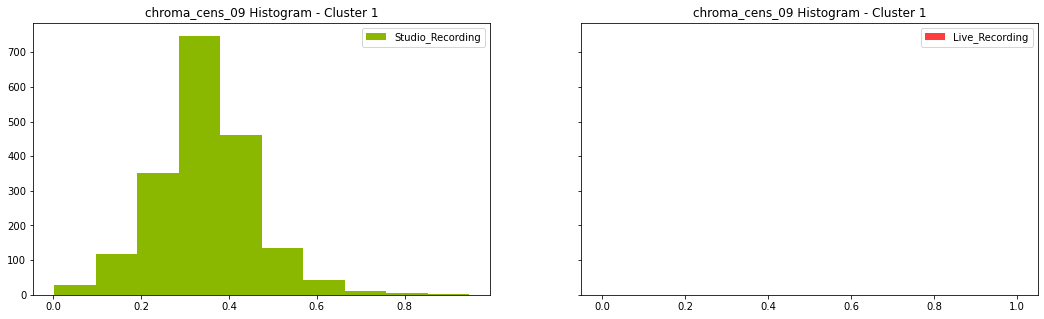

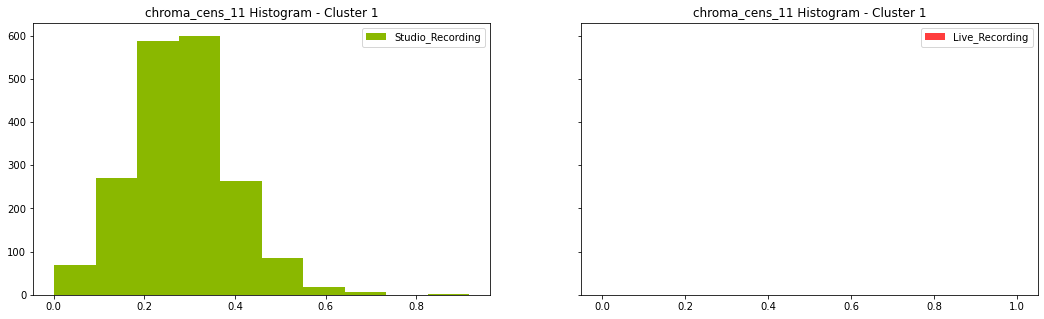

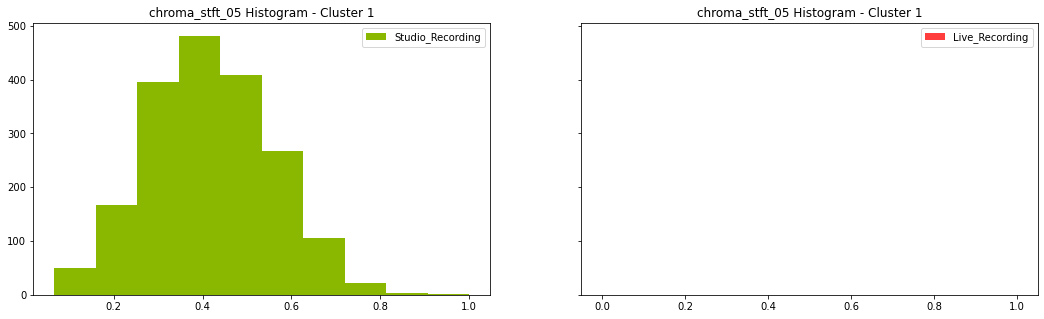

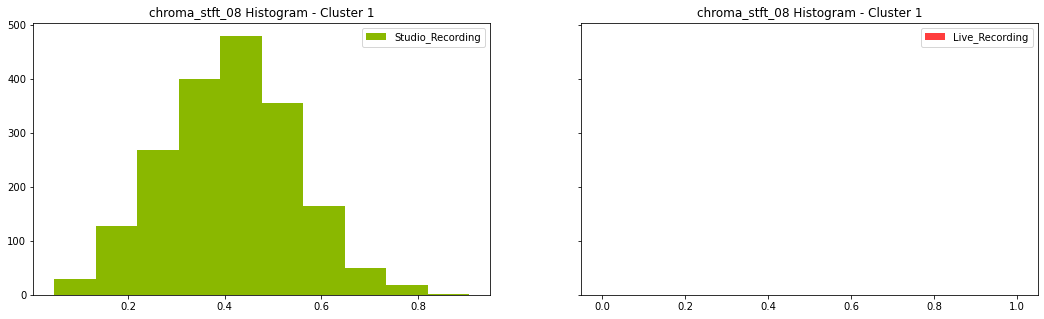

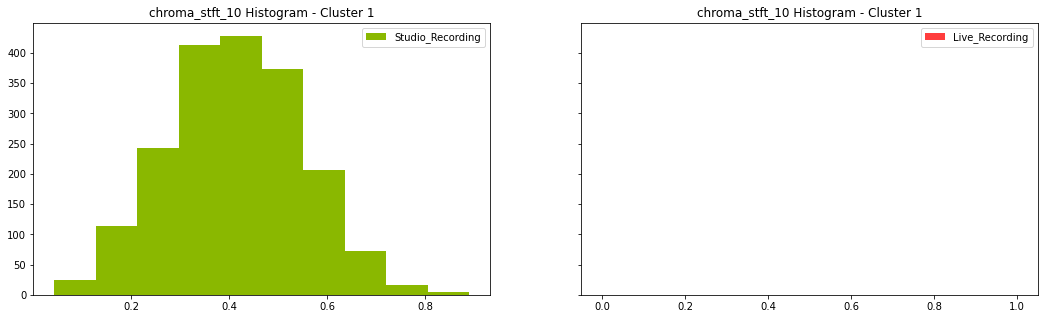

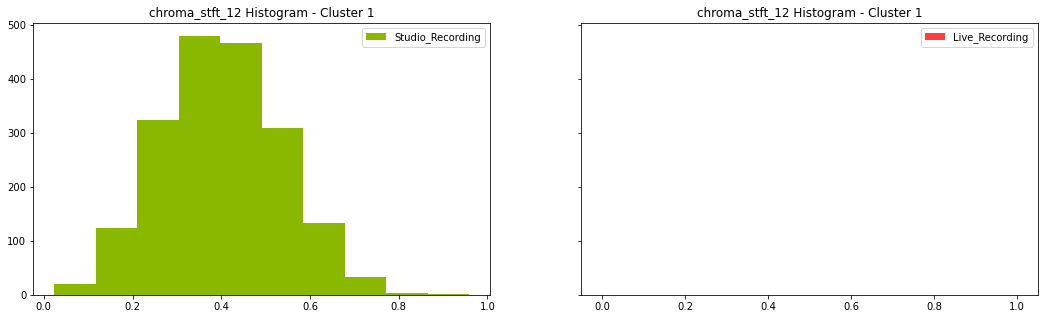

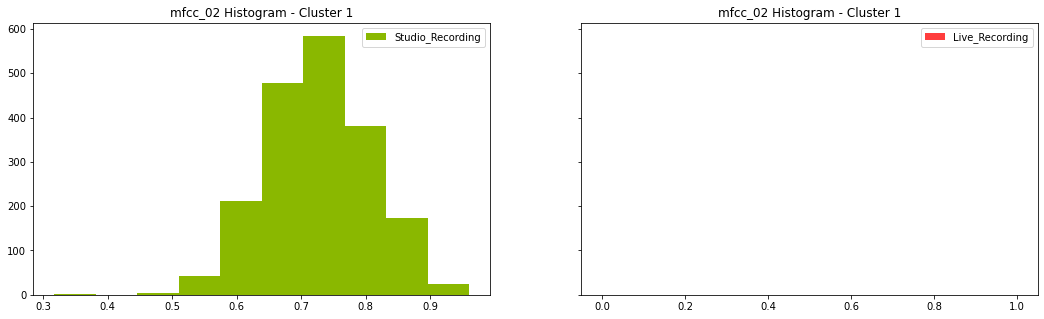

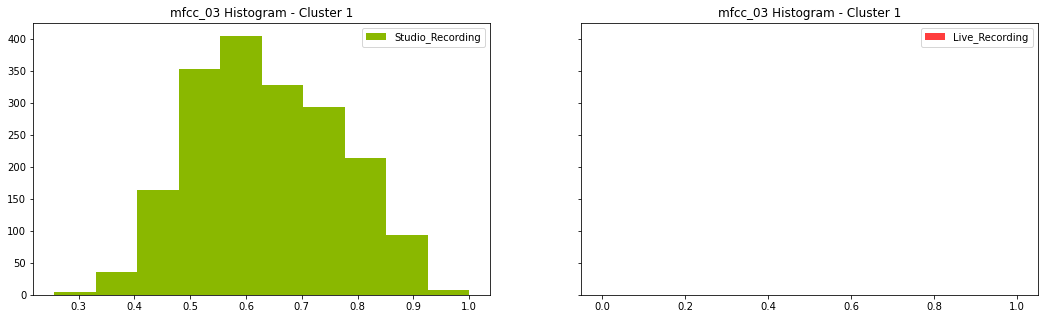

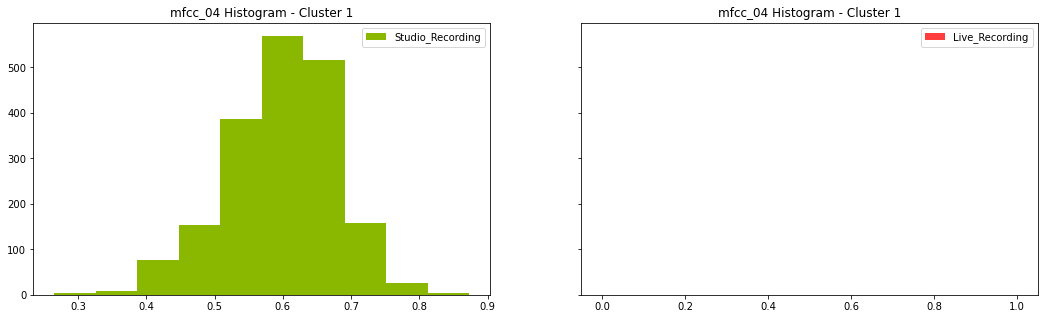

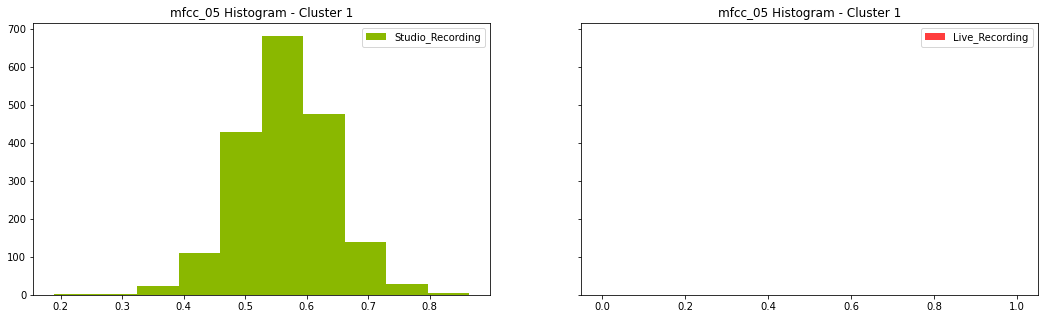

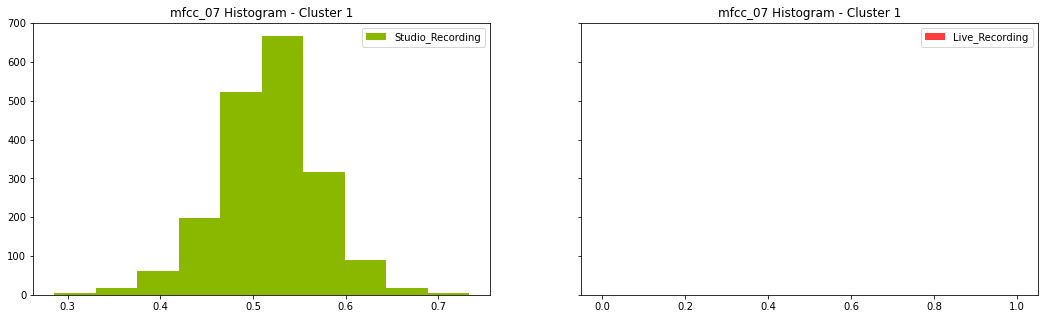

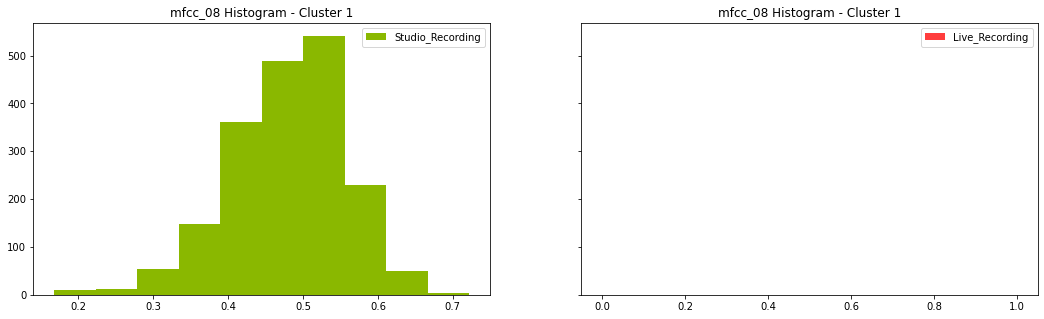

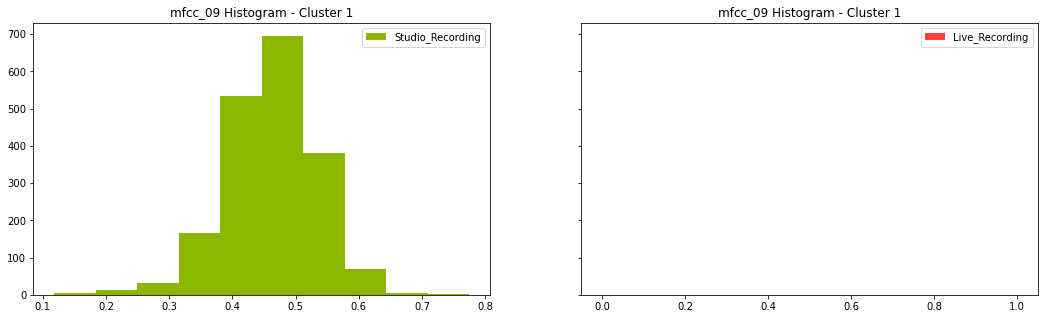

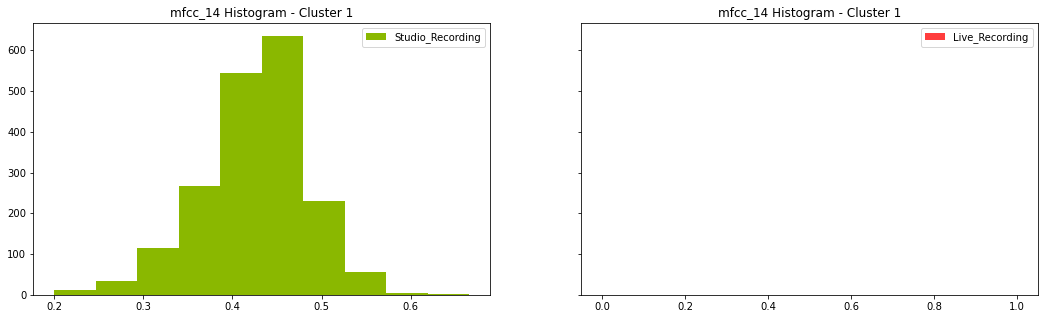

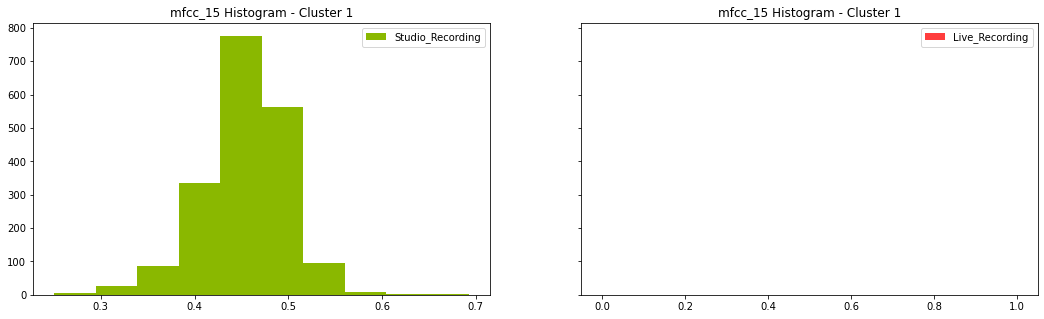

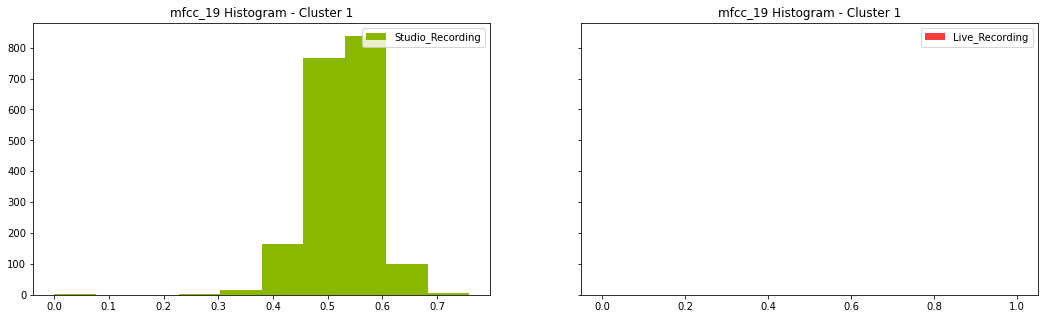

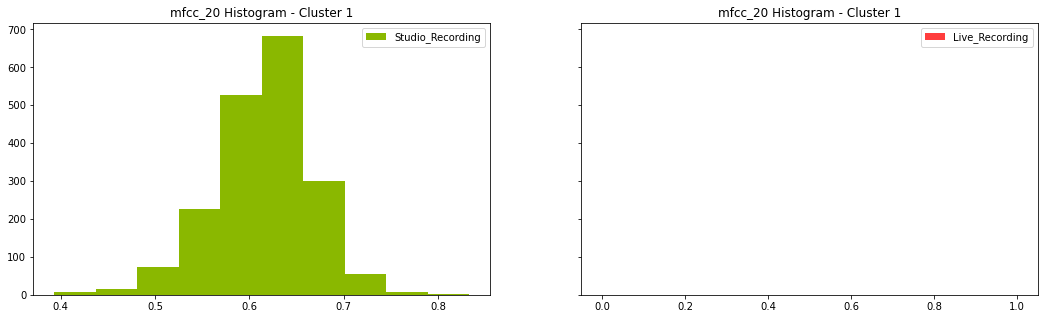

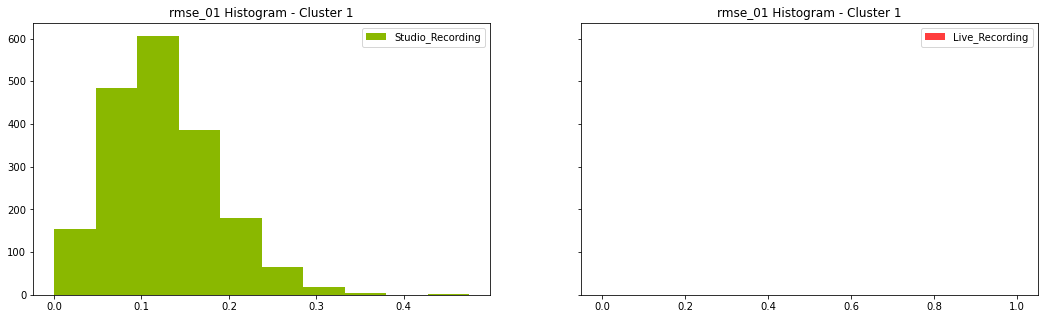

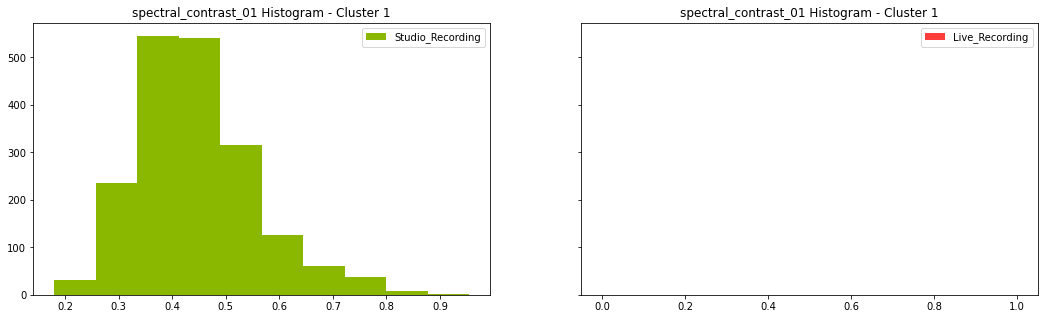

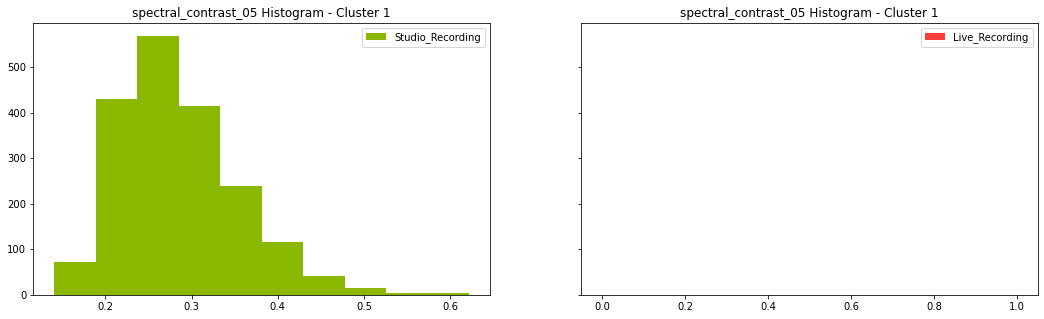

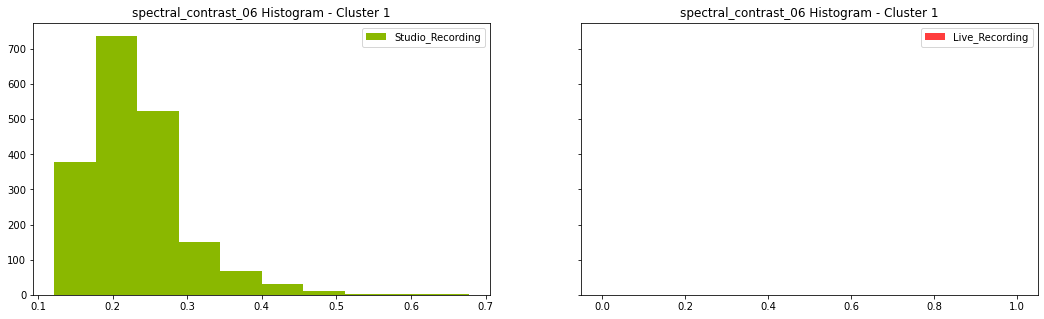

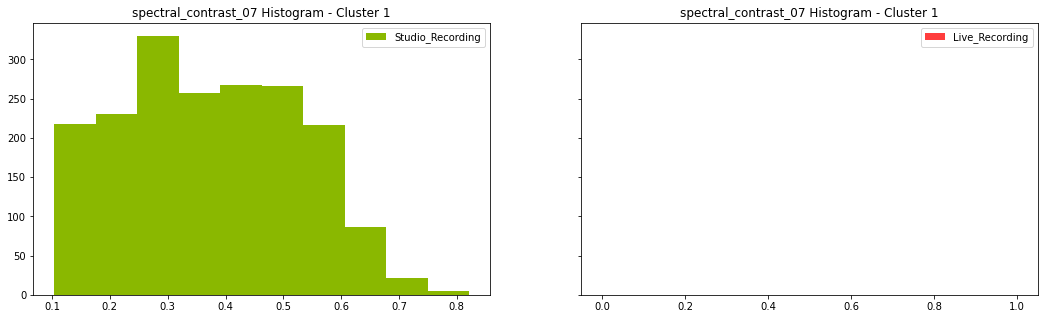

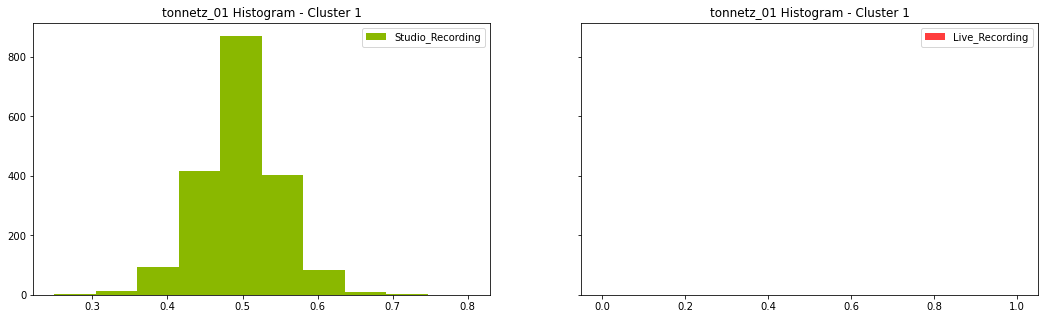

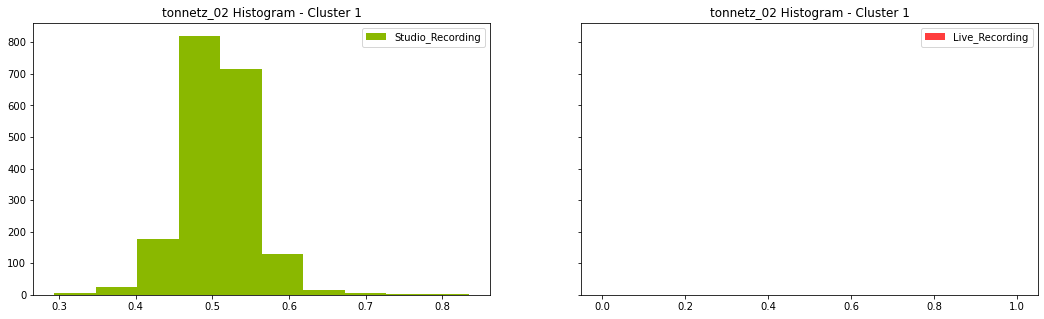

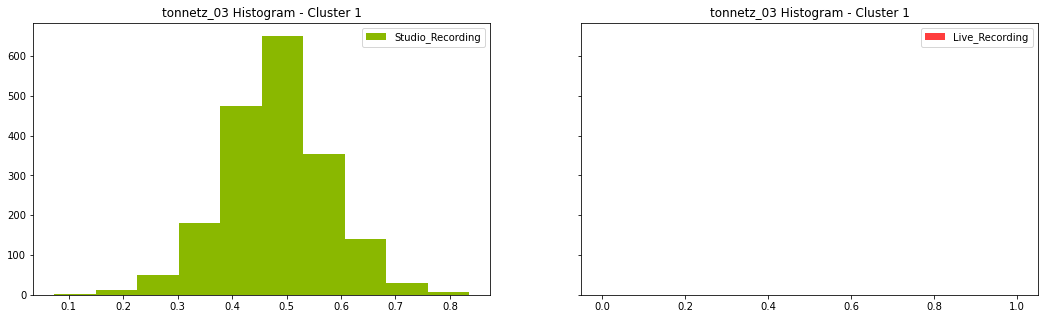

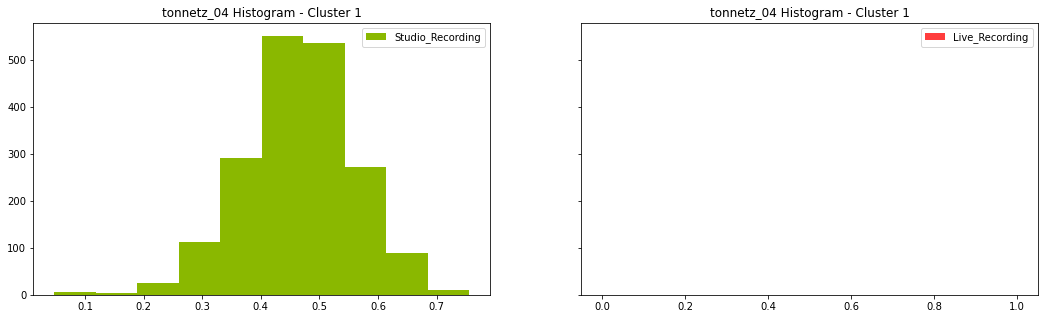

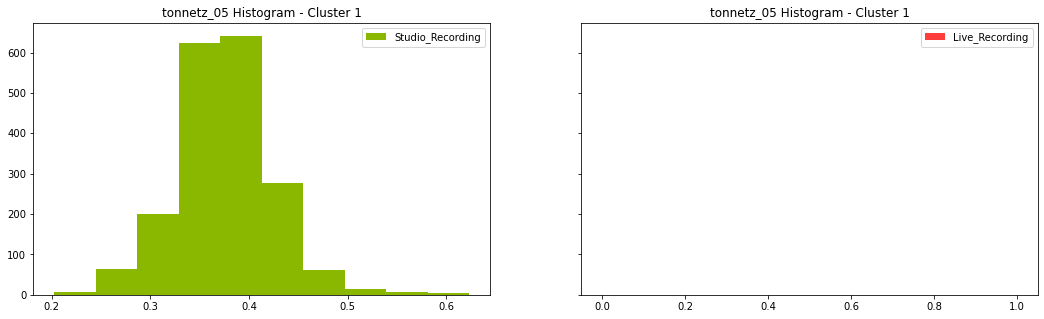

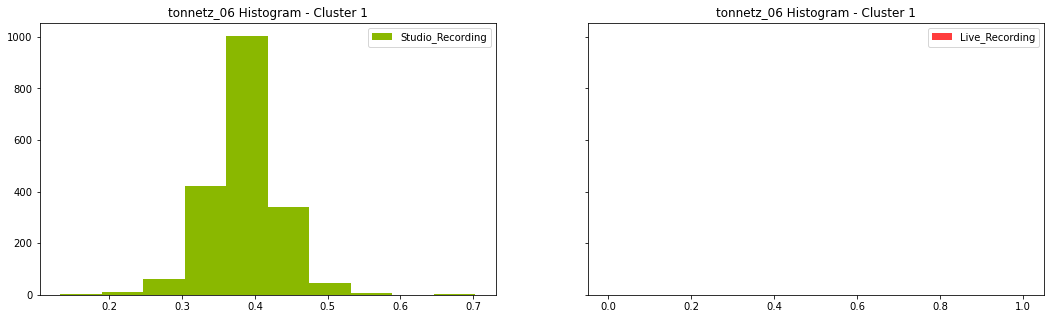

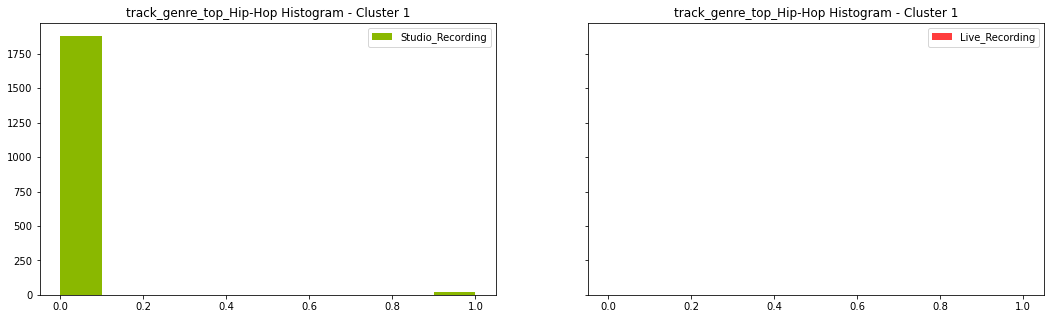

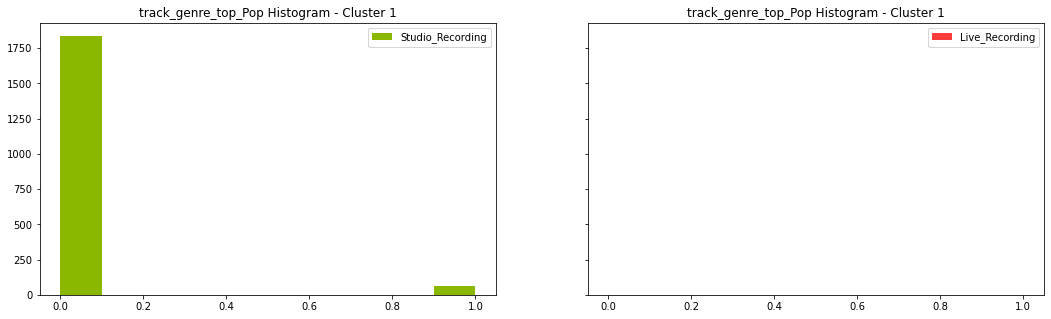

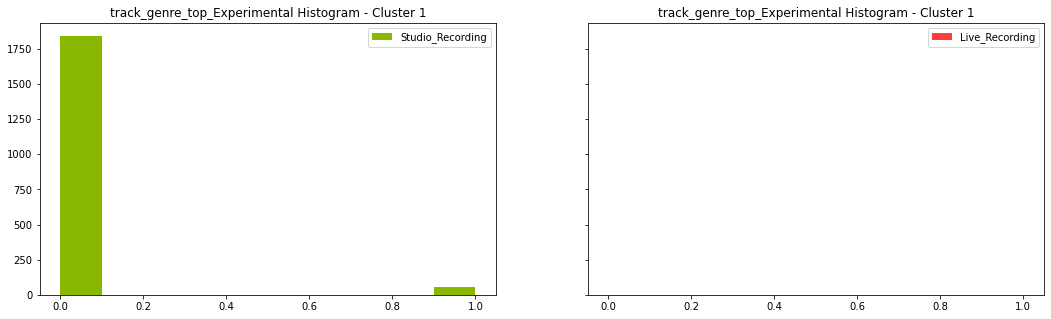

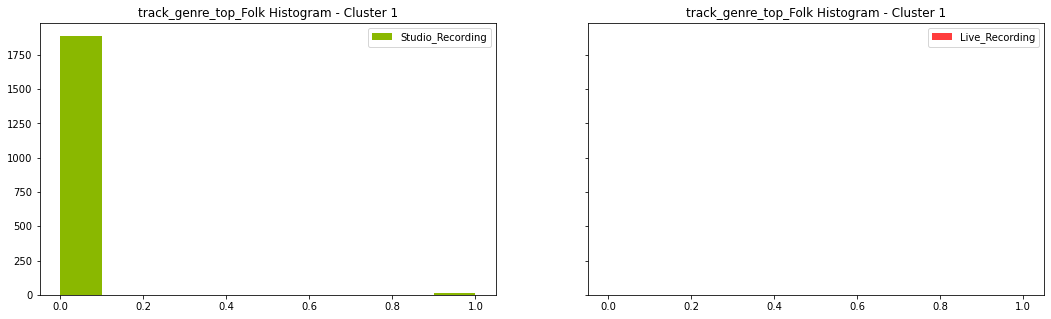

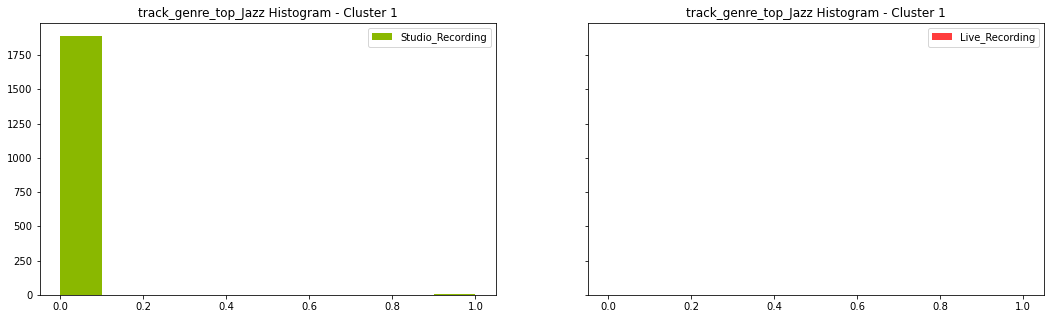

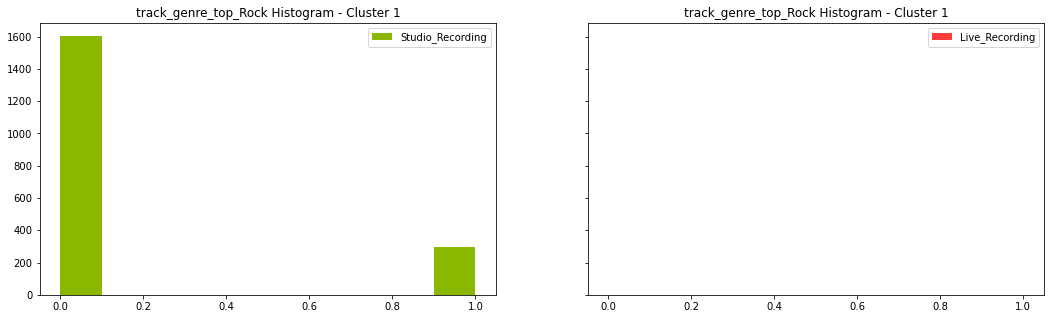

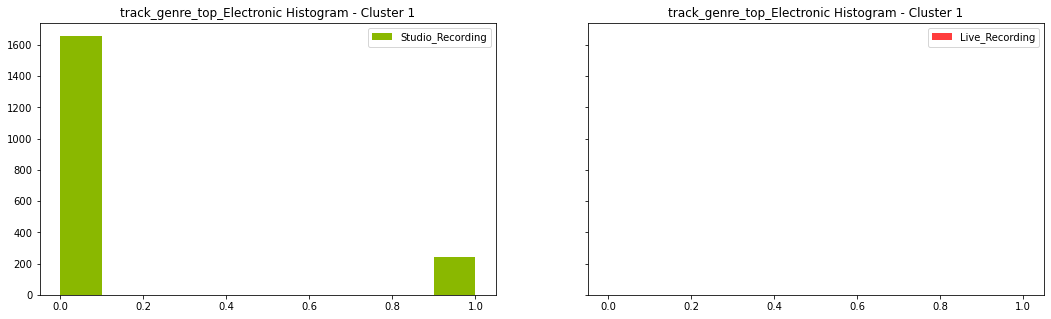

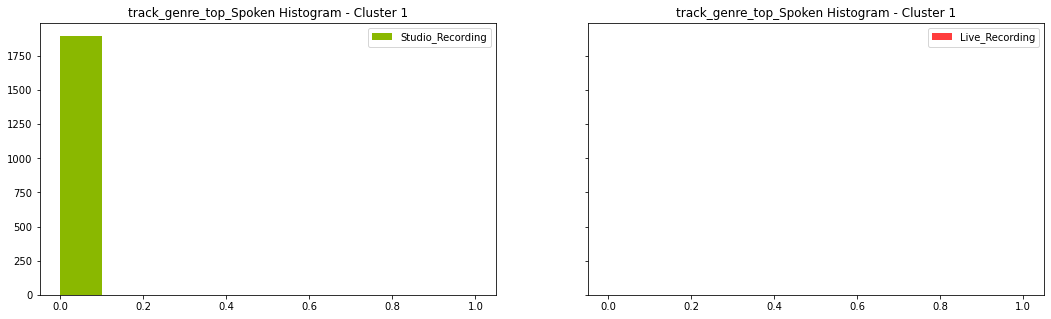

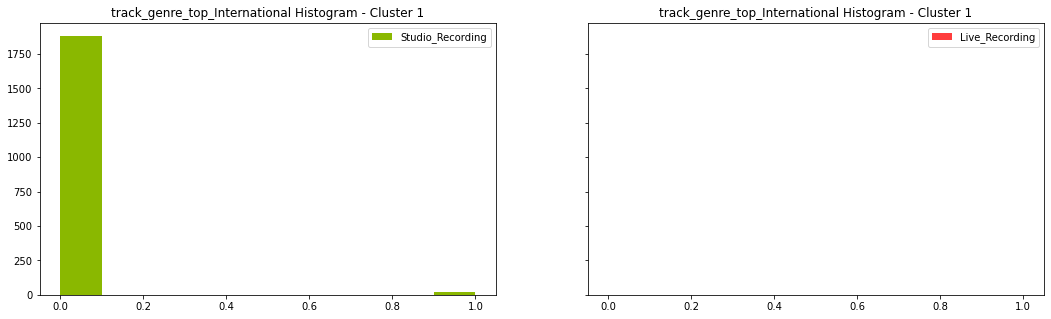

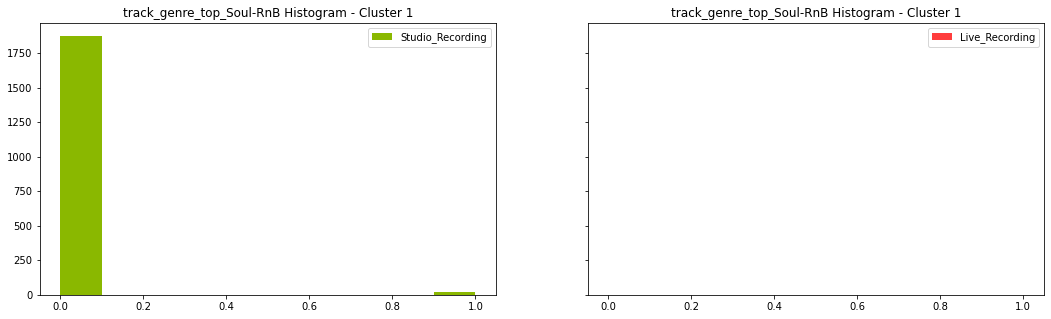

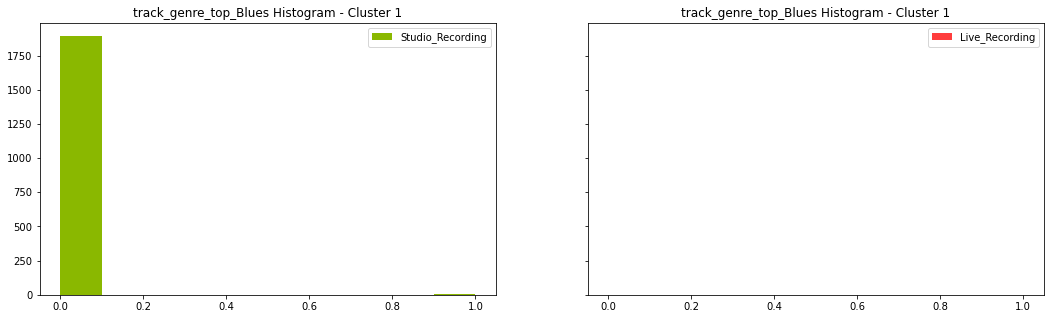

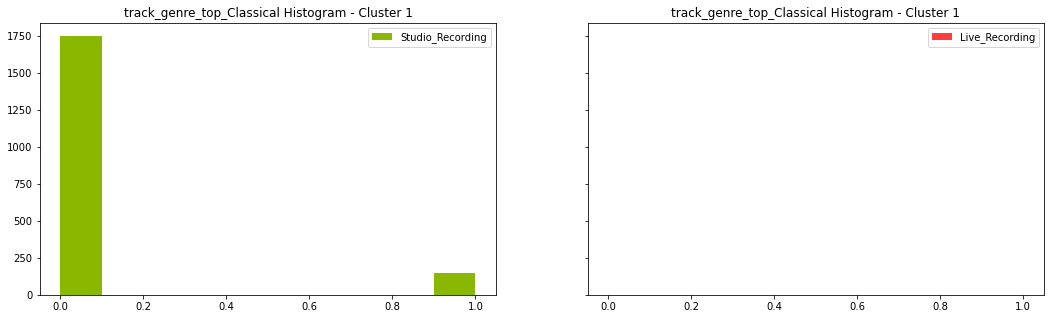

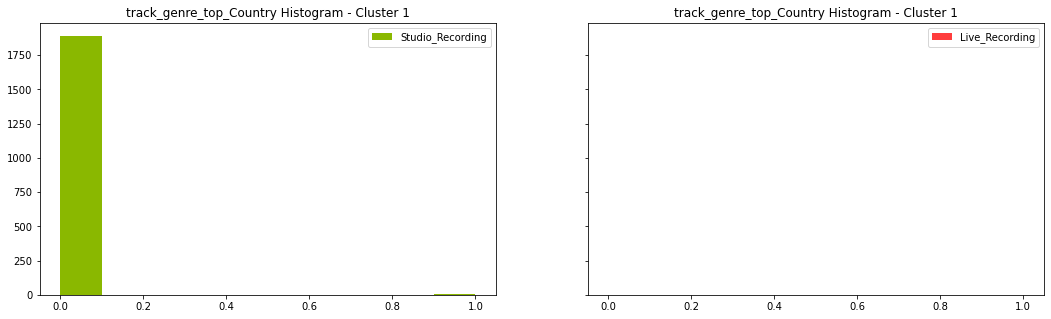

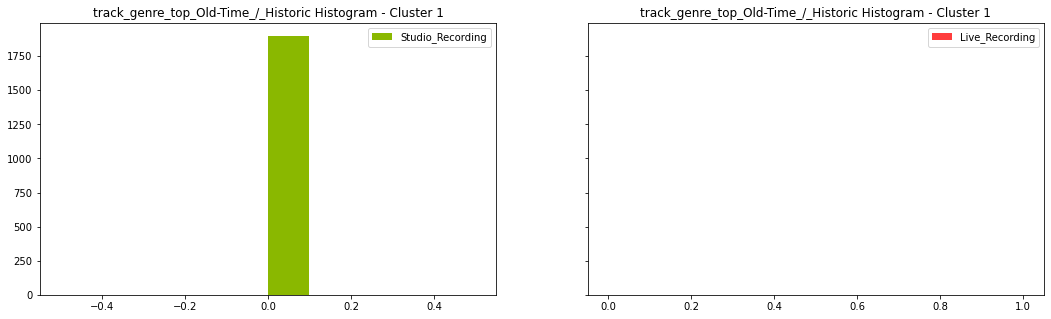

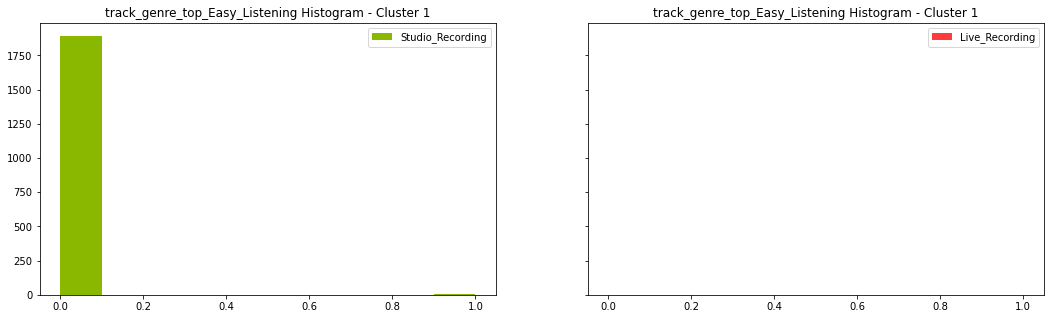

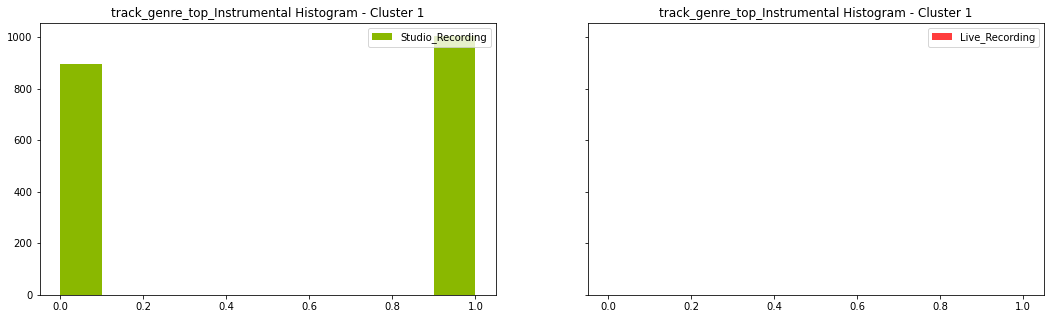

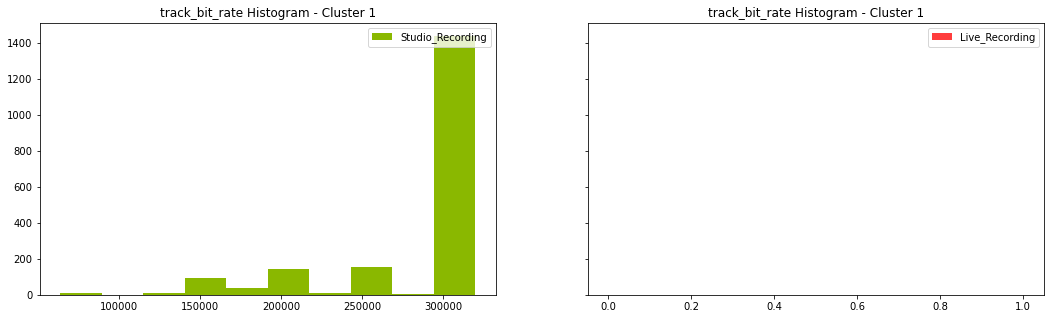

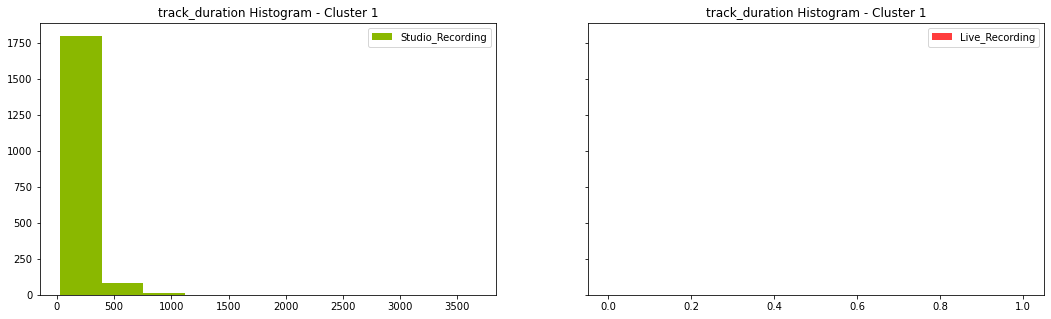

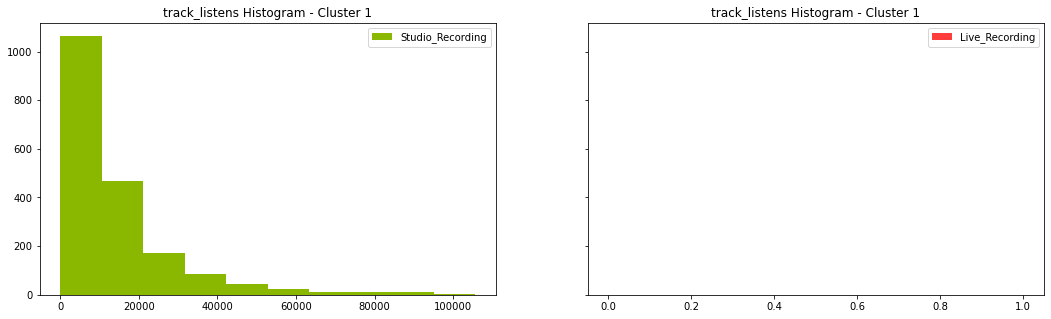

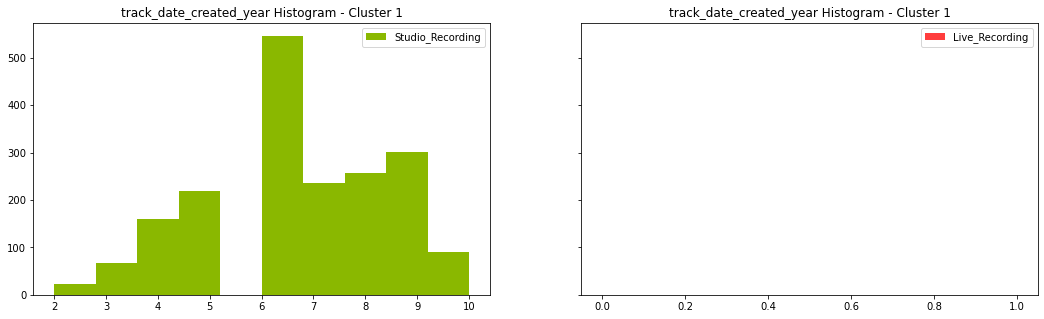

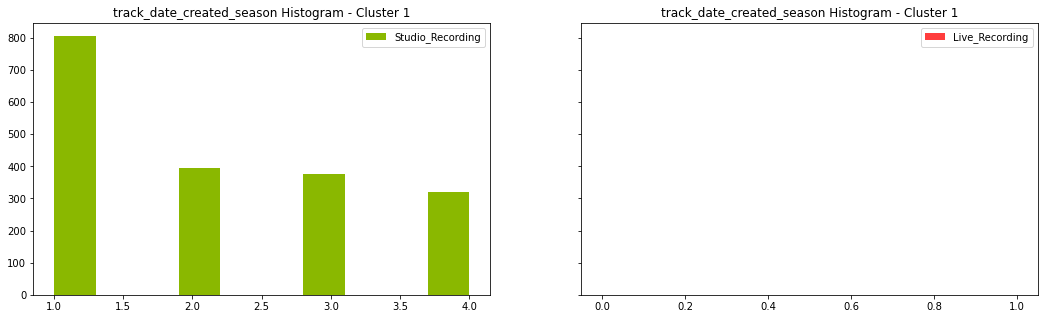

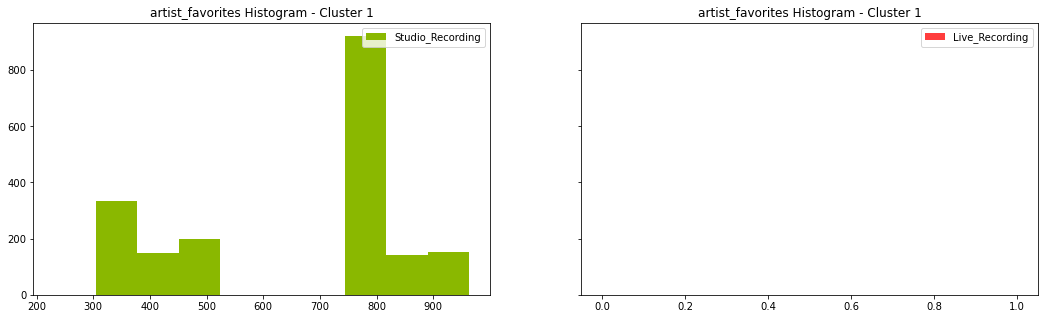

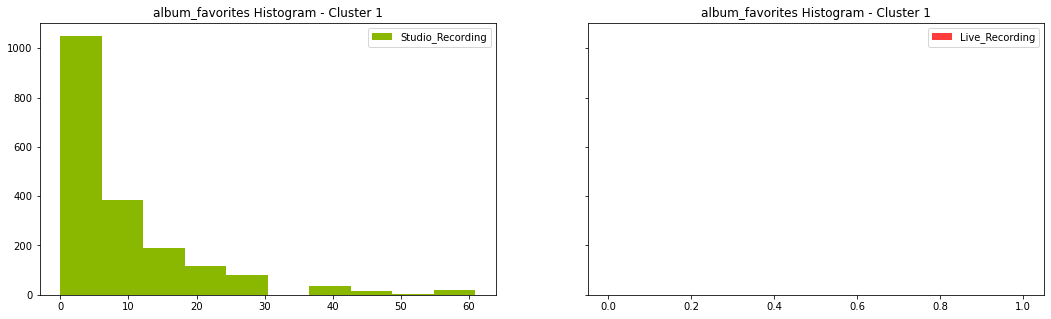

------------------------------------------------------------------------------------------------------------------
Cluster 2



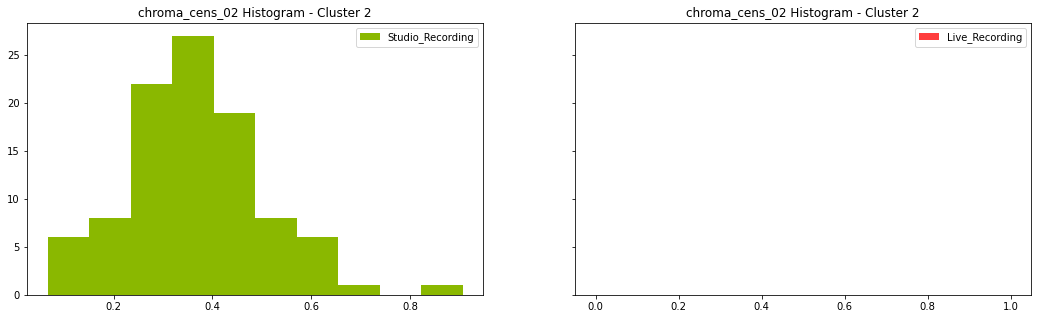

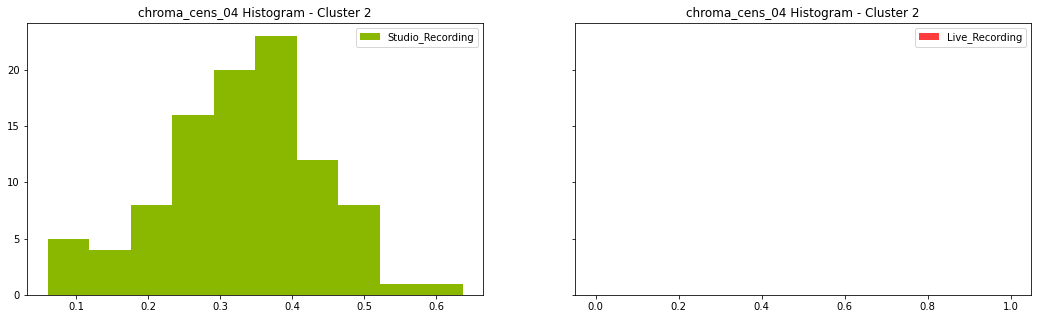

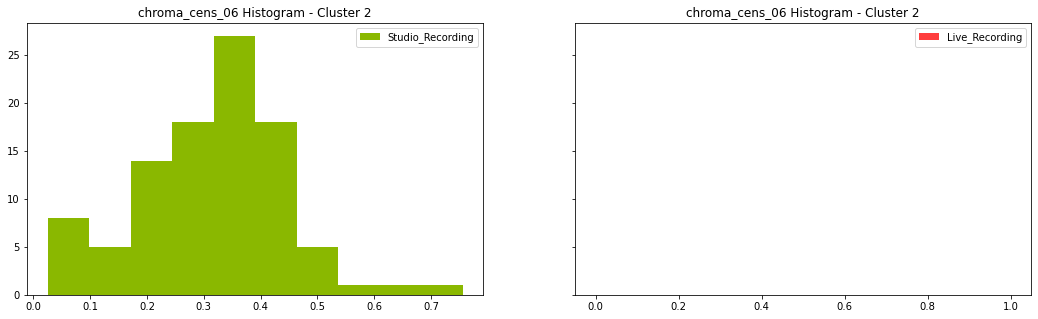

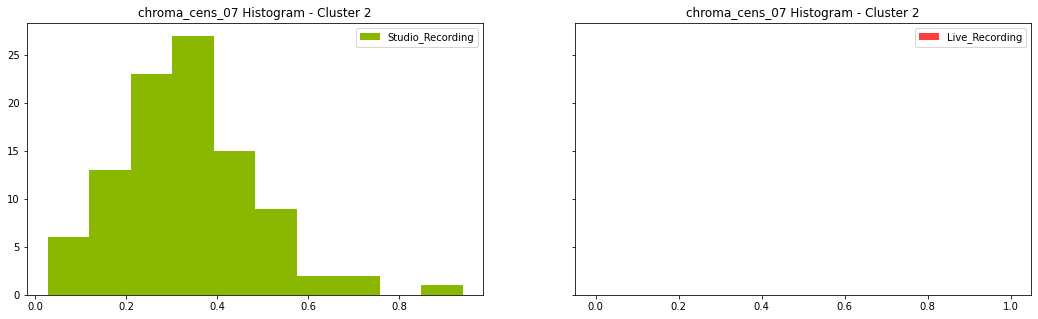

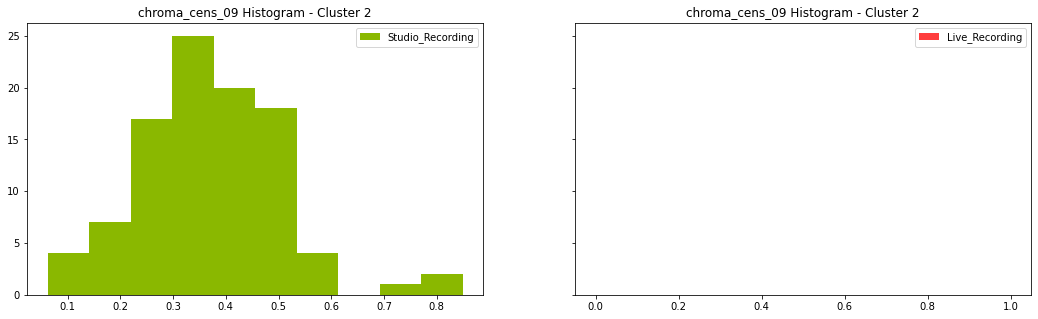

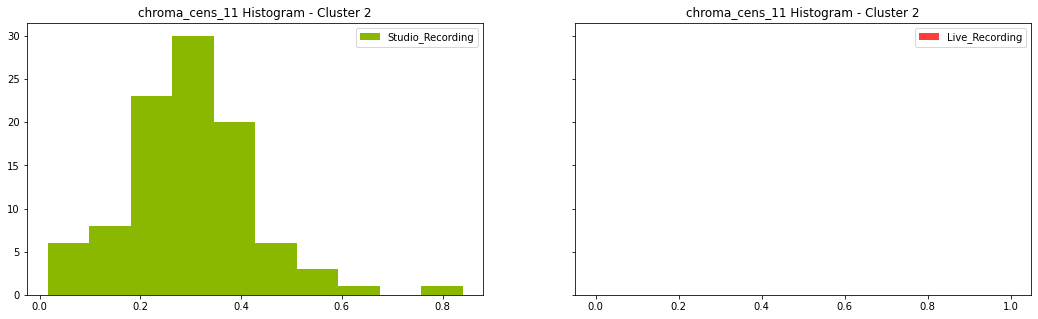

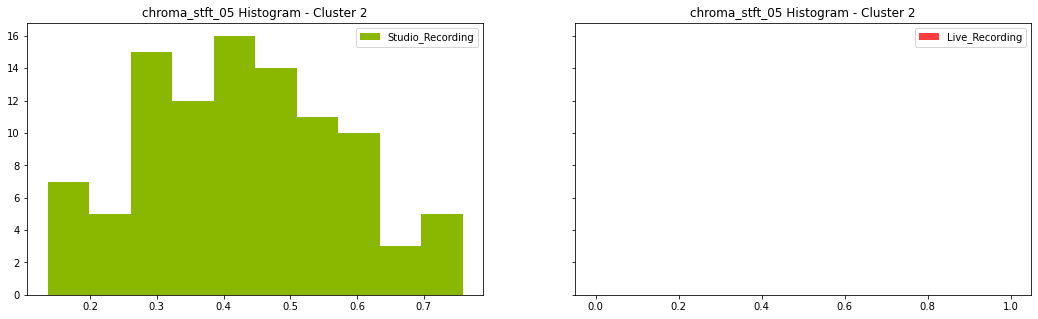

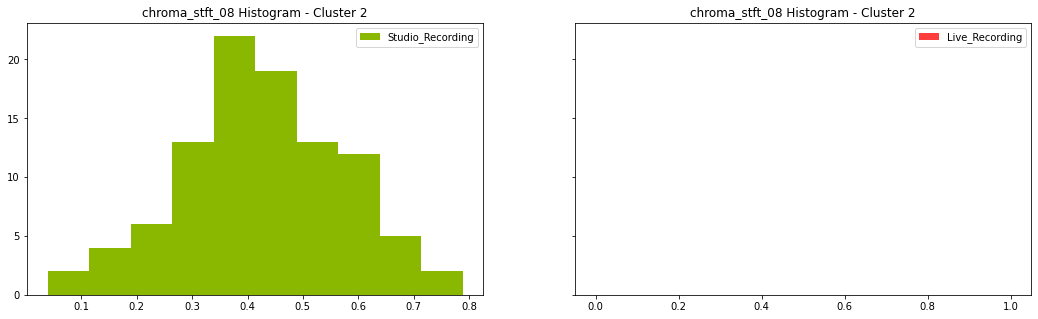

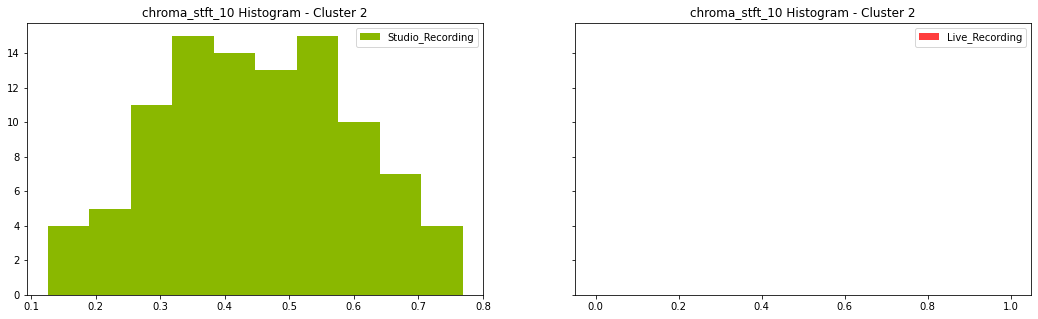

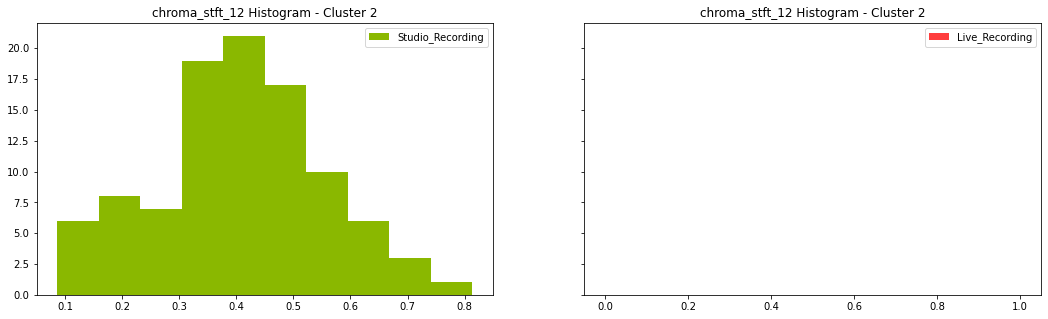

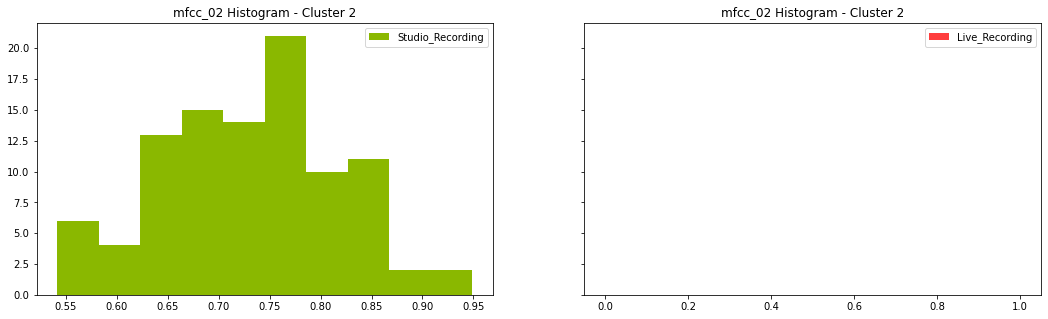

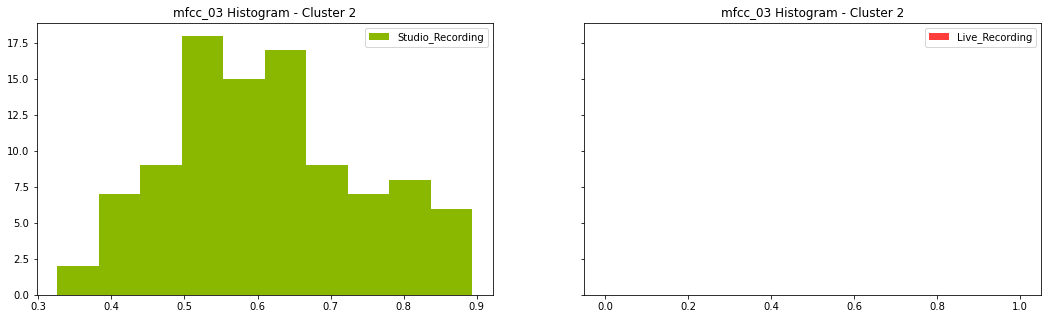

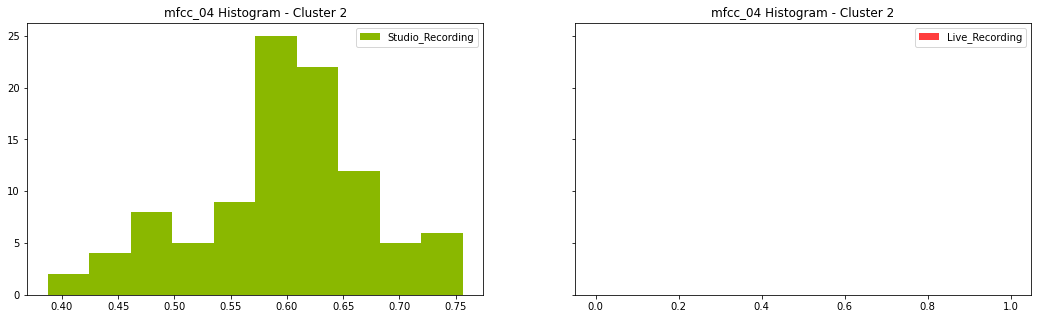

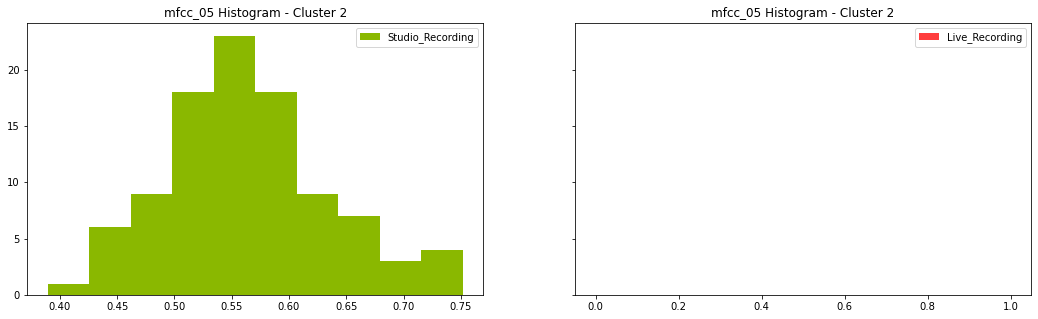

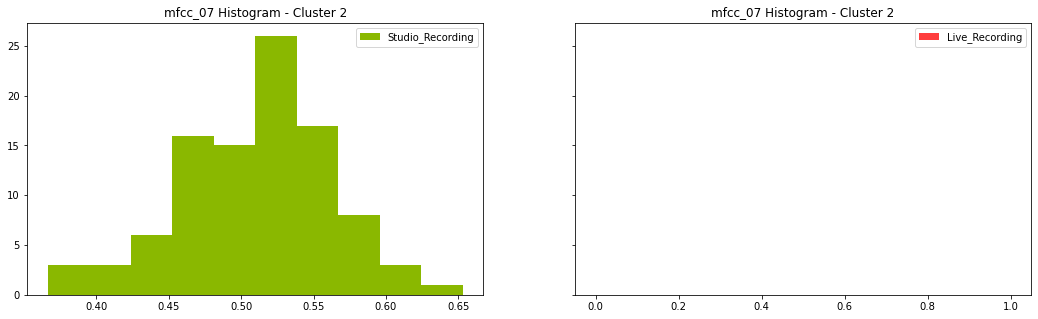

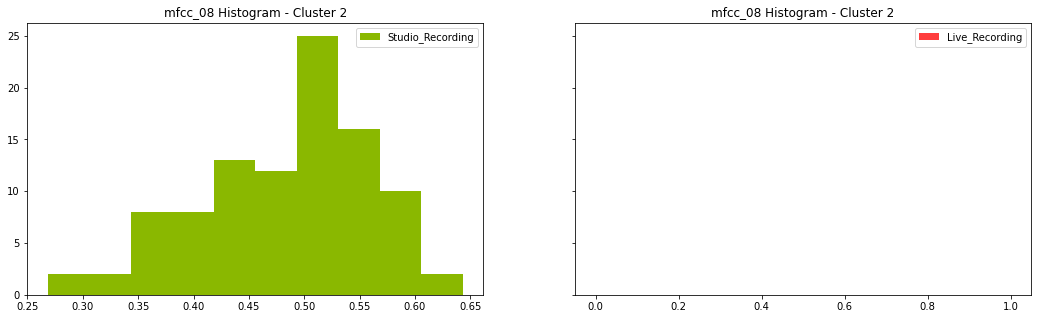

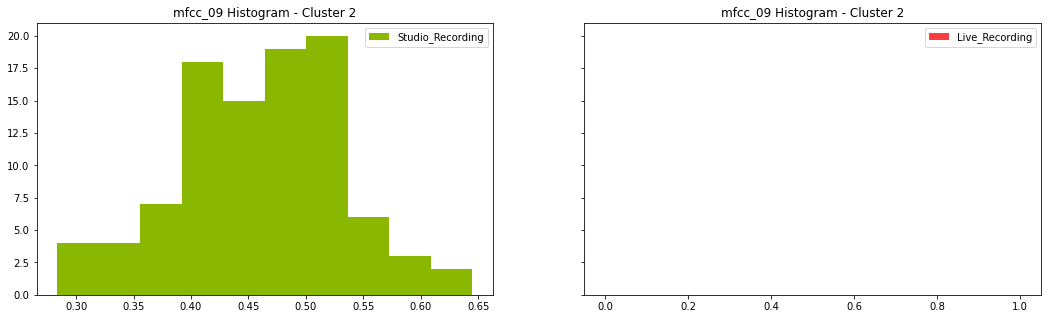

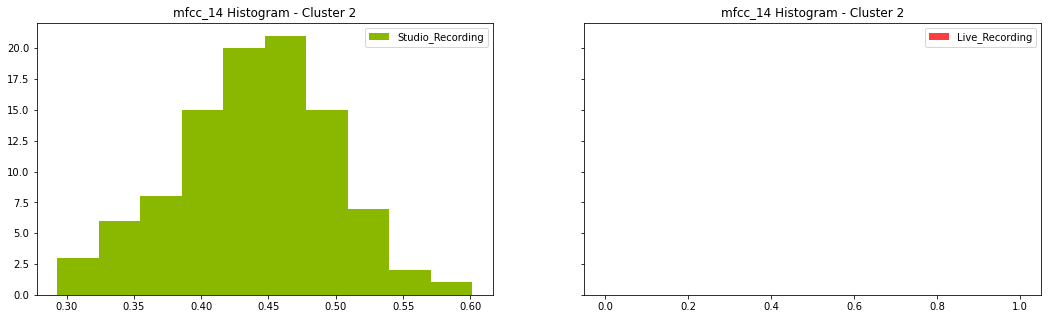

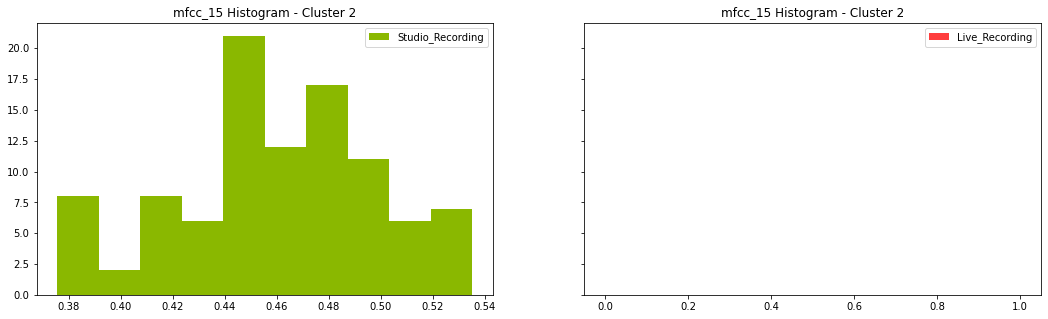

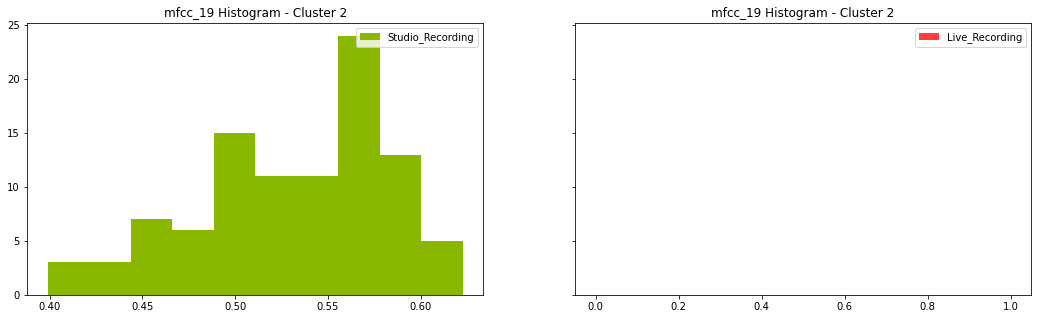

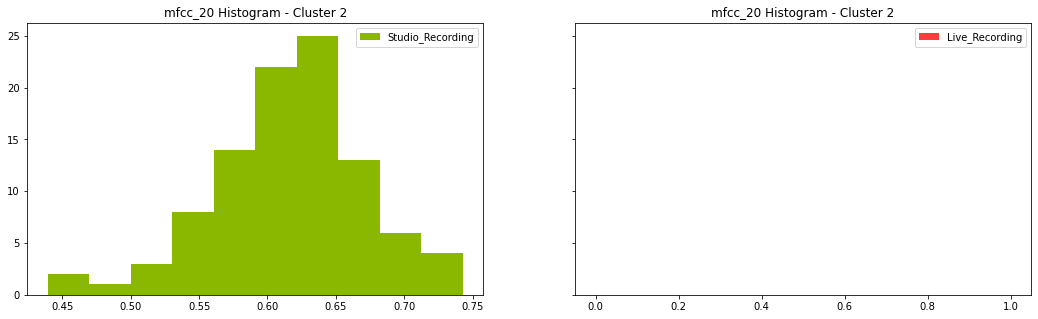

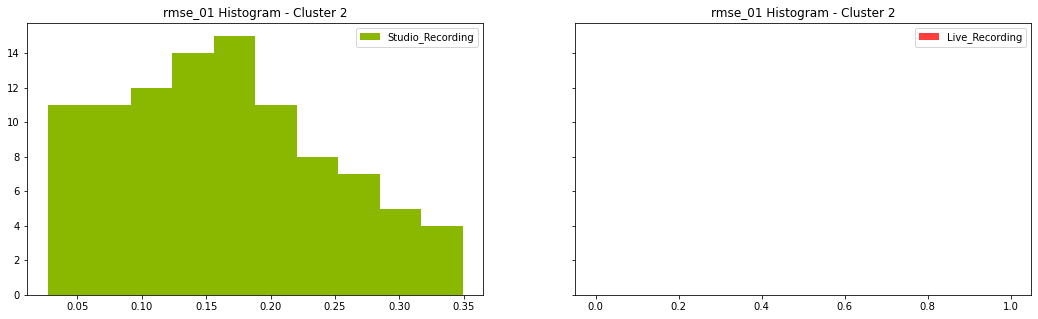

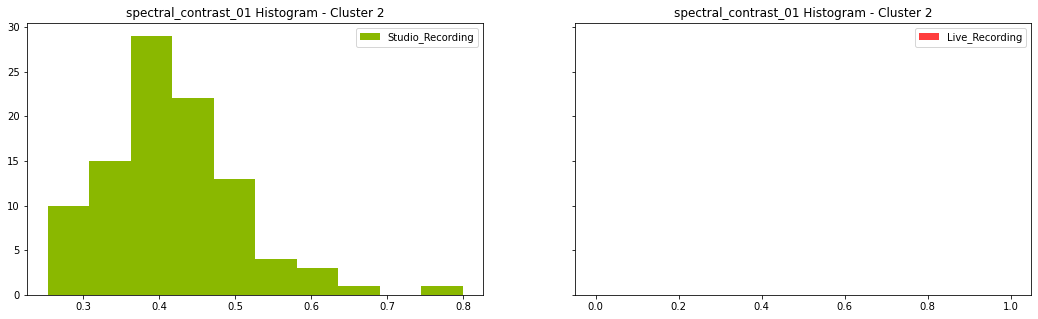

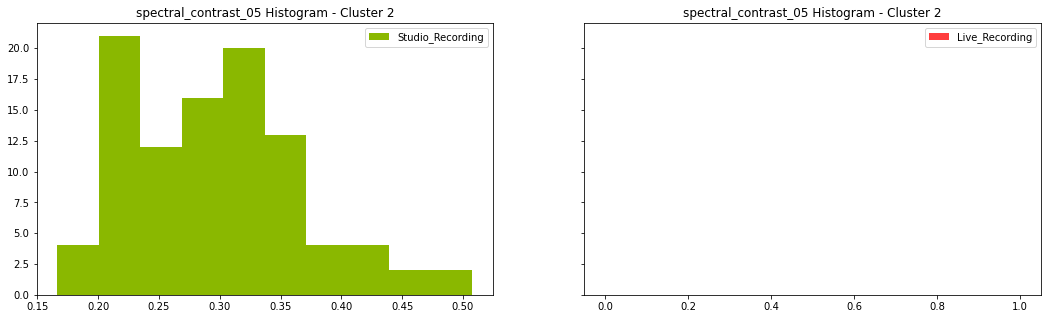

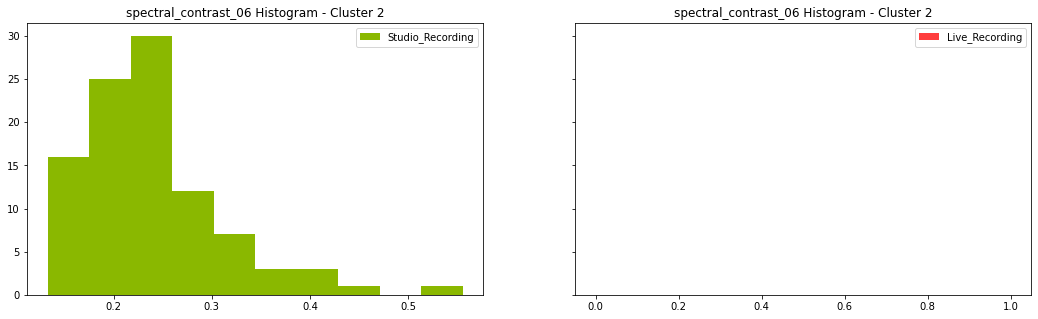

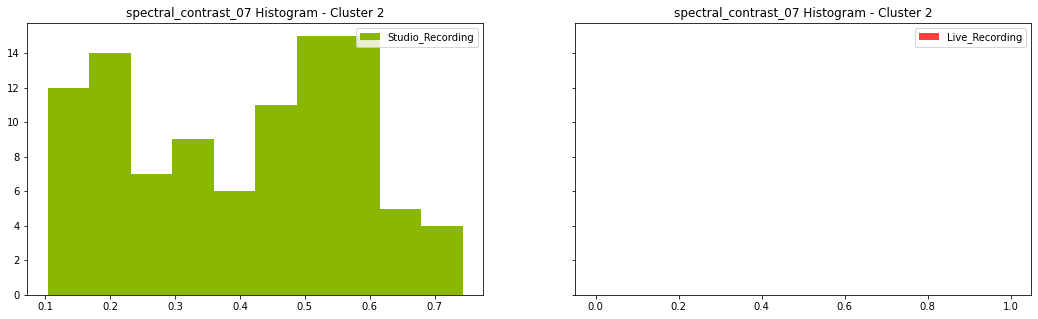

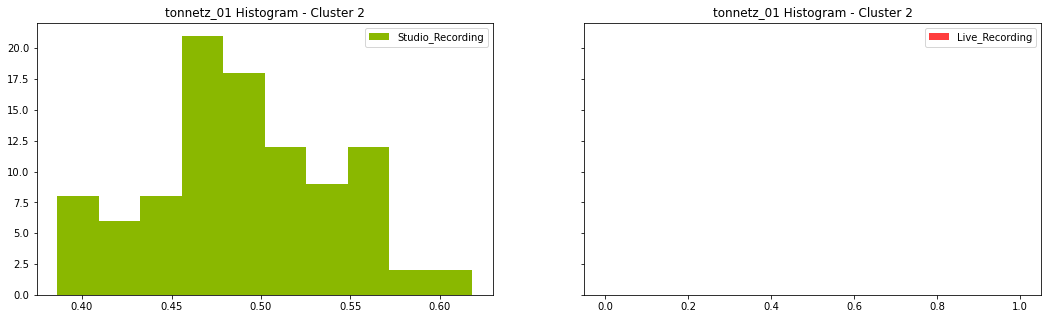

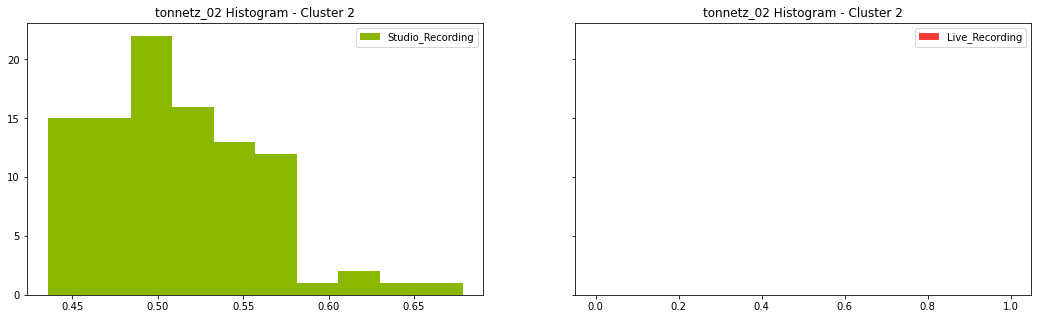

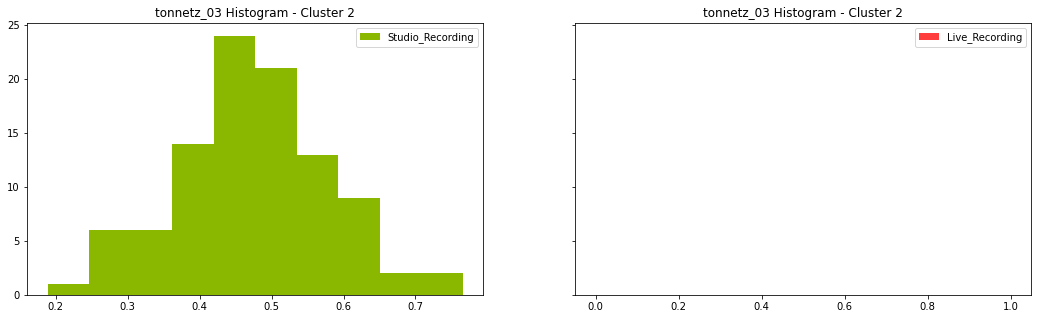

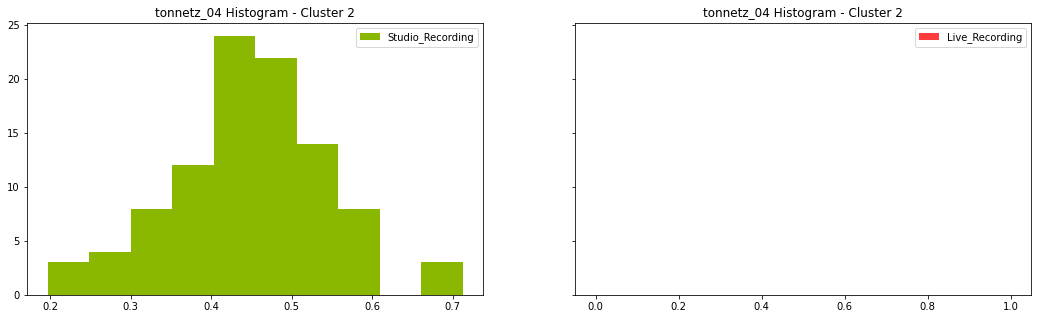

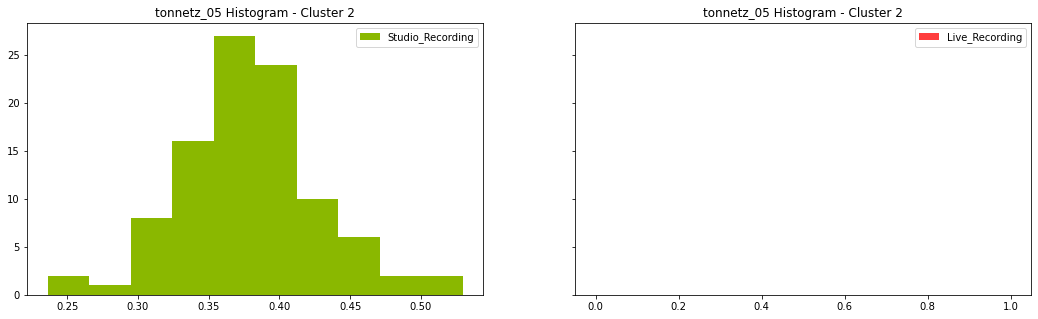

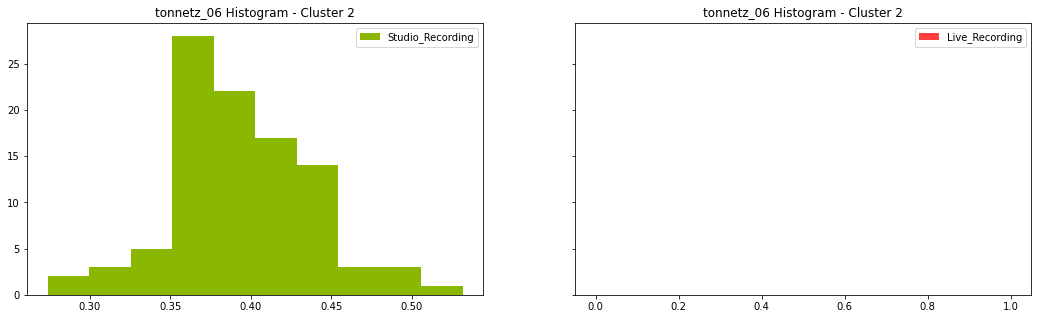

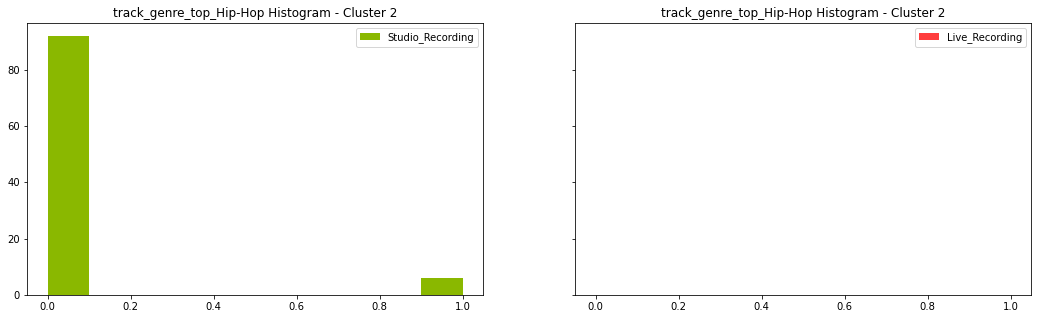

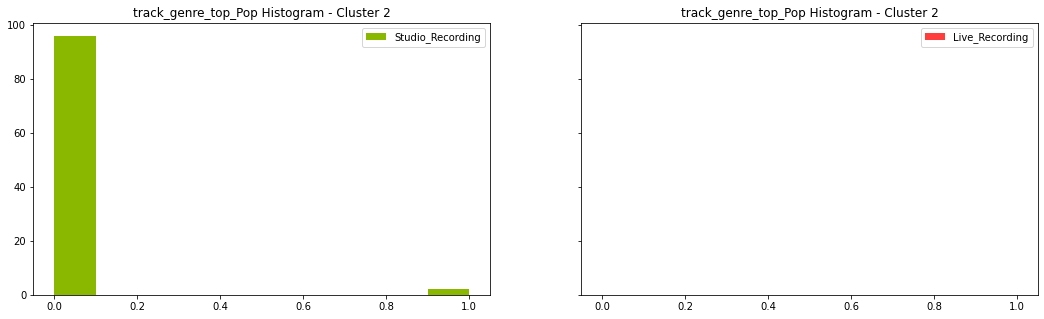

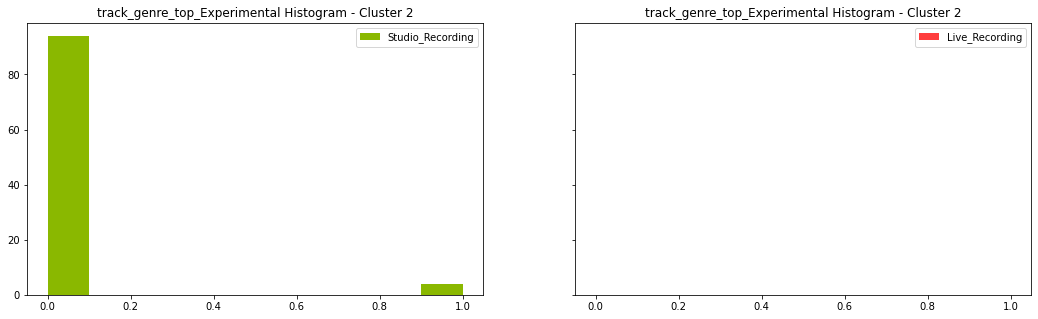

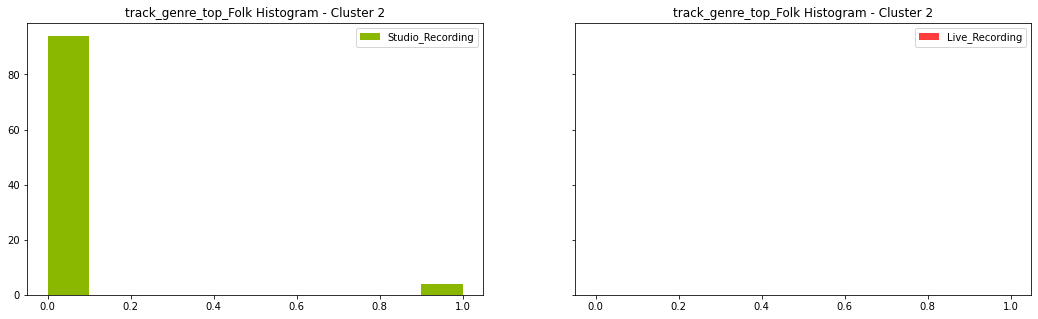

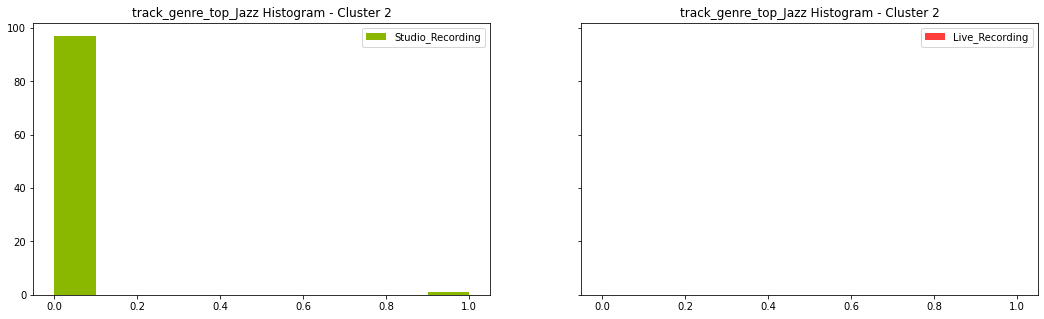

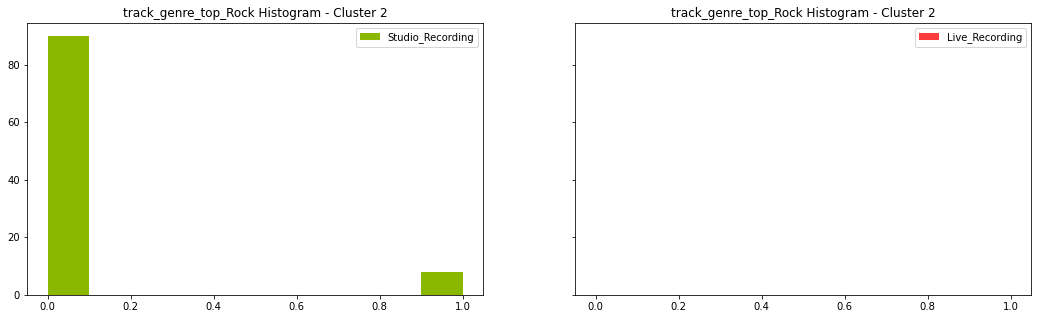

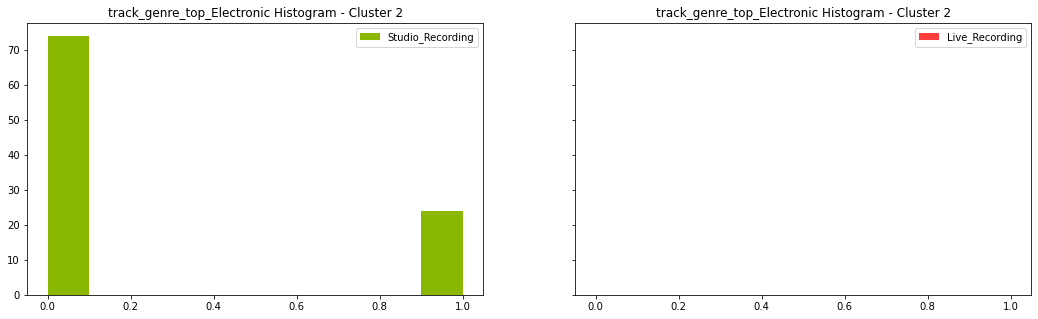

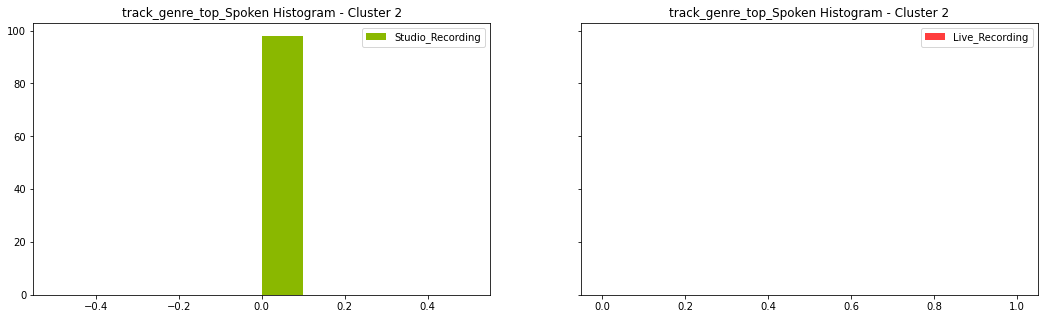

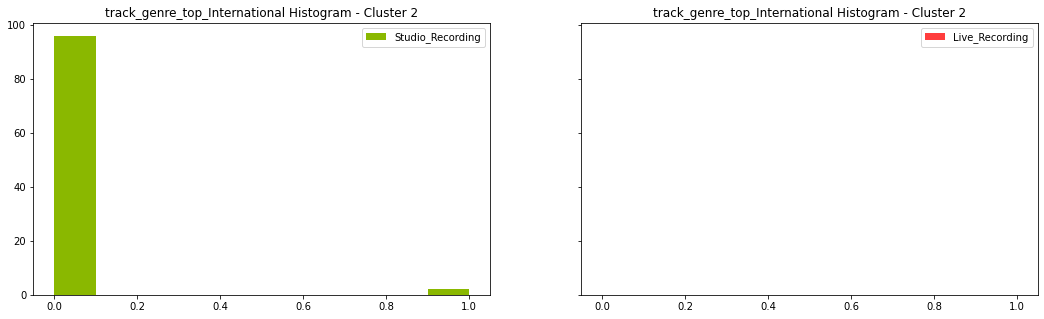

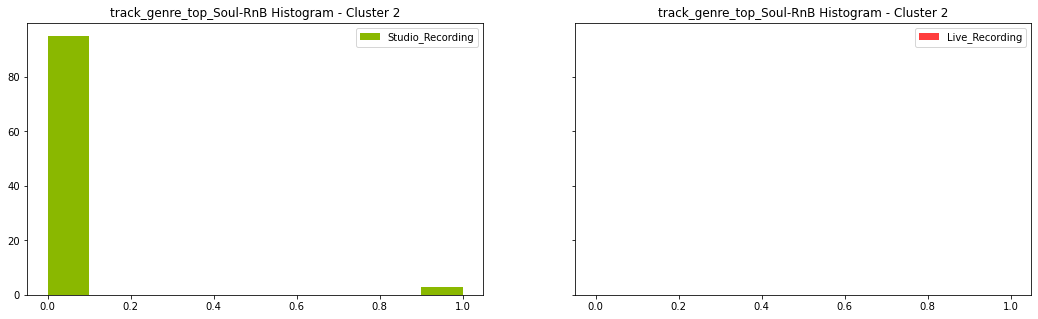

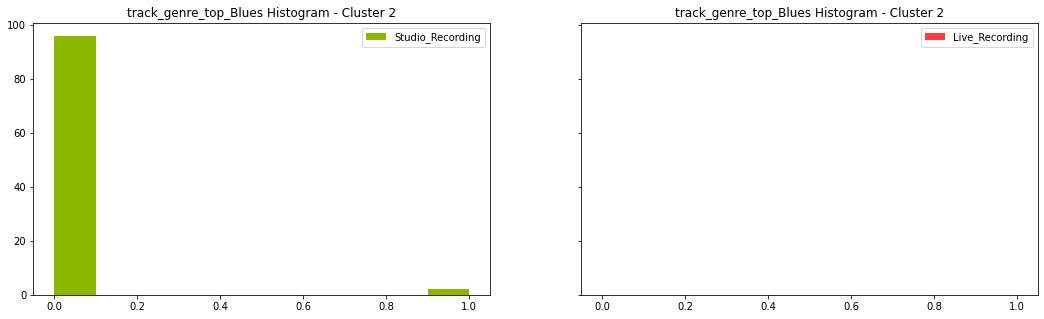

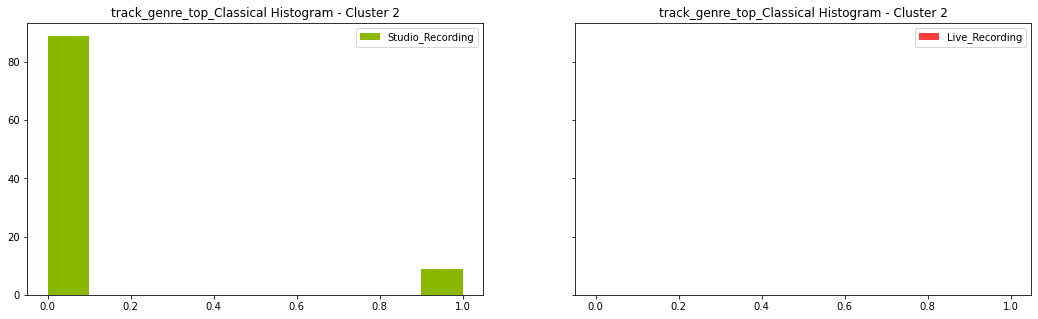

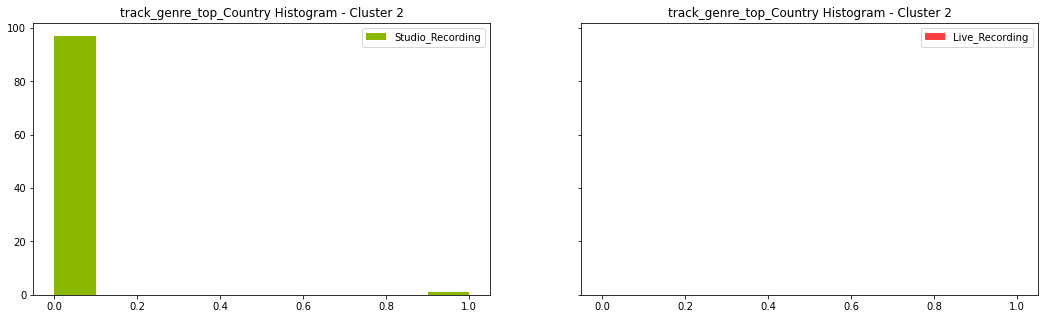

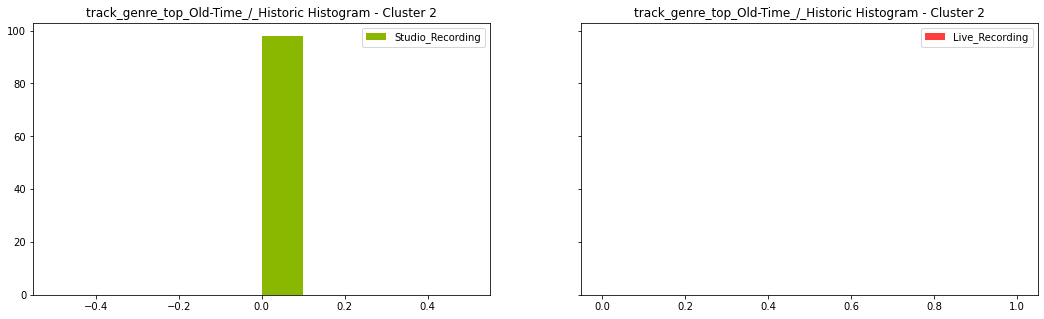

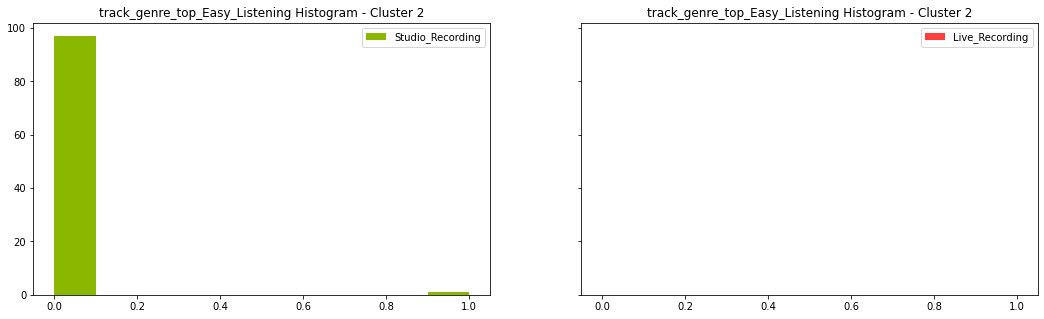

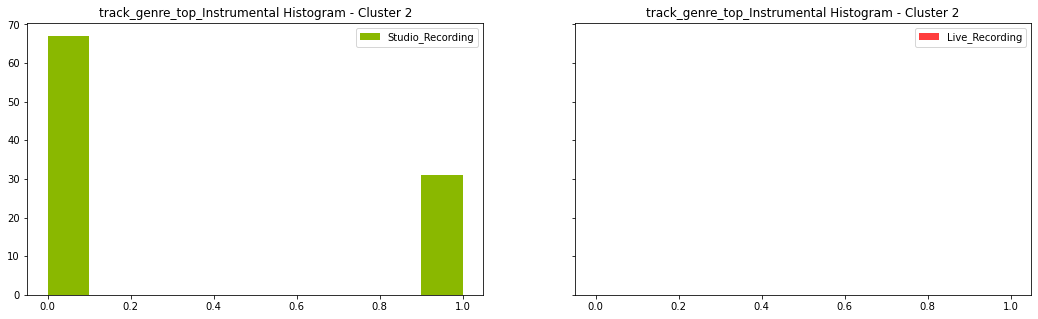

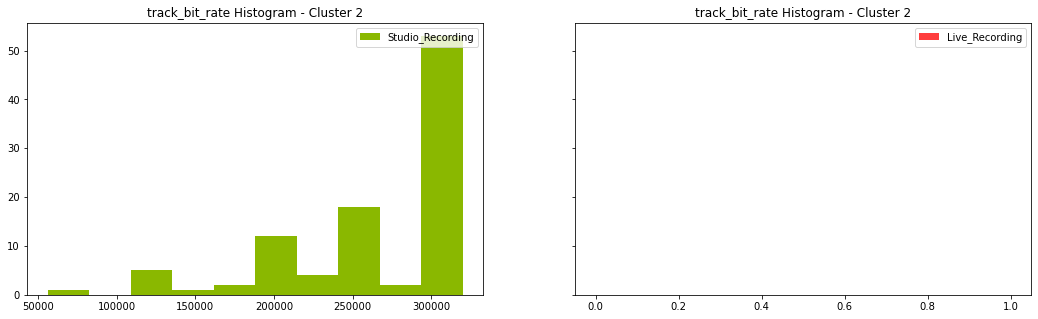

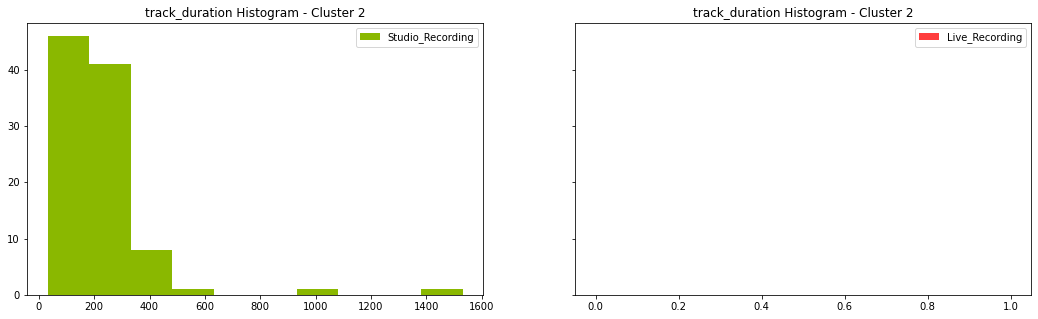

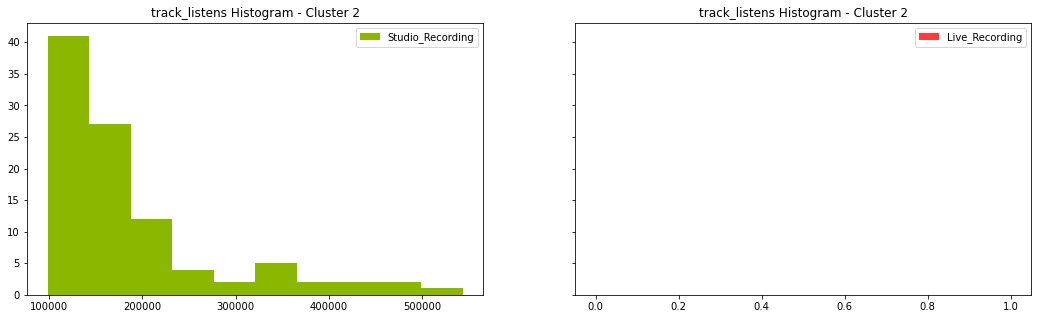

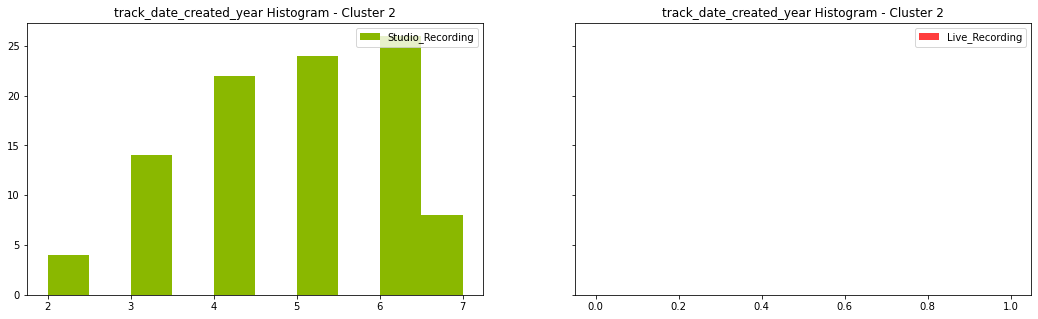

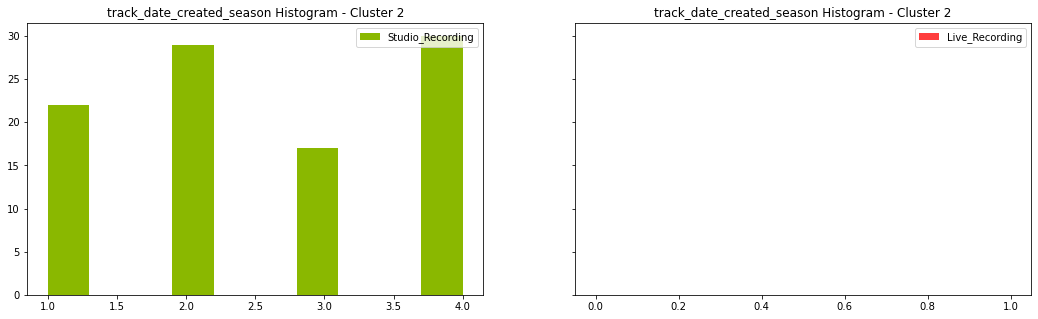

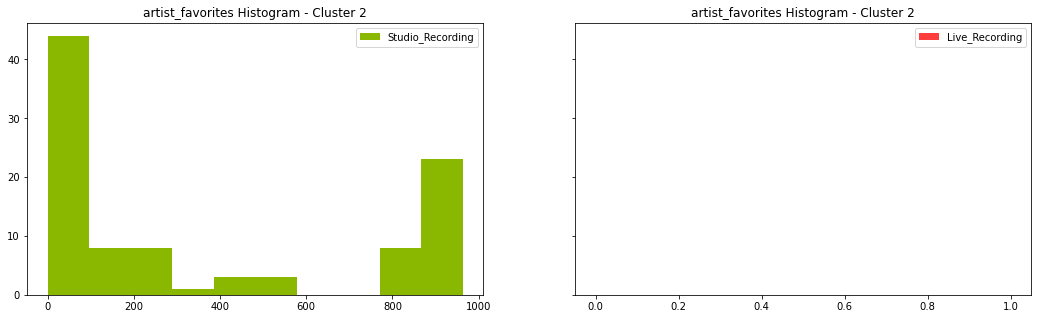

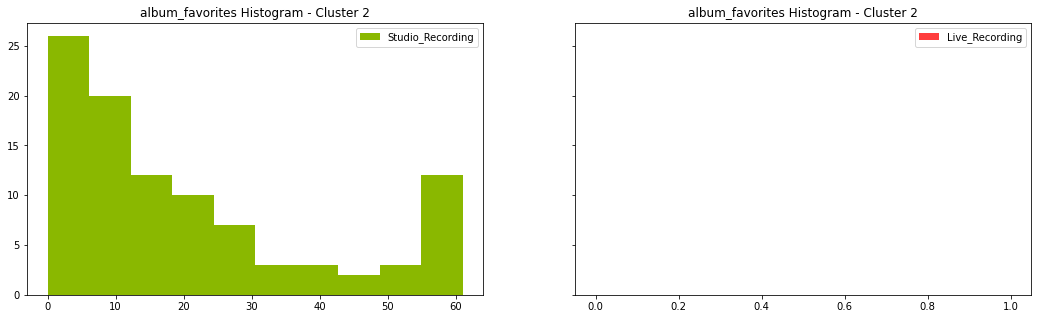

------------------------------------------------------------------------------------------------------------------


In [73]:
analyze_single_clusters(df_complete_2)